# Visual Question Answering using Multimodal Vision Transformer and Bert

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import necessary libraries & set up the environment

In [ ]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,            
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)
# import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda:0
Tesla T4
Memory Usage:
Allocated: 1.6 GB
Cached:    7.3 GB


In [ ]:
# images
%%capture
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip val2014.zip

## Load the Processed [VQA Dataset](https://visualqa.org/)

All the questions have 1-word/phrase answer, so we consider the entire vocabulary of answers available (*answer space*) & treat them as labels. This converts the visual question answering into a multi-class classification problem.

In [ ]:
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join("/content/drive/MyDrive/Zayn Nissan Works/Zayn/data_train.csv"),
        "test": os.path.join("/content/drive/MyDrive/Zayn Nissan Works/Zayn/data_eval.csv")
    }
)

with open(os.path.join("/content/drive/MyDrive/Zayn Nissan Works/Zayn/answer_space(revised).txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace("  ",""))
            #answer_space.index(ans.replace("  ","").replace(":","").replace(",","").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)
dataset

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 120998
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 514
    })
})

### Look at some of the Question/Image/Answer combinations

In [ ]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    #image = Image.open(os.path.join("/content/val2014/", str(data[id]["image_id"])+".jpg"))
    image = Image.open(os.path.join("/content/val2014",'COCO_val2014_'+ str(format(data[id]["image_id"], '012'))+".jpg"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id][("label")]))



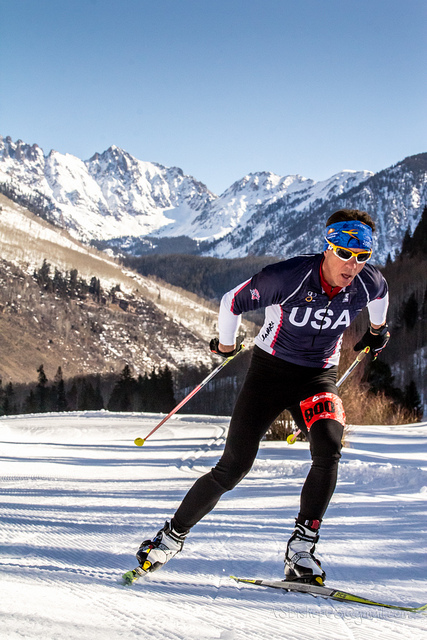

Question:	 What this person doing?
Answer:		 skiing (Label: 541)


In [ ]:
showExample()

### Create a Multimodal Collator for the Dataset

This will be used in the `Trainer()` to automatically create the `Dataloader` from the dataset to pass inputs to the model

The collator will process the **question (text)** & the **image**, and return the **tokenized text (with attention masks)** along with the **featurized image** (basically, the **pixel values**). These will be fed into our multimodal transformer model for question answering.

In [ ]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            
            images=[Image.open(os.path.join("/content/val2014",'COCO_val2014_'+str(format(image_id, '012'))+ ".jpg")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

## Defining the Multimodal VQA Model Architecture

Multimodal models can be of various forms to capture information from the text & image modalities, along with some cross-modal interaction as well.
Here, we explore **"Fusion" Models**, that fuse information from the text encoder & image encoder to perform the downstream task (visual question answering). 

The text encoder can be a text-based transformer model (like BERT, RoBERTa, etc.) while the image encoder could be an image transformer (like ViT, Deit, BeIT, etc.). After passing the tokenized question through the text-based transformer & the image features through the image transformer, the outputs are concatenated & passed through a fully-connected network with an output having the same dimensions as the answer-space.

Since we model the VQA task as a multi-class classification, it is natural to use the *Cross-Entropy Loss* as the loss function.

In [ ]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):
     
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        
        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)
        
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

### Define a Function to Create the Multimodal VQA Models along with their Collators

We plan to experiment with multiple pretrained text & image encoders for our VQA Model. Thus, we will have to create the corresponding collators along with the model (tokenizers, featurizers & models need to be loaded from same pretrained checkpoints)

In [ ]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

## Performance Metrics from Visual Question Answering

### Wu and Palmer Similarity

The Wu & Palmer similarity is a metric to calculate the sematic similarity between 2 words/phrases based on the position of concepts $c_1$ and $c_2$ in the taxonomy, relative to the position of their **_Least Common Subsumer_** $LCS(c_1, c_2)$. *(In an directed acyclic graph, the Least Common Subsumer is the is the deepest node that has both the nodes under consideration as descendants, where we define each node to be a descendant of itself)*

WUP similarity works for single-word answers (& hence, we use if for our task), but doesn't work for phrases or sentences.

`nltk` has an implementation of Wu & Palmer similarity score based on the WordNet taxanomy. Here, we have adapted the [implementation of Wu & Palmer similarity as defined along with the DAQUAR dataset](https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/calculate_wups.py).


In [ ]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score 

In [ ]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['black', 'yes', 'black', 'yes', '10']
['yes', 'stripes', 'tissue', 'yes', 'no']
Predictions vs Labels:  0.22131194295900175
Labels vs Labels:  1.0


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

## Model Training & Evaluation

### Define the Arguments needed for Training

In [ ]:
args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345, 
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training 
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=50,
    fp16=True,

    warmup_ratio=0.01,
    learning_rate=5e-4,
    weight_decay=1e-4,
    gradient_accumulation_steps=2,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)

### Create the Multimodal Models using User-Defined Text/Image  Transformers & Train it on the Dataset

In [ ]:
def createAndTrainModel(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)
    
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("..", "checkpoint", multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()
    
    return collator, model, train_multi_metrics, eval_multi_metrics

### **Model config BertConfig **{
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

### Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.15.0"
}

In [ ]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

Using cuda_amp half precision backend
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 120998
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient A

{'loss': 9.2826, 'learning_rate': 4.993455843469064e-05, 'epoch': 0.03}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.298965930938721, 'eval_wups': 0.19401988366042197, 'eval_acc': 0.17898832684824903, 'eval_f1': 0.0012865693348995918, 'eval_runtime': 6.4006, 'eval_samples_per_second': 80.304, 'eval_steps_per_second': 2.656, 'epoch': 0.03}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 6.5121, 'learning_rate': 4.986845584346906e-05, 'epoch': 0.05}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.909639358520508, 'eval_wups': 0.23443408176804628, 'eval_acc': 0.2140077821011673, 'eval_f1': 0.003367191090206255, 'eval_runtime': 5.7305, 'eval_samples_per_second': 89.696, 'eval_steps_per_second': 2.967, 'epoch': 0.05}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 5.5879, 'learning_rate': 4.980235325224749e-05, 'epoch': 0.08}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.530238151550293, 'eval_wups': 0.24095933860010216, 'eval_acc': 0.21206225680933852, 'eval_f1': 0.00408399326734625, 'eval_runtime': 6.6455, 'eval_samples_per_second': 77.346, 'eval_steps_per_second': 2.558, 'epoch': 0.08}


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 5.1059, 'learning_rate': 4.973625066102591e-05, 'epoch': 0.11}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.341394424438477, 'eval_wups': 0.2634241085323312, 'eval_acc': 0.23151750972762647, 'eval_f1': 0.005924407513390564, 'eval_runtime': 7.0023, 'eval_samples_per_second': 73.404, 'eval_steps_per_second': 2.428, 'epoch': 0.11}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.9563, 'learning_rate': 4.967014806980434e-05, 'epoch': 0.13}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.208937644958496, 'eval_wups': 0.26296834006836267, 'eval_acc': 0.23151750972762647, 'eval_f1': 0.005950712380669497, 'eval_runtime': 6.7491, 'eval_samples_per_second': 76.158, 'eval_steps_per_second': 2.519, 'epoch': 0.13}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.9827, 'learning_rate': 4.960470650449498e-05, 'epoch': 0.16}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.135506629943848, 'eval_wups': 0.26061734557354826, 'eval_acc': 0.22957198443579765, 'eval_f1': 0.00599827569484636, 'eval_runtime': 6.3222, 'eval_samples_per_second': 81.3, 'eval_steps_per_second': 2.689, 'epoch': 0.16}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.8946, 'learning_rate': 4.95386039132734e-05, 'epoch': 0.19}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.074573993682861, 'eval_wups': 0.2665586749692884, 'eval_acc': 0.23346303501945526, 'eval_f1': 0.006622851052963756, 'eval_runtime': 7.0879, 'eval_samples_per_second': 72.518, 'eval_steps_per_second': 2.398, 'epoch': 0.19}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.5493, 'learning_rate': 4.9473162347964044e-05, 'epoch': 0.21}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.054513454437256, 'eval_wups': 0.2669108230702707, 'eval_acc': 0.22957198443579765, 'eval_f1': 0.005922720564817522, 'eval_runtime': 7.0681, 'eval_samples_per_second': 72.722, 'eval_steps_per_second': 2.405, 'epoch': 0.21}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.7939, 'learning_rate': 4.940705975674247e-05, 'epoch': 0.24}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.957414150238037, 'eval_wups': 0.26121589083506774, 'eval_acc': 0.22957198443579765, 'eval_f1': 0.0063355606914802754, 'eval_runtime': 6.8461, 'eval_samples_per_second': 75.08, 'eval_steps_per_second': 2.483, 'epoch': 0.24}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.6614, 'learning_rate': 4.934095716552089e-05, 'epoch': 0.26}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.92329740524292, 'eval_wups': 0.2660529164437952, 'eval_acc': 0.23540856031128404, 'eval_f1': 0.006923149612337213, 'eval_runtime': 7.2722, 'eval_samples_per_second': 70.68, 'eval_steps_per_second': 2.338, 'epoch': 0.26}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.5177, 'learning_rate': 4.9274854574299315e-05, 'epoch': 0.29}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.921662330627441, 'eval_wups': 0.26725175576866916, 'eval_acc': 0.23540856031128404, 'eval_f1': 0.007702080522447469, 'eval_runtime': 6.3844, 'eval_samples_per_second': 80.509, 'eval_steps_per_second': 2.663, 'epoch': 0.29}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.6244, 'learning_rate': 4.9208751983077736e-05, 'epoch': 0.32}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.876718044281006, 'eval_wups': 0.27064678775238216, 'eval_acc': 0.23929961089494164, 'eval_f1': 0.008076731483569724, 'eval_runtime': 6.8178, 'eval_samples_per_second': 75.391, 'eval_steps_per_second': 2.493, 'epoch': 0.32}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.4482, 'learning_rate': 4.914264939185616e-05, 'epoch': 0.34}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.826786041259766, 'eval_wups': 0.27303593730085096, 'eval_acc': 0.23735408560311283, 'eval_f1': 0.0074822316294792255, 'eval_runtime': 7.1262, 'eval_samples_per_second': 72.129, 'eval_steps_per_second': 2.386, 'epoch': 0.34}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.5977, 'learning_rate': 4.9076546800634586e-05, 'epoch': 0.37}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.798478603363037, 'eval_wups': 0.27542826905314566, 'eval_acc': 0.24319066147859922, 'eval_f1': 0.008958128897604835, 'eval_runtime': 6.7596, 'eval_samples_per_second': 76.04, 'eval_steps_per_second': 2.515, 'epoch': 0.37}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.5474, 'learning_rate': 4.901044420941301e-05, 'epoch': 0.4}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.77716064453125, 'eval_wups': 0.27402435484590254, 'eval_acc': 0.24319066147859922, 'eval_f1': 0.009108292863567123, 'eval_runtime': 6.9705, 'eval_samples_per_second': 73.739, 'eval_steps_per_second': 2.439, 'epoch': 0.4}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.4296, 'learning_rate': 4.8944341618191435e-05, 'epoch': 0.42}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.79469108581543, 'eval_wups': 0.2731236762463616, 'eval_acc': 0.24708171206225682, 'eval_f1': 0.009240975233682464, 'eval_runtime': 6.3677, 'eval_samples_per_second': 80.719, 'eval_steps_per_second': 2.67, 'epoch': 0.42}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.4225, 'learning_rate': 4.887823902696986e-05, 'epoch': 0.45}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.728644847869873, 'eval_wups': 0.2842791169394414, 'eval_acc': 0.2509727626459144, 'eval_f1': 0.009946640518250041, 'eval_runtime': 6.6347, 'eval_samples_per_second': 77.471, 'eval_steps_per_second': 2.562, 'epoch': 0.45}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.4486, 'learning_rate': 4.8812136435748285e-05, 'epoch': 0.48}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.705483436584473, 'eval_wups': 0.2650662288271305, 'eval_acc': 0.23346303501945526, 'eval_f1': 0.011529425131192894, 'eval_runtime': 6.5719, 'eval_samples_per_second': 78.212, 'eval_steps_per_second': 2.587, 'epoch': 0.48}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.5414, 'learning_rate': 4.8746033844526706e-05, 'epoch': 0.5}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-1900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.710586071014404, 'eval_wups': 0.2776122040666017, 'eval_acc': 0.245136186770428, 'eval_f1': 0.007927646503402502, 'eval_runtime': 6.7502, 'eval_samples_per_second': 76.146, 'eval_steps_per_second': 2.518, 'epoch': 0.5}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.2407, 'learning_rate': 4.8679931253305134e-05, 'epoch': 0.53}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.738564491271973, 'eval_wups': 0.2895217773255173, 'eval_acc': 0.2587548638132296, 'eval_f1': 0.01313603758894793, 'eval_runtime': 6.6132, 'eval_samples_per_second': 77.724, 'eval_steps_per_second': 2.571, 'epoch': 0.53}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.2966, 'learning_rate': 4.8613828662083556e-05, 'epoch': 0.56}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.660945892333984, 'eval_wups': 0.28436840768701543, 'eval_acc': 0.2509727626459144, 'eval_f1': 0.015741478090252302, 'eval_runtime': 6.8254, 'eval_samples_per_second': 75.307, 'eval_steps_per_second': 2.491, 'epoch': 0.56}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.3565, 'learning_rate': 4.8547726070861984e-05, 'epoch': 0.58}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.635525703430176, 'eval_wups': 0.28970250825800037, 'eval_acc': 0.2607003891050584, 'eval_f1': 0.014298509456970821, 'eval_runtime': 6.489, 'eval_samples_per_second': 79.211, 'eval_steps_per_second': 2.62, 'epoch': 0.58}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-1900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.1901, 'learning_rate': 4.8481623479640405e-05, 'epoch': 0.61}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.623072147369385, 'eval_wups': 0.2899873678098579, 'eval_acc': 0.2607003891050584, 'eval_f1': 0.01476686687837802, 'eval_runtime': 6.4447, 'eval_samples_per_second': 79.756, 'eval_steps_per_second': 2.638, 'epoch': 0.61}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.1951, 'learning_rate': 4.8415520888418834e-05, 'epoch': 0.63}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.610196590423584, 'eval_wups': 0.2928051514537968, 'eval_acc': 0.2607003891050584, 'eval_f1': 0.01602269430954469, 'eval_runtime': 6.7834, 'eval_samples_per_second': 75.773, 'eval_steps_per_second': 2.506, 'epoch': 0.63}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.3033, 'learning_rate': 4.8349418297197255e-05, 'epoch': 0.66}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.581501483917236, 'eval_wups': 0.30093233123066154, 'eval_acc': 0.2704280155642023, 'eval_f1': 0.02025725581094068, 'eval_runtime': 6.549, 'eval_samples_per_second': 78.485, 'eval_steps_per_second': 2.596, 'epoch': 0.66}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.2013, 'learning_rate': 4.8283315705975676e-05, 'epoch': 0.69}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.568178176879883, 'eval_wups': 0.3108186797305116, 'eval_acc': 0.2821011673151751, 'eval_f1': 0.027309294025932435, 'eval_runtime': 6.395, 'eval_samples_per_second': 80.376, 'eval_steps_per_second': 2.658, 'epoch': 0.69}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.1822, 'learning_rate': 4.82172131147541e-05, 'epoch': 0.71}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.5710344314575195, 'eval_wups': 0.3129909546373606, 'eval_acc': 0.2840466926070039, 'eval_f1': 0.029802304091233103, 'eval_runtime': 6.6241, 'eval_samples_per_second': 77.596, 'eval_steps_per_second': 2.566, 'epoch': 0.71}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.1761, 'learning_rate': 4.815111052353252e-05, 'epoch': 0.74}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.535181045532227, 'eval_wups': 0.30684753151600214, 'eval_acc': 0.2782101167315175, 'eval_f1': 0.027844324584473463, 'eval_runtime': 6.4383, 'eval_samples_per_second': 79.834, 'eval_steps_per_second': 2.64, 'epoch': 0.74}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.1941, 'learning_rate': 4.808500793231095e-05, 'epoch': 0.77}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-2900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.538525581359863, 'eval_wups': 0.30549045462975377, 'eval_acc': 0.27626459143968873, 'eval_f1': 0.024095978380462135, 'eval_runtime': 6.6119, 'eval_samples_per_second': 77.739, 'eval_steps_per_second': 2.571, 'epoch': 0.77}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.2085, 'learning_rate': 4.801890534108937e-05, 'epoch': 0.79}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.4810404777526855, 'eval_wups': 0.31681713143780676, 'eval_acc': 0.2840466926070039, 'eval_f1': 0.02783924555710385, 'eval_runtime': 6.6302, 'eval_samples_per_second': 77.524, 'eval_steps_per_second': 2.564, 'epoch': 0.79}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.1284, 'learning_rate': 4.79528027498678e-05, 'epoch': 0.82}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.491459846496582, 'eval_wups': 0.3110260136774147, 'eval_acc': 0.2782101167315175, 'eval_f1': 0.02948507460250217, 'eval_runtime': 6.7393, 'eval_samples_per_second': 76.269, 'eval_steps_per_second': 2.523, 'epoch': 0.82}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.2568, 'learning_rate': 4.788670015864622e-05, 'epoch': 0.85}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.449276924133301, 'eval_wups': 0.3185066846428467, 'eval_acc': 0.28793774319066145, 'eval_f1': 0.03228483108845527, 'eval_runtime': 6.5729, 'eval_samples_per_second': 78.2, 'eval_steps_per_second': 2.586, 'epoch': 0.85}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-2900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.1466, 'learning_rate': 4.7820597567424647e-05, 'epoch': 0.87}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.453543186187744, 'eval_wups': 0.3178345595141396, 'eval_acc': 0.28793774319066145, 'eval_f1': 0.031006011304141837, 'eval_runtime': 6.5598, 'eval_samples_per_second': 78.356, 'eval_steps_per_second': 2.592, 'epoch': 0.87}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.1879, 'learning_rate': 4.775449497620307e-05, 'epoch': 0.9}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.435412883758545, 'eval_wups': 0.324583087189426, 'eval_acc': 0.29571984435797666, 'eval_f1': 0.03263258552618811, 'eval_runtime': 6.4211, 'eval_samples_per_second': 80.049, 'eval_steps_per_second': 2.648, 'epoch': 0.9}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.946, 'learning_rate': 4.7688392384981496e-05, 'epoch': 0.93}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.427718162536621, 'eval_wups': 0.32147547184742703, 'eval_acc': 0.2918287937743191, 'eval_f1': 0.03134562120993845, 'eval_runtime': 6.7418, 'eval_samples_per_second': 76.24, 'eval_steps_per_second': 2.522, 'epoch': 0.93}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.0854, 'learning_rate': 4.762228979375992e-05, 'epoch': 0.95}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.3851494789123535, 'eval_wups': 0.3271638985538672, 'eval_acc': 0.29766536964980544, 'eval_f1': 0.037909591405571985, 'eval_runtime': 6.6799, 'eval_samples_per_second': 76.947, 'eval_steps_per_second': 2.545, 'epoch': 0.95}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.0709, 'learning_rate': 4.7556187202538346e-05, 'epoch': 0.98}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.393998622894287, 'eval_wups': 0.32233975392408915, 'eval_acc': 0.2898832684824903, 'eval_f1': 0.030518731037739902, 'eval_runtime': 6.4882, 'eval_samples_per_second': 79.221, 'eval_steps_per_second': 2.62, 'epoch': 0.98}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 4.0341, 'learning_rate': 4.7490745637228984e-05, 'epoch': 1.0}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.383680820465088, 'eval_wups': 0.33126889504060353, 'eval_acc': 0.29961089494163423, 'eval_f1': 0.03680082610139303, 'eval_runtime': 6.5036, 'eval_samples_per_second': 79.033, 'eval_steps_per_second': 2.614, 'epoch': 1.0}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.8452, 'learning_rate': 4.7424643046007405e-05, 'epoch': 1.03}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-3900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.355743885040283, 'eval_wups': 0.33937863581533506, 'eval_acc': 0.30739299610894943, 'eval_f1': 0.04133458134744494, 'eval_runtime': 6.623, 'eval_samples_per_second': 77.609, 'eval_steps_per_second': 2.567, 'epoch': 1.03}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.9174, 'learning_rate': 4.735854045478583e-05, 'epoch': 1.06}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.36955451965332, 'eval_wups': 0.33724208419648743, 'eval_acc': 0.30739299610894943, 'eval_f1': 0.04351076964120621, 'eval_runtime': 6.5522, 'eval_samples_per_second': 78.447, 'eval_steps_per_second': 2.595, 'epoch': 1.06}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.9885, 'learning_rate': 4.7292437863564255e-05, 'epoch': 1.08}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.337041854858398, 'eval_wups': 0.32966909696535207, 'eval_acc': 0.301556420233463, 'eval_f1': 0.04038872138096317, 'eval_runtime': 6.5155, 'eval_samples_per_second': 78.889, 'eval_steps_per_second': 2.609, 'epoch': 1.08}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.8969, 'learning_rate': 4.7226335272342676e-05, 'epoch': 1.11}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.293928146362305, 'eval_wups': 0.3350884653067165, 'eval_acc': 0.30544747081712065, 'eval_f1': 0.04189439775220369, 'eval_runtime': 6.4064, 'eval_samples_per_second': 80.232, 'eval_steps_per_second': 2.654, 'epoch': 1.11}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.9227, 'learning_rate': 4.7160232681121104e-05, 'epoch': 1.14}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.3077826499938965, 'eval_wups': 0.3403329644207655, 'eval_acc': 0.3132295719844358, 'eval_f1': 0.04904387514374451, 'eval_runtime': 6.2447, 'eval_samples_per_second': 82.31, 'eval_steps_per_second': 2.722, 'epoch': 1.14}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-3900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.7229, 'learning_rate': 4.7094130089899526e-05, 'epoch': 1.16}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.306957721710205, 'eval_wups': 0.3397798978888638, 'eval_acc': 0.3093385214007782, 'eval_f1': 0.048511182072046695, 'eval_runtime': 6.3165, 'eval_samples_per_second': 81.374, 'eval_steps_per_second': 2.691, 'epoch': 1.16}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.7327, 'learning_rate': 4.7028688524590164e-05, 'epoch': 1.19}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.249635696411133, 'eval_wups': 0.34238900195111044, 'eval_acc': 0.3132295719844358, 'eval_f1': 0.05650965840022485, 'eval_runtime': 6.2707, 'eval_samples_per_second': 81.969, 'eval_steps_per_second': 2.711, 'epoch': 1.19}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.7052, 'learning_rate': 4.696258593336859e-05, 'epoch': 1.22}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.237485408782959, 'eval_wups': 0.35585530951647104, 'eval_acc': 0.32490272373540857, 'eval_f1': 0.05843114818217255, 'eval_runtime': 6.3626, 'eval_samples_per_second': 80.785, 'eval_steps_per_second': 2.672, 'epoch': 1.22}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.8944, 'learning_rate': 4.689648334214701e-05, 'epoch': 1.24}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.26242733001709, 'eval_wups': 0.3420985537889063, 'eval_acc': 0.3132295719844358, 'eval_f1': 0.05162395444048451, 'eval_runtime': 6.4143, 'eval_samples_per_second': 80.133, 'eval_steps_per_second': 2.65, 'epoch': 1.24}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.7853, 'learning_rate': 4.683038075092544e-05, 'epoch': 1.27}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.242747783660889, 'eval_wups': 0.34651094674433336, 'eval_acc': 0.3151750972762646, 'eval_f1': 0.0573226145388717, 'eval_runtime': 6.4245, 'eval_samples_per_second': 80.006, 'eval_steps_per_second': 2.646, 'epoch': 1.27}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.7169, 'learning_rate': 4.676427815970386e-05, 'epoch': 1.3}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-4900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.241552829742432, 'eval_wups': 0.34662557966967544, 'eval_acc': 0.3151750972762646, 'eval_f1': 0.05517679471361586, 'eval_runtime': 6.2661, 'eval_samples_per_second': 82.028, 'eval_steps_per_second': 2.713, 'epoch': 1.3}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.9264, 'learning_rate': 4.669817556848229e-05, 'epoch': 1.32}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.228862285614014, 'eval_wups': 0.35410042562357796, 'eval_acc': 0.3229571984435798, 'eval_f1': 0.05423625046082704, 'eval_runtime': 6.5383, 'eval_samples_per_second': 78.614, 'eval_steps_per_second': 2.6, 'epoch': 1.32}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.818, 'learning_rate': 4.663207297726071e-05, 'epoch': 1.35}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.285207271575928, 'eval_wups': 0.34656432883801835, 'eval_acc': 0.31712062256809337, 'eval_f1': 0.04857851419095602, 'eval_runtime': 6.3867, 'eval_samples_per_second': 80.479, 'eval_steps_per_second': 2.662, 'epoch': 1.35}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.7109, 'learning_rate': 4.6565970386039134e-05, 'epoch': 1.37}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.227698802947998, 'eval_wups': 0.3448129597613237, 'eval_acc': 0.3132295719844358, 'eval_f1': 0.04642605698213779, 'eval_runtime': 6.4261, 'eval_samples_per_second': 79.987, 'eval_steps_per_second': 2.645, 'epoch': 1.37}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.7277, 'learning_rate': 4.649986779481756e-05, 'epoch': 1.4}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.22262716293335, 'eval_wups': 0.34913155448765654, 'eval_acc': 0.31712062256809337, 'eval_f1': 0.0539365913604656, 'eval_runtime': 6.2948, 'eval_samples_per_second': 81.655, 'eval_steps_per_second': 2.701, 'epoch': 1.4}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.6655, 'learning_rate': 4.6433765203595983e-05, 'epoch': 1.43}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.220509052276611, 'eval_wups': 0.35419672737668495, 'eval_acc': 0.31906614785992216, 'eval_f1': 0.06280641495346938, 'eval_runtime': 6.3022, 'eval_samples_per_second': 81.559, 'eval_steps_per_second': 2.697, 'epoch': 1.43}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.6652, 'learning_rate': 4.6367662612374405e-05, 'epoch': 1.45}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.235705852508545, 'eval_wups': 0.3560317838803272, 'eval_acc': 0.321011673151751, 'eval_f1': 0.061927858970520756, 'eval_runtime': 7.0058, 'eval_samples_per_second': 73.368, 'eval_steps_per_second': 2.427, 'epoch': 1.45}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-4600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.745, 'learning_rate': 4.6301560021152826e-05, 'epoch': 1.48}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.201138973236084, 'eval_wups': 0.3545674671124151, 'eval_acc': 0.3229571984435798, 'eval_f1': 0.05875844672480547, 'eval_runtime': 6.4826, 'eval_samples_per_second': 79.289, 'eval_steps_per_second': 2.622, 'epoch': 1.48}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.7191, 'learning_rate': 4.6235457429931254e-05, 'epoch': 1.51}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.150738716125488, 'eval_wups': 0.3586517578660338, 'eval_acc': 0.32879377431906615, 'eval_f1': 0.06360407670879492, 'eval_runtime': 6.2611, 'eval_samples_per_second': 82.095, 'eval_steps_per_second': 2.715, 'epoch': 1.51}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.8083, 'learning_rate': 4.6169354838709676e-05, 'epoch': 1.53}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.11301851272583, 'eval_wups': 0.3652009754205457, 'eval_acc': 0.3346303501945525, 'eval_f1': 0.06715002720412502, 'eval_runtime': 6.2182, 'eval_samples_per_second': 82.661, 'eval_steps_per_second': 2.734, 'epoch': 1.53}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.8259, 'learning_rate': 4.6103252247488104e-05, 'epoch': 1.56}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-5900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.127387523651123, 'eval_wups': 0.36935483867783636, 'eval_acc': 0.33852140077821014, 'eval_f1': 0.06133167811224926, 'eval_runtime': 6.3322, 'eval_samples_per_second': 81.172, 'eval_steps_per_second': 2.685, 'epoch': 1.56}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.61, 'learning_rate': 4.6037149656266525e-05, 'epoch': 1.59}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.138175010681152, 'eval_wups': 0.374758084875012, 'eval_acc': 0.3443579766536965, 'eval_f1': 0.062488151611995855, 'eval_runtime': 6.919, 'eval_samples_per_second': 74.288, 'eval_steps_per_second': 2.457, 'epoch': 1.59}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.6887, 'learning_rate': 4.5971047065044954e-05, 'epoch': 1.61}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.1703290939331055, 'eval_wups': 0.35697761893498714, 'eval_acc': 0.32684824902723736, 'eval_f1': 0.05906126564336229, 'eval_runtime': 6.3401, 'eval_samples_per_second': 81.071, 'eval_steps_per_second': 2.681, 'epoch': 1.61}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.5771, 'learning_rate': 4.5904944473823375e-05, 'epoch': 1.64}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.117811679840088, 'eval_wups': 0.35790489352205607, 'eval_acc': 0.32490272373540857, 'eval_f1': 0.05856303172411039, 'eval_runtime': 6.4429, 'eval_samples_per_second': 79.777, 'eval_steps_per_second': 2.639, 'epoch': 1.64}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-5900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.6553, 'learning_rate': 4.58388418826018e-05, 'epoch': 1.67}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.119251251220703, 'eval_wups': 0.3555621315236759, 'eval_acc': 0.32490272373540857, 'eval_f1': 0.06183023088023089, 'eval_runtime': 6.4209, 'eval_samples_per_second': 80.052, 'eval_steps_per_second': 2.648, 'epoch': 1.67}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-6100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.6825, 'learning_rate': 4.5772739291380225e-05, 'epoch': 1.69}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.162417888641357, 'eval_wups': 0.3599068762209286, 'eval_acc': 0.32879377431906615, 'eval_f1': 0.06774482382413616, 'eval_runtime': 6.3317, 'eval_samples_per_second': 81.179, 'eval_steps_per_second': 2.685, 'epoch': 1.69}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-6200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.5667, 'learning_rate': 4.570663670015865e-05, 'epoch': 1.72}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.112172603607178, 'eval_wups': 0.3807725572933654, 'eval_acc': 0.35019455252918286, 'eval_f1': 0.06472214514153049, 'eval_runtime': 6.442, 'eval_samples_per_second': 79.789, 'eval_steps_per_second': 2.639, 'epoch': 1.72}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-6000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.7072, 'learning_rate': 4.5640534108937074e-05, 'epoch': 1.75}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.1043572425842285, 'eval_wups': 0.3955859080428774, 'eval_acc': 0.3657587548638132, 'eval_f1': 0.06212860922349633, 'eval_runtime': 6.431, 'eval_samples_per_second': 79.926, 'eval_steps_per_second': 2.643, 'epoch': 1.75}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-6300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.5993, 'learning_rate': 4.5574431517715496e-05, 'epoch': 1.77}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.112959384918213, 'eval_wups': 0.3653210285852462, 'eval_acc': 0.3346303501945525, 'eval_f1': 0.06210993265853297, 'eval_runtime': 6.4803, 'eval_samples_per_second': 79.317, 'eval_steps_per_second': 2.623, 'epoch': 1.77}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-6400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.5482, 'learning_rate': 4.5508328926493924e-05, 'epoch': 1.8}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.0666303634643555, 'eval_wups': 0.36526464526646385, 'eval_acc': 0.33073929961089493, 'eval_f1': 0.057179924009188615, 'eval_runtime': 6.4727, 'eval_samples_per_second': 79.411, 'eval_steps_per_second': 2.626, 'epoch': 1.8}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-6500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.5743, 'learning_rate': 4.5442226335272345e-05, 'epoch': 1.82}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-6900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.065023899078369, 'eval_wups': 0.397812616045524, 'eval_acc': 0.36770428015564205, 'eval_f1': 0.07375806981923112, 'eval_runtime': 6.3397, 'eval_samples_per_second': 81.076, 'eval_steps_per_second': 2.682, 'epoch': 1.82}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-6600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.7838, 'learning_rate': 4.537612374405077e-05, 'epoch': 1.85}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-7000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.046743869781494, 'eval_wups': 0.3971510946516916, 'eval_acc': 0.36964980544747084, 'eval_f1': 0.06701957894350795, 'eval_runtime': 6.0736, 'eval_samples_per_second': 84.628, 'eval_steps_per_second': 2.799, 'epoch': 1.85}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-6700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.5689, 'learning_rate': 4.531002115282919e-05, 'epoch': 1.88}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-7100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.065822124481201, 'eval_wups': 0.3654971294369227, 'eval_acc': 0.33657587548638135, 'eval_f1': 0.06088106034477173, 'eval_runtime': 6.3856, 'eval_samples_per_second': 80.494, 'eval_steps_per_second': 2.662, 'epoch': 1.88}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-6800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.5634, 'learning_rate': 4.5243918561607616e-05, 'epoch': 1.9}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-7200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.03651762008667, 'eval_wups': 0.39715064595495336, 'eval_acc': 0.3657587548638132, 'eval_f1': 0.06564346971036594, 'eval_runtime': 6.226, 'eval_samples_per_second': 82.557, 'eval_steps_per_second': 2.73, 'epoch': 1.9}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-7000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.5244, 'learning_rate': 4.517781597038604e-05, 'epoch': 1.93}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-7300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.046125411987305, 'eval_wups': 0.3742296143610422, 'eval_acc': 0.3443579766536965, 'eval_f1': 0.06457488415928488, 'eval_runtime': 6.1609, 'eval_samples_per_second': 83.429, 'eval_steps_per_second': 2.759, 'epoch': 1.93}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-7100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.6216, 'learning_rate': 4.5111713379164466e-05, 'epoch': 1.96}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-7400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.097383499145508, 'eval_wups': 0.37898429968270697, 'eval_acc': 0.3463035019455253, 'eval_f1': 0.06761554144668826, 'eval_runtime': 6.3353, 'eval_samples_per_second': 81.132, 'eval_steps_per_second': 2.683, 'epoch': 1.96}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-7200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.6045, 'learning_rate': 4.504561078794289e-05, 'epoch': 1.98}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-7500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.014482021331787, 'eval_wups': 0.3864056521268137, 'eval_acc': 0.35797665369649806, 'eval_f1': 0.07706135987097189, 'eval_runtime': 6.443, 'eval_samples_per_second': 79.777, 'eval_steps_per_second': 2.639, 'epoch': 1.98}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-7300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.4695, 'learning_rate': 4.4979508196721315e-05, 'epoch': 2.01}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-7600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.015580177307129, 'eval_wups': 0.3953089957848917, 'eval_acc': 0.3657587548638132, 'eval_f1': 0.06907909798353594, 'eval_runtime': 6.1839, 'eval_samples_per_second': 83.12, 'eval_steps_per_second': 2.749, 'epoch': 2.01}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-7400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.3465, 'learning_rate': 4.491340560549974e-05, 'epoch': 2.04}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-7700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.982527732849121, 'eval_wups': 0.40302735135643114, 'eval_acc': 0.3735408560311284, 'eval_f1': 0.07970734586945029, 'eval_runtime': 6.2412, 'eval_samples_per_second': 82.356, 'eval_steps_per_second': 2.724, 'epoch': 2.04}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-6900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2402, 'learning_rate': 4.4847303014278165e-05, 'epoch': 2.06}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-7800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.989657163619995, 'eval_wups': 0.37870327694393957, 'eval_acc': 0.35019455252918286, 'eval_f1': 0.07366075057034777, 'eval_runtime': 6.271, 'eval_samples_per_second': 81.965, 'eval_steps_per_second': 2.711, 'epoch': 2.06}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-7500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.3523, 'learning_rate': 4.4781200423056586e-05, 'epoch': 2.09}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-7900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9696624279022217, 'eval_wups': 0.3784019303605878, 'eval_acc': 0.34824902723735407, 'eval_f1': 0.07374319131786608, 'eval_runtime': 6.2411, 'eval_samples_per_second': 82.357, 'eval_steps_per_second': 2.724, 'epoch': 2.09}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-7600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.3976, 'learning_rate': 4.4715097831835015e-05, 'epoch': 2.12}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-8000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.019531726837158, 'eval_wups': 0.40903117075006656, 'eval_acc': 0.37937743190661477, 'eval_f1': 0.08241423544671148, 'eval_runtime': 6.1422, 'eval_samples_per_second': 83.684, 'eval_steps_per_second': 2.768, 'epoch': 2.12}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-7700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.3639, 'learning_rate': 4.4648995240613436e-05, 'epoch': 2.14}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-8100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9840352535247803, 'eval_wups': 0.40655940111398603, 'eval_acc': 0.377431906614786, 'eval_f1': 0.07703478307203603, 'eval_runtime': 6.0796, 'eval_samples_per_second': 84.545, 'eval_steps_per_second': 2.796, 'epoch': 2.14}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-7800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.4011, 'learning_rate': 4.4582892649391864e-05, 'epoch': 2.17}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-8200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9723401069641113, 'eval_wups': 0.387235777087658, 'eval_acc': 0.3560311284046693, 'eval_f1': 0.06345546691713247, 'eval_runtime': 6.3816, 'eval_samples_per_second': 80.544, 'eval_steps_per_second': 2.664, 'epoch': 2.17}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-7900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2611, 'learning_rate': 4.4516790058170286e-05, 'epoch': 2.19}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-8300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.996323585510254, 'eval_wups': 0.38122527050470884, 'eval_acc': 0.35019455252918286, 'eval_f1': 0.0665900112464291, 'eval_runtime': 6.3498, 'eval_samples_per_second': 80.947, 'eval_steps_per_second': 2.677, 'epoch': 2.19}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-8100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.3794, 'learning_rate': 4.445068746694871e-05, 'epoch': 2.22}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-8400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.998781204223633, 'eval_wups': 0.3967194747098162, 'eval_acc': 0.3657587548638132, 'eval_f1': 0.08286934444276461, 'eval_runtime': 6.2532, 'eval_samples_per_second': 82.198, 'eval_steps_per_second': 2.719, 'epoch': 2.22}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-8200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2735, 'learning_rate': 4.438458487572713e-05, 'epoch': 2.25}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-8500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.043688774108887, 'eval_wups': 0.38074506393156965, 'eval_acc': 0.35019455252918286, 'eval_f1': 0.07660932574142514, 'eval_runtime': 6.1787, 'eval_samples_per_second': 83.189, 'eval_steps_per_second': 2.751, 'epoch': 2.25}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-8300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.3127, 'learning_rate': 4.431848228450555e-05, 'epoch': 2.27}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-8600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.950840473175049, 'eval_wups': 0.38746059503232505, 'eval_acc': 0.35797665369649806, 'eval_f1': 0.08191108478753352, 'eval_runtime': 6.1139, 'eval_samples_per_second': 84.071, 'eval_steps_per_second': 2.781, 'epoch': 2.27}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-8400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.37, 'learning_rate': 4.425237969328398e-05, 'epoch': 2.3}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-8700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9655017852783203, 'eval_wups': 0.3894256361555107, 'eval_acc': 0.35992217898832685, 'eval_f1': 0.08062418750764512, 'eval_runtime': 6.1919, 'eval_samples_per_second': 83.011, 'eval_steps_per_second': 2.746, 'epoch': 2.3}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-8500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.331, 'learning_rate': 4.41862771020624e-05, 'epoch': 2.33}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-8800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.963636875152588, 'eval_wups': 0.38348053730737186, 'eval_acc': 0.3521400778210117, 'eval_f1': 0.07992580708691753, 'eval_runtime': 6.1154, 'eval_samples_per_second': 84.05, 'eval_steps_per_second': 2.78, 'epoch': 2.33}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-8600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2815, 'learning_rate': 4.412017451084083e-05, 'epoch': 2.35}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-8900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.937751531600952, 'eval_wups': 0.3911652203865622, 'eval_acc': 0.36186770428015563, 'eval_f1': 0.07864569725663394, 'eval_runtime': 6.0928, 'eval_samples_per_second': 84.362, 'eval_steps_per_second': 2.79, 'epoch': 2.35}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-8700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2891, 'learning_rate': 4.405407191961925e-05, 'epoch': 2.38}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-9000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.942077875137329, 'eval_wups': 0.4025962325244692, 'eval_acc': 0.3735408560311284, 'eval_f1': 0.08099255290655291, 'eval_runtime': 6.2934, 'eval_samples_per_second': 81.673, 'eval_steps_per_second': 2.701, 'epoch': 2.38}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-8800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.3734, 'learning_rate': 4.398796932839768e-05, 'epoch': 2.41}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-9100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.940190315246582, 'eval_wups': 0.3989193500821259, 'eval_acc': 0.36964980544747084, 'eval_f1': 0.083196806881714, 'eval_runtime': 6.2423, 'eval_samples_per_second': 82.342, 'eval_steps_per_second': 2.723, 'epoch': 2.41}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-8900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2231, 'learning_rate': 4.39218667371761e-05, 'epoch': 2.43}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-9200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.989447832107544, 'eval_wups': 0.40500653141757137, 'eval_acc': 0.3754863813229572, 'eval_f1': 0.08330579354570108, 'eval_runtime': 6.2987, 'eval_samples_per_second': 81.604, 'eval_steps_per_second': 2.699, 'epoch': 2.43}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-9000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.4306, 'learning_rate': 4.385576414595453e-05, 'epoch': 2.46}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-9300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.96661639213562, 'eval_wups': 0.4123601958717798, 'eval_acc': 0.3832684824902724, 'eval_f1': 0.08433174690145197, 'eval_runtime': 6.212, 'eval_samples_per_second': 82.743, 'eval_steps_per_second': 2.737, 'epoch': 2.46}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-8000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.3027, 'learning_rate': 4.378966155473295e-05, 'epoch': 2.49}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-9400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.925402879714966, 'eval_wups': 0.3891073505229092, 'eval_acc': 0.35992217898832685, 'eval_f1': 0.08413392373031785, 'eval_runtime': 6.0353, 'eval_samples_per_second': 85.166, 'eval_steps_per_second': 2.817, 'epoch': 2.49}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-9100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.3106, 'learning_rate': 4.3723558963511376e-05, 'epoch': 2.51}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-9500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9069318771362305, 'eval_wups': 0.4054019448161828, 'eval_acc': 0.3754863813229572, 'eval_f1': 0.08718880487422205, 'eval_runtime': 6.2439, 'eval_samples_per_second': 82.32, 'eval_steps_per_second': 2.723, 'epoch': 2.51}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-9200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2427, 'learning_rate': 4.36574563722898e-05, 'epoch': 2.54}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-9600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9058034420013428, 'eval_wups': 0.4009971168941448, 'eval_acc': 0.3715953307392996, 'eval_f1': 0.087943035609506, 'eval_runtime': 6.2872, 'eval_samples_per_second': 81.754, 'eval_steps_per_second': 2.704, 'epoch': 2.54}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-9400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.3388, 'learning_rate': 4.3591353781068226e-05, 'epoch': 2.56}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-9700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.89290714263916, 'eval_wups': 0.4100130648930695, 'eval_acc': 0.38132295719844356, 'eval_f1': 0.09015323597025904, 'eval_runtime': 5.9983, 'eval_samples_per_second': 85.691, 'eval_steps_per_second': 2.834, 'epoch': 2.56}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-9500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2456, 'learning_rate': 4.352525118984665e-05, 'epoch': 2.59}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-9800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8881566524505615, 'eval_wups': 0.4177637304148384, 'eval_acc': 0.38715953307393, 'eval_f1': 0.09382038233357111, 'eval_runtime': 6.1048, 'eval_samples_per_second': 84.196, 'eval_steps_per_second': 2.785, 'epoch': 2.59}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-9300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2303, 'learning_rate': 4.345914859862507e-05, 'epoch': 2.62}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-9900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8817362785339355, 'eval_wups': 0.4064529795507091, 'eval_acc': 0.3754863813229572, 'eval_f1': 0.08422325174610654, 'eval_runtime': 6.3636, 'eval_samples_per_second': 80.772, 'eval_steps_per_second': 2.671, 'epoch': 2.62}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-9600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.3299, 'learning_rate': 4.339370703331571e-05, 'epoch': 2.64}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-10000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8626933097839355, 'eval_wups': 0.39742981623771567, 'eval_acc': 0.36770428015564205, 'eval_f1': 0.08348982266632446, 'eval_runtime': 6.0721, 'eval_samples_per_second': 84.65, 'eval_steps_per_second': 2.8, 'epoch': 2.64}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-9700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.1816, 'learning_rate': 4.3327604442094135e-05, 'epoch': 2.67}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-10100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8454036712646484, 'eval_wups': 0.39716654378158234, 'eval_acc': 0.3657587548638132, 'eval_f1': 0.07762566860629744, 'eval_runtime': 6.2315, 'eval_samples_per_second': 82.484, 'eval_steps_per_second': 2.728, 'epoch': 2.67}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-9900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.195, 'learning_rate': 4.3261501850872556e-05, 'epoch': 2.7}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-10200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.885119676589966, 'eval_wups': 0.41578467087580323, 'eval_acc': 0.38715953307393, 'eval_f1': 0.09374348044282683, 'eval_runtime': 6.3123, 'eval_samples_per_second': 81.428, 'eval_steps_per_second': 2.693, 'epoch': 2.7}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-10000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.1579, 'learning_rate': 4.3195399259650984e-05, 'epoch': 2.72}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-10300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.860050916671753, 'eval_wups': 0.4102189709840076, 'eval_acc': 0.37937743190661477, 'eval_f1': 0.09205670312591883, 'eval_runtime': 6.3894, 'eval_samples_per_second': 80.445, 'eval_steps_per_second': 2.661, 'epoch': 2.72}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-10100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2275, 'learning_rate': 4.3129296668429406e-05, 'epoch': 2.75}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-10400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.875472068786621, 'eval_wups': 0.39899329762838287, 'eval_acc': 0.36770428015564205, 'eval_f1': 0.08808979212128044, 'eval_runtime': 6.3871, 'eval_samples_per_second': 80.475, 'eval_steps_per_second': 2.662, 'epoch': 2.75}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-10200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2466, 'learning_rate': 4.306319407720783e-05, 'epoch': 2.78}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-10500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.863969564437866, 'eval_wups': 0.40452886912155206, 'eval_acc': 0.3735408560311284, 'eval_f1': 0.09062794730231451, 'eval_runtime': 6.2763, 'eval_samples_per_second': 81.895, 'eval_steps_per_second': 2.709, 'epoch': 2.78}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-10300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.1874, 'learning_rate': 4.299709148598625e-05, 'epoch': 2.8}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-10600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8999931812286377, 'eval_wups': 0.40104227184126046, 'eval_acc': 0.36964980544747084, 'eval_f1': 0.08980246768783655, 'eval_runtime': 6.1797, 'eval_samples_per_second': 83.175, 'eval_steps_per_second': 2.751, 'epoch': 2.8}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-10400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2119, 'learning_rate': 4.293098889476468e-05, 'epoch': 2.83}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-10700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.880218267440796, 'eval_wups': 0.40633803234267457, 'eval_acc': 0.3754863813229572, 'eval_f1': 0.0956567643045334, 'eval_runtime': 6.1405, 'eval_samples_per_second': 83.706, 'eval_steps_per_second': 2.768, 'epoch': 2.83}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-10500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.1723, 'learning_rate': 4.28648863035431e-05, 'epoch': 2.86}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-10800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.851947784423828, 'eval_wups': 0.41551545006299206, 'eval_acc': 0.3852140077821012, 'eval_f1': 0.09613610446240846, 'eval_runtime': 6.2964, 'eval_samples_per_second': 81.635, 'eval_steps_per_second': 2.7, 'epoch': 2.86}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-10600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2365, 'learning_rate': 4.2798783712321526e-05, 'epoch': 2.88}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-10900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.829251527786255, 'eval_wups': 0.3929198661389542, 'eval_acc': 0.36186770428015563, 'eval_f1': 0.09293066281386037, 'eval_runtime': 6.1254, 'eval_samples_per_second': 83.913, 'eval_steps_per_second': 2.775, 'epoch': 2.88}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-10700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.1998, 'learning_rate': 4.273268112109995e-05, 'epoch': 2.91}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-11000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8434174060821533, 'eval_wups': 0.39396819715484827, 'eval_acc': 0.36186770428015563, 'eval_f1': 0.0888974252936484, 'eval_runtime': 6.1011, 'eval_samples_per_second': 84.248, 'eval_steps_per_second': 2.786, 'epoch': 2.91}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-10800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.2403, 'learning_rate': 4.2666578529878376e-05, 'epoch': 2.93}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-11100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.825535297393799, 'eval_wups': 0.40155483156606275, 'eval_acc': 0.3715953307392996, 'eval_f1': 0.08531851462095197, 'eval_runtime': 6.4995, 'eval_samples_per_second': 79.083, 'eval_steps_per_second': 2.616, 'epoch': 2.93}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-10900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.1091, 'learning_rate': 4.26004759386568e-05, 'epoch': 2.96}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-11200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8423054218292236, 'eval_wups': 0.40382372192601634, 'eval_acc': 0.3735408560311284, 'eval_f1': 0.0867882936133187, 'eval_runtime': 6.3892, 'eval_samples_per_second': 80.448, 'eval_steps_per_second': 2.661, 'epoch': 2.96}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-11000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.1379, 'learning_rate': 4.253437334743522e-05, 'epoch': 2.99}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-11300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.861320972442627, 'eval_wups': 0.404303045995444, 'eval_acc': 0.3735408560311284, 'eval_f1': 0.09498008640890819, 'eval_runtime': 6.0573, 'eval_samples_per_second': 84.856, 'eval_steps_per_second': 2.807, 'epoch': 2.99}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-11100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.985, 'learning_rate': 4.246827075621365e-05, 'epoch': 3.01}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-11400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8965210914611816, 'eval_wups': 0.40286275131300303, 'eval_acc': 0.3715953307392996, 'eval_f1': 0.09877854415464558, 'eval_runtime': 6.2647, 'eval_samples_per_second': 82.047, 'eval_steps_per_second': 2.714, 'epoch': 3.01}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-11200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.0128, 'learning_rate': 4.240216816499207e-05, 'epoch': 3.04}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-11500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8815553188323975, 'eval_wups': 0.3955203474294933, 'eval_acc': 0.3638132295719844, 'eval_f1': 0.09749912266208673, 'eval_runtime': 6.3417, 'eval_samples_per_second': 81.051, 'eval_steps_per_second': 2.681, 'epoch': 3.04}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-11300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9575, 'learning_rate': 4.2336065573770497e-05, 'epoch': 3.07}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-11600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.816683530807495, 'eval_wups': 0.418099260926216, 'eval_acc': 0.38715953307393, 'eval_f1': 0.09272788492196876, 'eval_runtime': 6.2394, 'eval_samples_per_second': 82.38, 'eval_steps_per_second': 2.725, 'epoch': 3.07}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-9800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9601, 'learning_rate': 4.226996298254892e-05, 'epoch': 3.09}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-11700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8369996547698975, 'eval_wups': 0.4093329822627971, 'eval_acc': 0.377431906614786, 'eval_f1': 0.09143659123902695, 'eval_runtime': 6.0718, 'eval_samples_per_second': 84.653, 'eval_steps_per_second': 2.8, 'epoch': 3.09}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-11400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9049, 'learning_rate': 4.2203860391327346e-05, 'epoch': 3.12}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-11800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.873279333114624, 'eval_wups': 0.40863020045431175, 'eval_acc': 0.377431906614786, 'eval_f1': 0.10044117028496409, 'eval_runtime': 6.1122, 'eval_samples_per_second': 84.094, 'eval_steps_per_second': 2.781, 'epoch': 3.12}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-11500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9343, 'learning_rate': 4.213775780010577e-05, 'epoch': 3.15}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-11900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8571577072143555, 'eval_wups': 0.4065819615428475, 'eval_acc': 0.3754863813229572, 'eval_f1': 0.09753039338931112, 'eval_runtime': 6.1733, 'eval_samples_per_second': 83.262, 'eval_steps_per_second': 2.754, 'epoch': 3.15}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-11700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9258, 'learning_rate': 4.207165520888419e-05, 'epoch': 3.17}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-12000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.877519369125366, 'eval_wups': 0.4030195180829098, 'eval_acc': 0.3715953307392996, 'eval_f1': 0.10126143782468426, 'eval_runtime': 6.1282, 'eval_samples_per_second': 83.875, 'eval_steps_per_second': 2.774, 'epoch': 3.17}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-11800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9813, 'learning_rate': 4.200555261766261e-05, 'epoch': 3.2}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-12100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.887819290161133, 'eval_wups': 0.3863239354678315, 'eval_acc': 0.3560311284046693, 'eval_f1': 0.09793469641420045, 'eval_runtime': 6.1231, 'eval_samples_per_second': 83.944, 'eval_steps_per_second': 2.776, 'epoch': 3.2}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-11900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9345, 'learning_rate': 4.193945002644104e-05, 'epoch': 3.23}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-12200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9041268825531006, 'eval_wups': 0.392843806950919, 'eval_acc': 0.3657587548638132, 'eval_f1': 0.09298598598028804, 'eval_runtime': 6.2406, 'eval_samples_per_second': 82.363, 'eval_steps_per_second': 2.724, 'epoch': 3.23}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-12000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.93, 'learning_rate': 4.187334743521946e-05, 'epoch': 3.25}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-12300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.874586820602417, 'eval_wups': 0.40120272025235576, 'eval_acc': 0.3715953307392996, 'eval_f1': 0.09038565949015775, 'eval_runtime': 6.4313, 'eval_samples_per_second': 79.921, 'eval_steps_per_second': 2.643, 'epoch': 3.25}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-12100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9868, 'learning_rate': 4.180724484399789e-05, 'epoch': 3.28}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-12400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.894841194152832, 'eval_wups': 0.4052514434692496, 'eval_acc': 0.3754863813229572, 'eval_f1': 0.09736010143597952, 'eval_runtime': 6.085, 'eval_samples_per_second': 84.47, 'eval_steps_per_second': 2.794, 'epoch': 3.28}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-12200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.7805, 'learning_rate': 4.174114225277631e-05, 'epoch': 3.31}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-12500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8513383865356445, 'eval_wups': 0.39616415763988383, 'eval_acc': 0.3657587548638132, 'eval_f1': 0.09442510430745725, 'eval_runtime': 6.2254, 'eval_samples_per_second': 82.565, 'eval_steps_per_second': 2.731, 'epoch': 3.31}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-12300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.8353, 'learning_rate': 4.167503966155473e-05, 'epoch': 3.33}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-12600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8599891662597656, 'eval_wups': 0.40660230427803384, 'eval_acc': 0.3754863813229572, 'eval_f1': 0.09574695776991067, 'eval_runtime': 6.3387, 'eval_samples_per_second': 81.09, 'eval_steps_per_second': 2.682, 'epoch': 3.33}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-12400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9429, 'learning_rate': 4.160893707033316e-05, 'epoch': 3.36}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-12700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.787160873413086, 'eval_wups': 0.41587029022849786, 'eval_acc': 0.3852140077821012, 'eval_f1': 0.10220816199842718, 'eval_runtime': 6.1047, 'eval_samples_per_second': 84.198, 'eval_steps_per_second': 2.785, 'epoch': 3.36}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-12500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9035, 'learning_rate': 4.154283447911158e-05, 'epoch': 3.38}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-12800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8017966747283936, 'eval_wups': 0.4160133714320712, 'eval_acc': 0.38715953307393, 'eval_f1': 0.10648101970550725, 'eval_runtime': 6.3429, 'eval_samples_per_second': 81.035, 'eval_steps_per_second': 2.68, 'epoch': 3.38}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-12600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9404, 'learning_rate': 4.147673188789001e-05, 'epoch': 3.41}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-12900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8440074920654297, 'eval_wups': 0.40137089311089497, 'eval_acc': 0.3715953307392996, 'eval_f1': 0.09635817964215841, 'eval_runtime': 6.28, 'eval_samples_per_second': 81.847, 'eval_steps_per_second': 2.707, 'epoch': 3.41}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-12700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.8746, 'learning_rate': 4.141062929666843e-05, 'epoch': 3.44}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-13000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8772709369659424, 'eval_wups': 0.41613156773002463, 'eval_acc': 0.3832684824902724, 'eval_f1': 0.10865880824190854, 'eval_runtime': 6.8648, 'eval_samples_per_second': 74.875, 'eval_steps_per_second': 2.476, 'epoch': 3.44}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-12800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9539, 'learning_rate': 4.134452670544686e-05, 'epoch': 3.46}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-13100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.872775077819824, 'eval_wups': 0.4080810769049543, 'eval_acc': 0.377431906614786, 'eval_f1': 0.10190858044404956, 'eval_runtime': 6.2047, 'eval_samples_per_second': 82.841, 'eval_steps_per_second': 2.74, 'epoch': 3.46}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-12900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.0242, 'learning_rate': 4.127842411422528e-05, 'epoch': 3.49}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-13200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8408470153808594, 'eval_wups': 0.39923497528439267, 'eval_acc': 0.36770428015564205, 'eval_f1': 0.09639689072040729, 'eval_runtime': 6.356, 'eval_samples_per_second': 80.868, 'eval_steps_per_second': 2.675, 'epoch': 3.49}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-13000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9782, 'learning_rate': 4.121232152300371e-05, 'epoch': 3.52}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-13300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9016284942626953, 'eval_wups': 0.39548679973803563, 'eval_acc': 0.3638132295719844, 'eval_f1': 0.09705153382478743, 'eval_runtime': 6.2648, 'eval_samples_per_second': 82.046, 'eval_steps_per_second': 2.714, 'epoch': 3.52}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-13100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9774, 'learning_rate': 4.114621893178213e-05, 'epoch': 3.54}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-13400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8390045166015625, 'eval_wups': 0.4032447799769821, 'eval_acc': 0.3735408560311284, 'eval_f1': 0.09237366867650568, 'eval_runtime': 5.9987, 'eval_samples_per_second': 85.686, 'eval_steps_per_second': 2.834, 'epoch': 3.54}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-13200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.8794, 'learning_rate': 4.108011634056055e-05, 'epoch': 3.57}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-13500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.860933780670166, 'eval_wups': 0.40733489560322794, 'eval_acc': 0.3754863813229572, 'eval_f1': 0.09649154034626074, 'eval_runtime': 6.2605, 'eval_samples_per_second': 82.102, 'eval_steps_per_second': 2.715, 'epoch': 3.57}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-13300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.0102, 'learning_rate': 4.101401374933897e-05, 'epoch': 3.6}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-13600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.838550329208374, 'eval_wups': 0.4036008091754721, 'eval_acc': 0.3715953307392996, 'eval_f1': 0.09474334823012545, 'eval_runtime': 6.2903, 'eval_samples_per_second': 81.714, 'eval_steps_per_second': 2.703, 'epoch': 3.6}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-13400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.8246, 'learning_rate': 4.09479111581174e-05, 'epoch': 3.62}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-13700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.827279806137085, 'eval_wups': 0.4039842805797269, 'eval_acc': 0.3715953307392996, 'eval_f1': 0.08772458210872863, 'eval_runtime': 6.2623, 'eval_samples_per_second': 82.078, 'eval_steps_per_second': 2.715, 'epoch': 3.62}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-13500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9754, 'learning_rate': 4.088180856689582e-05, 'epoch': 3.65}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-13800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.820577383041382, 'eval_wups': 0.40580157942111583, 'eval_acc': 0.3735408560311284, 'eval_f1': 0.09163473423670411, 'eval_runtime': 6.3438, 'eval_samples_per_second': 81.024, 'eval_steps_per_second': 2.68, 'epoch': 3.65}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-13600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.8289, 'learning_rate': 4.081570597567425e-05, 'epoch': 3.68}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-13900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8449530601501465, 'eval_wups': 0.4210088037275501, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.1036529259094509, 'eval_runtime': 6.2042, 'eval_samples_per_second': 82.848, 'eval_steps_per_second': 2.74, 'epoch': 3.68}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-11600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9209, 'learning_rate': 4.074960338445267e-05, 'epoch': 3.7}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-14000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.7975902557373047, 'eval_wups': 0.4167893929391919, 'eval_acc': 0.38715953307393, 'eval_f1': 0.10742442946276493, 'eval_runtime': 6.3933, 'eval_samples_per_second': 80.397, 'eval_steps_per_second': 2.659, 'epoch': 3.7}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-13700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.8471, 'learning_rate': 4.068350079323109e-05, 'epoch': 3.73}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-14100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.852753162384033, 'eval_wups': 0.40759169542754375, 'eval_acc': 0.377431906614786, 'eval_f1': 0.10457398347274213, 'eval_runtime': 6.326, 'eval_samples_per_second': 81.252, 'eval_steps_per_second': 2.687, 'epoch': 3.73}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-13800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9174, 'learning_rate': 4.061739820200952e-05, 'epoch': 3.75}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-14200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8388681411743164, 'eval_wups': 0.418668390531234, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.10125671609893971, 'eval_runtime': 6.7201, 'eval_samples_per_second': 76.487, 'eval_steps_per_second': 2.53, 'epoch': 3.75}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-14000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.0608, 'learning_rate': 4.055129561078794e-05, 'epoch': 3.78}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-14300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8360543251037598, 'eval_wups': 0.4202613128673234, 'eval_acc': 0.39105058365758755, 'eval_f1': 0.11042169229619114, 'eval_runtime': 6.5474, 'eval_samples_per_second': 78.504, 'eval_steps_per_second': 2.596, 'epoch': 3.78}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-14100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.0284, 'learning_rate': 4.048585404547858e-05, 'epoch': 3.81}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-14400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.777134418487549, 'eval_wups': 0.42045505460946964, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.10296288004605113, 'eval_runtime': 6.1762, 'eval_samples_per_second': 83.223, 'eval_steps_per_second': 2.753, 'epoch': 3.81}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-14200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.946, 'learning_rate': 4.041975145425701e-05, 'epoch': 3.83}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-14500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.807039499282837, 'eval_wups': 0.4186326133254759, 'eval_acc': 0.38715953307393, 'eval_f1': 0.09547881607014183, 'eval_runtime': 6.444, 'eval_samples_per_second': 79.764, 'eval_steps_per_second': 2.638, 'epoch': 3.83}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-14300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9622, 'learning_rate': 4.035364886303543e-05, 'epoch': 3.86}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-14600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.79988169670105, 'eval_wups': 0.40832307149736247, 'eval_acc': 0.37937743190661477, 'eval_f1': 0.1098741224721992, 'eval_runtime': 6.4031, 'eval_samples_per_second': 80.273, 'eval_steps_per_second': 2.655, 'epoch': 3.86}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-14400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.804, 'learning_rate': 4.028754627181386e-05, 'epoch': 3.89}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-14700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8075129985809326, 'eval_wups': 0.4121175622103266, 'eval_acc': 0.3852140077821012, 'eval_f1': 0.10489439197458134, 'eval_runtime': 6.3685, 'eval_samples_per_second': 80.71, 'eval_steps_per_second': 2.669, 'epoch': 3.89}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-14500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 3.0274, 'learning_rate': 4.022144368059228e-05, 'epoch': 3.91}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-14800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.792970895767212, 'eval_wups': 0.4123497164391907, 'eval_acc': 0.38132295719844356, 'eval_f1': 0.10145676782267056, 'eval_runtime': 6.2403, 'eval_samples_per_second': 82.368, 'eval_steps_per_second': 2.724, 'epoch': 3.91}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-14600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.8443, 'learning_rate': 4.015534108937071e-05, 'epoch': 3.94}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-14900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.785771369934082, 'eval_wups': 0.41104083807162434, 'eval_acc': 0.38132295719844356, 'eval_f1': 0.095833300493219, 'eval_runtime': 6.4228, 'eval_samples_per_second': 80.028, 'eval_steps_per_second': 2.647, 'epoch': 3.94}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-14700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.9227, 'learning_rate': 4.008923849814913e-05, 'epoch': 3.97}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-15000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8494160175323486, 'eval_wups': 0.43457886409729973, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1071800735500178, 'eval_runtime': 6.2952, 'eval_samples_per_second': 81.65, 'eval_steps_per_second': 2.7, 'epoch': 3.97}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-13900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.8434, 'learning_rate': 4.002313590692756e-05, 'epoch': 3.99}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-15100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.867507219314575, 'eval_wups': 0.4130700533467773, 'eval_acc': 0.38132295719844356, 'eval_f1': 0.11047910258295335, 'eval_runtime': 6.2221, 'eval_samples_per_second': 82.609, 'eval_steps_per_second': 2.732, 'epoch': 3.99}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-14800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.738, 'learning_rate': 3.995703331570598e-05, 'epoch': 4.02}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-15200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.820749044418335, 'eval_wups': 0.42566346665513505, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.10539703712446302, 'eval_runtime': 6.3734, 'eval_samples_per_second': 80.648, 'eval_steps_per_second': 2.667, 'epoch': 4.02}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-14900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6986, 'learning_rate': 3.989093072448441e-05, 'epoch': 4.05}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-15300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.7822341918945312, 'eval_wups': 0.42527400657932196, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.10268827763449809, 'eval_runtime': 6.2753, 'eval_samples_per_second': 81.908, 'eval_steps_per_second': 2.709, 'epoch': 4.05}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-15100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6991, 'learning_rate': 3.982482813326283e-05, 'epoch': 4.07}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-15400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.904212713241577, 'eval_wups': 0.4203084022710199, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.09761745715585442, 'eval_runtime': 6.1299, 'eval_samples_per_second': 83.851, 'eval_steps_per_second': 2.773, 'epoch': 4.07}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-15200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6992, 'learning_rate': 3.975872554204125e-05, 'epoch': 4.1}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-15500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.866183280944824, 'eval_wups': 0.40908769207557577, 'eval_acc': 0.377431906614786, 'eval_f1': 0.10126753713684816, 'eval_runtime': 6.1903, 'eval_samples_per_second': 83.033, 'eval_steps_per_second': 2.746, 'epoch': 4.1}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-15300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6275, 'learning_rate': 3.969328397673189e-05, 'epoch': 4.12}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-15600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8592662811279297, 'eval_wups': 0.42110696292850863, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.09879216876088044, 'eval_runtime': 6.2325, 'eval_samples_per_second': 82.471, 'eval_steps_per_second': 2.728, 'epoch': 4.12}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-15400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.7413, 'learning_rate': 3.9627181385510316e-05, 'epoch': 4.15}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-15700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9417805671691895, 'eval_wups': 0.42356216092480276, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.11055860824343461, 'eval_runtime': 5.9581, 'eval_samples_per_second': 86.268, 'eval_steps_per_second': 2.853, 'epoch': 4.15}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-15500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.5554, 'learning_rate': 3.956107879428874e-05, 'epoch': 4.18}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-15800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.890838623046875, 'eval_wups': 0.41849704790188275, 'eval_acc': 0.38715953307393, 'eval_f1': 0.11072330272664735, 'eval_runtime': 6.3038, 'eval_samples_per_second': 81.538, 'eval_steps_per_second': 2.697, 'epoch': 4.18}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-15600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.7385, 'learning_rate': 3.9494976203067165e-05, 'epoch': 4.2}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-15900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.831594705581665, 'eval_wups': 0.41264388888599096, 'eval_acc': 0.3832684824902724, 'eval_f1': 0.11573895742239557, 'eval_runtime': 6.707, 'eval_samples_per_second': 76.636, 'eval_steps_per_second': 2.535, 'epoch': 4.2}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-15700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6475, 'learning_rate': 3.942887361184559e-05, 'epoch': 4.23}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-16000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.847017526626587, 'eval_wups': 0.4211272623969569, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.11519592433575924, 'eval_runtime': 6.2904, 'eval_samples_per_second': 81.712, 'eval_steps_per_second': 2.703, 'epoch': 4.23}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-15800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.5526, 'learning_rate': 3.9362771020624015e-05, 'epoch': 4.26}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-16100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.90934419631958, 'eval_wups': 0.41470772161673, 'eval_acc': 0.3852140077821012, 'eval_f1': 0.11569881702003179, 'eval_runtime': 6.186, 'eval_samples_per_second': 83.091, 'eval_steps_per_second': 2.748, 'epoch': 4.26}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-15900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6999, 'learning_rate': 3.9296668429402436e-05, 'epoch': 4.28}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-16200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.820199489593506, 'eval_wups': 0.4353003540196207, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.11479057061572305, 'eval_runtime': 6.2622, 'eval_samples_per_second': 82.08, 'eval_steps_per_second': 2.715, 'epoch': 4.28}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-15000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.5829, 'learning_rate': 3.923056583818086e-05, 'epoch': 4.31}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-16300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8923754692077637, 'eval_wups': 0.4187054443038228, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.11648167631266096, 'eval_runtime': 6.3473, 'eval_samples_per_second': 80.979, 'eval_steps_per_second': 2.678, 'epoch': 4.31}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-16000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6904, 'learning_rate': 3.916446324695928e-05, 'epoch': 4.34}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-16400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.83009672164917, 'eval_wups': 0.41959435882864105, 'eval_acc': 0.39105058365758755, 'eval_f1': 0.10801487513193553, 'eval_runtime': 6.3042, 'eval_samples_per_second': 81.533, 'eval_steps_per_second': 2.697, 'epoch': 4.34}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-16100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6628, 'learning_rate': 3.909836065573771e-05, 'epoch': 4.36}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-16500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.796325206756592, 'eval_wups': 0.43411388696164194, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.12910733337907346, 'eval_runtime': 6.1977, 'eval_samples_per_second': 82.934, 'eval_steps_per_second': 2.743, 'epoch': 4.36}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-16300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.63, 'learning_rate': 3.903225806451613e-05, 'epoch': 4.39}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-16600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8845698833465576, 'eval_wups': 0.42981494525955033, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.12410633992165016, 'eval_runtime': 6.1591, 'eval_samples_per_second': 83.454, 'eval_steps_per_second': 2.76, 'epoch': 4.39}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-16400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.7221, 'learning_rate': 3.896615547329456e-05, 'epoch': 4.42}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-16700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8026342391967773, 'eval_wups': 0.41045405695730036, 'eval_acc': 0.38132295719844356, 'eval_f1': 0.10768314027970034, 'eval_runtime': 6.1494, 'eval_samples_per_second': 83.586, 'eval_steps_per_second': 2.765, 'epoch': 4.42}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-16500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.659, 'learning_rate': 3.890005288207298e-05, 'epoch': 4.44}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-16800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8359246253967285, 'eval_wups': 0.4185347719533455, 'eval_acc': 0.38715953307393, 'eval_f1': 0.11485074613498462, 'eval_runtime': 6.2088, 'eval_samples_per_second': 82.786, 'eval_steps_per_second': 2.738, 'epoch': 4.44}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-16600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.61, 'learning_rate': 3.88339502908514e-05, 'epoch': 4.47}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-16900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.881551504135132, 'eval_wups': 0.4219774579635411, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.12672635671803312, 'eval_runtime': 6.5997, 'eval_samples_per_second': 77.882, 'eval_steps_per_second': 2.576, 'epoch': 4.47}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-16700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6224, 'learning_rate': 3.876784769962983e-05, 'epoch': 4.49}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-17000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9633023738861084, 'eval_wups': 0.40537307058417393, 'eval_acc': 0.3735408560311284, 'eval_f1': 0.11084152760305734, 'eval_runtime': 6.2975, 'eval_samples_per_second': 81.62, 'eval_steps_per_second': 2.699, 'epoch': 4.49}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-16800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6009, 'learning_rate': 3.8702406134320466e-05, 'epoch': 4.52}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-17100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.855487823486328, 'eval_wups': 0.4163473824278159, 'eval_acc': 0.38715953307393, 'eval_f1': 0.11781450632364253, 'eval_runtime': 6.0661, 'eval_samples_per_second': 84.733, 'eval_steps_per_second': 2.802, 'epoch': 4.52}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-16900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6471, 'learning_rate': 3.863630354309889e-05, 'epoch': 4.55}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-17200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8483190536499023, 'eval_wups': 0.4143168968061024, 'eval_acc': 0.3852140077821012, 'eval_f1': 0.11479704442783291, 'eval_runtime': 6.2767, 'eval_samples_per_second': 81.89, 'eval_steps_per_second': 2.708, 'epoch': 4.55}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-17000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6792, 'learning_rate': 3.8570200951877315e-05, 'epoch': 4.57}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-17300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.982818603515625, 'eval_wups': 0.4088621233757536, 'eval_acc': 0.377431906614786, 'eval_f1': 0.11625514559110288, 'eval_runtime': 6.2632, 'eval_samples_per_second': 82.066, 'eval_steps_per_second': 2.714, 'epoch': 4.57}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-17100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6613, 'learning_rate': 3.850409836065574e-05, 'epoch': 4.6}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-17400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.957146406173706, 'eval_wups': 0.4329405713425403, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.13633464446414084, 'eval_runtime': 6.2869, 'eval_samples_per_second': 81.758, 'eval_steps_per_second': 2.704, 'epoch': 4.6}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-17200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6014, 'learning_rate': 3.8437995769434165e-05, 'epoch': 4.63}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-17500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9280598163604736, 'eval_wups': 0.4161110770506155, 'eval_acc': 0.38715953307393, 'eval_f1': 0.12042342241890952, 'eval_runtime': 6.4362, 'eval_samples_per_second': 79.861, 'eval_steps_per_second': 2.641, 'epoch': 4.63}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-17300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.702, 'learning_rate': 3.8371893178212586e-05, 'epoch': 4.65}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-17600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8670668601989746, 'eval_wups': 0.40554360125769573, 'eval_acc': 0.3754863813229572, 'eval_f1': 0.11403408584164595, 'eval_runtime': 6.3162, 'eval_samples_per_second': 81.378, 'eval_steps_per_second': 2.691, 'epoch': 4.65}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-17400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6841, 'learning_rate': 3.8305790586991015e-05, 'epoch': 4.68}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-17700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8749828338623047, 'eval_wups': 0.41849214007295304, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.12701559192597164, 'eval_runtime': 6.3801, 'eval_samples_per_second': 80.563, 'eval_steps_per_second': 2.665, 'epoch': 4.68}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-17500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.5751, 'learning_rate': 3.8239687995769436e-05, 'epoch': 4.71}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-17800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8889944553375244, 'eval_wups': 0.4241266767061133, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.12200488600680255, 'eval_runtime': 6.4631, 'eval_samples_per_second': 79.528, 'eval_steps_per_second': 2.63, 'epoch': 4.71}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-17600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6926, 'learning_rate': 3.8173585404547864e-05, 'epoch': 4.73}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-17900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8630127906799316, 'eval_wups': 0.437124931778404, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.12602486263431373, 'eval_runtime': 6.1967, 'eval_samples_per_second': 82.948, 'eval_steps_per_second': 2.743, 'epoch': 4.73}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-16200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.5216, 'learning_rate': 3.8107482813326286e-05, 'epoch': 4.76}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-18000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8700203895568848, 'eval_wups': 0.43029461604058344, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.11799285103431426, 'eval_runtime': 6.23, 'eval_samples_per_second': 82.504, 'eval_steps_per_second': 2.729, 'epoch': 4.76}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-17700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6541, 'learning_rate': 3.8041380222104714e-05, 'epoch': 4.79}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-18100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8111634254455566, 'eval_wups': 0.4284043116664717, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.10938742960577856, 'eval_runtime': 6.1527, 'eval_samples_per_second': 83.54, 'eval_steps_per_second': 2.763, 'epoch': 4.79}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-17800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.634, 'learning_rate': 3.7975277630883135e-05, 'epoch': 4.81}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-18200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.868844509124756, 'eval_wups': 0.42985443751890906, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.11344845809893217, 'eval_runtime': 6.0767, 'eval_samples_per_second': 84.585, 'eval_steps_per_second': 2.798, 'epoch': 4.81}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-18000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.7091, 'learning_rate': 3.7909175039661557e-05, 'epoch': 4.84}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-18300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.84224271774292, 'eval_wups': 0.42386642915164896, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.12287639162705585, 'eval_runtime': 6.2802, 'eval_samples_per_second': 81.845, 'eval_steps_per_second': 2.707, 'epoch': 4.84}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-18100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6321, 'learning_rate': 3.784307244843998e-05, 'epoch': 4.87}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-18400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.89341139793396, 'eval_wups': 0.4351296250754859, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.12118025423099794, 'eval_runtime': 6.2609, 'eval_samples_per_second': 82.097, 'eval_steps_per_second': 2.715, 'epoch': 4.87}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-18200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6112, 'learning_rate': 3.77769698572184e-05, 'epoch': 4.89}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-18500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.877272844314575, 'eval_wups': 0.42252290778863927, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.11361077913305315, 'eval_runtime': 6.247, 'eval_samples_per_second': 82.28, 'eval_steps_per_second': 2.721, 'epoch': 4.89}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-18300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6805, 'learning_rate': 3.771086726599683e-05, 'epoch': 4.92}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-18600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.836669683456421, 'eval_wups': 0.4372570988762994, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.12755960427834284, 'eval_runtime': 6.2524, 'eval_samples_per_second': 82.209, 'eval_steps_per_second': 2.719, 'epoch': 4.92}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-17900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.5503, 'learning_rate': 3.764476467477525e-05, 'epoch': 4.94}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-18700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.796072244644165, 'eval_wups': 0.4404242860976653, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.1233338049642601, 'eval_runtime': 6.2895, 'eval_samples_per_second': 81.724, 'eval_steps_per_second': 2.703, 'epoch': 4.94}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-18400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.6928, 'learning_rate': 3.757866208355368e-05, 'epoch': 4.97}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-18800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.8293070793151855, 'eval_wups': 0.4297180319018883, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.12025152622960901, 'eval_runtime': 6.0951, 'eval_samples_per_second': 84.331, 'eval_steps_per_second': 2.789, 'epoch': 4.97}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-18500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.7117, 'learning_rate': 3.75125594923321e-05, 'epoch': 5.0}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-18900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.814180374145508, 'eval_wups': 0.44679218896433814, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.13840923258224916, 'eval_runtime': 6.2128, 'eval_samples_per_second': 82.733, 'eval_steps_per_second': 2.736, 'epoch': 5.0}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-18600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4306, 'learning_rate': 3.744645690111053e-05, 'epoch': 5.02}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-19000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.048922061920166, 'eval_wups': 0.42984993999531784, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.10119372528909877, 'eval_runtime': 6.4578, 'eval_samples_per_second': 79.594, 'eval_steps_per_second': 2.632, 'epoch': 5.02}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-18700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4254, 'learning_rate': 3.738035430988895e-05, 'epoch': 5.05}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-19100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9454262256622314, 'eval_wups': 0.4397979104430029, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.11975815152467734, 'eval_runtime': 6.5017, 'eval_samples_per_second': 79.056, 'eval_steps_per_second': 2.615, 'epoch': 5.05}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-18800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4224, 'learning_rate': 3.7314251718667376e-05, 'epoch': 5.08}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-19200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.998654842376709, 'eval_wups': 0.4379642931951494, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.11246321647669687, 'eval_runtime': 6.1858, 'eval_samples_per_second': 83.093, 'eval_steps_per_second': 2.748, 'epoch': 5.08}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-19000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.443, 'learning_rate': 3.72481491274458e-05, 'epoch': 5.1}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-19300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.937887191772461, 'eval_wups': 0.4356338088500734, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.11634946129015811, 'eval_runtime': 6.1909, 'eval_samples_per_second': 83.025, 'eval_steps_per_second': 2.746, 'epoch': 5.1}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-19100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4597, 'learning_rate': 3.7182046536224226e-05, 'epoch': 5.13}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-19400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.0474700927734375, 'eval_wups': 0.4205922593403297, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.11659024616942748, 'eval_runtime': 6.3397, 'eval_samples_per_second': 81.076, 'eval_steps_per_second': 2.682, 'epoch': 5.13}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-19200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3416, 'learning_rate': 3.711594394500265e-05, 'epoch': 5.16}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-19500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9701180458068848, 'eval_wups': 0.4417572364133689, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.13218950062920248, 'eval_runtime': 6.058, 'eval_samples_per_second': 84.847, 'eval_steps_per_second': 2.806, 'epoch': 5.16}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-19300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4319, 'learning_rate': 3.704984135378107e-05, 'epoch': 5.18}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-19600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.014129638671875, 'eval_wups': 0.43152877692072494, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.12661653822289448, 'eval_runtime': 6.3619, 'eval_samples_per_second': 80.794, 'eval_steps_per_second': 2.672, 'epoch': 5.18}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-19400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3416, 'learning_rate': 3.69837387625595e-05, 'epoch': 5.21}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-19700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.992029905319214, 'eval_wups': 0.4209209194555002, 'eval_acc': 0.38715953307393, 'eval_f1': 0.11931330814005521, 'eval_runtime': 6.9225, 'eval_samples_per_second': 74.251, 'eval_steps_per_second': 2.456, 'epoch': 5.21}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-19500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4334, 'learning_rate': 3.691763617133792e-05, 'epoch': 5.24}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-19800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.0218329429626465, 'eval_wups': 0.41947612360419495, 'eval_acc': 0.38715953307393, 'eval_f1': 0.11096895485332164, 'eval_runtime': 6.4526, 'eval_samples_per_second': 79.657, 'eval_steps_per_second': 2.635, 'epoch': 5.24}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-19600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4198, 'learning_rate': 3.685153358011634e-05, 'epoch': 5.26}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-19900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9467711448669434, 'eval_wups': 0.42685291850541435, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.1175517736658726, 'eval_runtime': 6.2954, 'eval_samples_per_second': 81.647, 'eval_steps_per_second': 2.7, 'epoch': 5.26}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-19700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.319, 'learning_rate': 3.678543098889477e-05, 'epoch': 5.29}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-20000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.0717926025390625, 'eval_wups': 0.42495773624010097, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.1336855772122819, 'eval_runtime': 6.3362, 'eval_samples_per_second': 81.121, 'eval_steps_per_second': 2.683, 'epoch': 5.29}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-19800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.5454, 'learning_rate': 3.671932839767319e-05, 'epoch': 5.31}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-20100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.005241394042969, 'eval_wups': 0.43905089266233155, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.13892913643739993, 'eval_runtime': 6.4538, 'eval_samples_per_second': 79.643, 'eval_steps_per_second': 2.634, 'epoch': 5.31}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-19900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3772, 'learning_rate': 3.665322580645161e-05, 'epoch': 5.34}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-20200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.995372772216797, 'eval_wups': 0.42460640484871487, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.1280164422044947, 'eval_runtime': 6.4294, 'eval_samples_per_second': 79.946, 'eval_steps_per_second': 2.644, 'epoch': 5.34}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-20000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4525, 'learning_rate': 3.658712321523004e-05, 'epoch': 5.37}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-20300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.847372531890869, 'eval_wups': 0.4132710285731094, 'eval_acc': 0.37937743190661477, 'eval_f1': 0.11902182641804603, 'eval_runtime': 6.426, 'eval_samples_per_second': 79.988, 'eval_steps_per_second': 2.646, 'epoch': 5.37}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-20100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4268, 'learning_rate': 3.652102062400846e-05, 'epoch': 5.39}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-20400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.0809149742126465, 'eval_wups': 0.4190992925815222, 'eval_acc': 0.38715953307393, 'eval_f1': 0.11333339862751629, 'eval_runtime': 6.2411, 'eval_samples_per_second': 82.357, 'eval_steps_per_second': 2.724, 'epoch': 5.39}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-20200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4185, 'learning_rate': 3.645491803278689e-05, 'epoch': 5.42}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-20500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.031620025634766, 'eval_wups': 0.41472159435252415, 'eval_acc': 0.3832684824902724, 'eval_f1': 0.11910030513478789, 'eval_runtime': 6.2911, 'eval_samples_per_second': 81.702, 'eval_steps_per_second': 2.702, 'epoch': 5.42}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-20300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4329, 'learning_rate': 3.638881544156531e-05, 'epoch': 5.45}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-20600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9649477005004883, 'eval_wups': 0.40738663793894764, 'eval_acc': 0.3754863813229572, 'eval_f1': 0.11391764099668593, 'eval_runtime': 6.4059, 'eval_samples_per_second': 80.239, 'eval_steps_per_second': 2.654, 'epoch': 5.45}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-20400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4596, 'learning_rate': 3.632271285034374e-05, 'epoch': 5.47}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-20700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9319233894348145, 'eval_wups': 0.4299916052884574, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.12594677633047038, 'eval_runtime': 6.3032, 'eval_samples_per_second': 81.546, 'eval_steps_per_second': 2.697, 'epoch': 5.47}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-20500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3341, 'learning_rate': 3.625661025912216e-05, 'epoch': 5.5}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-20800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9765877723693848, 'eval_wups': 0.42764785639676167, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.13180492286488557, 'eval_runtime': 6.397, 'eval_samples_per_second': 80.35, 'eval_steps_per_second': 2.657, 'epoch': 5.5}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-20600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4059, 'learning_rate': 3.619050766790059e-05, 'epoch': 5.53}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-20900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.956329584121704, 'eval_wups': 0.42893224505367394, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.1360768498092817, 'eval_runtime': 6.2226, 'eval_samples_per_second': 82.602, 'eval_steps_per_second': 2.732, 'epoch': 5.53}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-20700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4666, 'learning_rate': 3.612440507667901e-05, 'epoch': 5.55}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-21000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.07505464553833, 'eval_wups': 0.423921762988552, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.13463401210232565, 'eval_runtime': 6.1994, 'eval_samples_per_second': 82.912, 'eval_steps_per_second': 2.742, 'epoch': 5.55}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-20800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3866, 'learning_rate': 3.605830248545743e-05, 'epoch': 5.58}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-21100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.042163372039795, 'eval_wups': 0.4207859415567922, 'eval_acc': 0.39105058365758755, 'eval_f1': 0.12628160097682573, 'eval_runtime': 6.2471, 'eval_samples_per_second': 82.278, 'eval_steps_per_second': 2.721, 'epoch': 5.58}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-20900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4113, 'learning_rate': 3.599219989423586e-05, 'epoch': 5.61}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-21200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.019850254058838, 'eval_wups': 0.4371391580823872, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.1267649701883224, 'eval_runtime': 6.1137, 'eval_samples_per_second': 84.073, 'eval_steps_per_second': 2.781, 'epoch': 5.61}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-21000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3771, 'learning_rate': 3.592609730301428e-05, 'epoch': 5.63}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-21300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.026909351348877, 'eval_wups': 0.39827594535200006, 'eval_acc': 0.36770428015564205, 'eval_f1': 0.11410295032053967, 'eval_runtime': 6.4586, 'eval_samples_per_second': 79.584, 'eval_steps_per_second': 2.632, 'epoch': 5.63}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-21100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3861, 'learning_rate': 3.585999471179271e-05, 'epoch': 5.66}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-21400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.986064910888672, 'eval_wups': 0.4281710445706944, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.12368491810994156, 'eval_runtime': 6.1475, 'eval_samples_per_second': 83.611, 'eval_steps_per_second': 2.765, 'epoch': 5.66}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-21200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3941, 'learning_rate': 3.579389212057113e-05, 'epoch': 5.68}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-21500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9408206939697266, 'eval_wups': 0.4147597554842905, 'eval_acc': 0.3852140077821012, 'eval_f1': 0.12367430355627781, 'eval_runtime': 6.2861, 'eval_samples_per_second': 81.767, 'eval_steps_per_second': 2.704, 'epoch': 5.68}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-21300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4158, 'learning_rate': 3.572778952934955e-05, 'epoch': 5.71}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-21600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.019956111907959, 'eval_wups': 0.4151283607150982, 'eval_acc': 0.3852140077821012, 'eval_f1': 0.12582541922866344, 'eval_runtime': 6.0526, 'eval_samples_per_second': 84.922, 'eval_steps_per_second': 2.809, 'epoch': 5.71}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-21400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.443, 'learning_rate': 3.566168693812797e-05, 'epoch': 5.74}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-21700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.025308132171631, 'eval_wups': 0.41482644126409407, 'eval_acc': 0.3832684824902724, 'eval_f1': 0.13025720064222882, 'eval_runtime': 6.2017, 'eval_samples_per_second': 82.881, 'eval_steps_per_second': 2.741, 'epoch': 5.74}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-21500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4106, 'learning_rate': 3.55955843469064e-05, 'epoch': 5.76}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-21800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.009310722351074, 'eval_wups': 0.4410200547348745, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.13851019715514354, 'eval_runtime': 6.2185, 'eval_samples_per_second': 82.656, 'eval_steps_per_second': 2.734, 'epoch': 5.76}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-21600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3866, 'learning_rate': 3.552948175568482e-05, 'epoch': 5.79}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-21900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.012178421020508, 'eval_wups': 0.42598898857871387, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.13603497643440085, 'eval_runtime': 6.1893, 'eval_samples_per_second': 83.047, 'eval_steps_per_second': 2.747, 'epoch': 5.79}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-21700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4323, 'learning_rate': 3.546337916446325e-05, 'epoch': 5.82}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-22000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.9207563400268555, 'eval_wups': 0.419137700402149, 'eval_acc': 0.39105058365758755, 'eval_f1': 0.13621150341442906, 'eval_runtime': 6.0897, 'eval_samples_per_second': 84.404, 'eval_steps_per_second': 2.792, 'epoch': 5.82}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-21800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3563, 'learning_rate': 3.539727657324167e-05, 'epoch': 5.84}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-22100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.02195930480957, 'eval_wups': 0.4229151241927591, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.14204370342539493, 'eval_runtime': 6.3764, 'eval_samples_per_second': 80.61, 'eval_steps_per_second': 2.666, 'epoch': 5.84}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-21900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4253, 'learning_rate': 3.53311739820201e-05, 'epoch': 5.87}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-22200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.092533111572266, 'eval_wups': 0.430541605923824, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.13924207442053899, 'eval_runtime': 6.4478, 'eval_samples_per_second': 79.718, 'eval_steps_per_second': 2.637, 'epoch': 5.87}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-22000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3856, 'learning_rate': 3.526507139079852e-05, 'epoch': 5.9}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-22300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.037941932678223, 'eval_wups': 0.4243740695138797, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.14040046080507118, 'eval_runtime': 6.241, 'eval_samples_per_second': 82.359, 'eval_steps_per_second': 2.724, 'epoch': 5.9}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-22100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.4538, 'learning_rate': 3.519896879957694e-05, 'epoch': 5.92}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-22400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.018636226654053, 'eval_wups': 0.44212664436168214, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.15004399400993704, 'eval_runtime': 6.1271, 'eval_samples_per_second': 83.889, 'eval_steps_per_second': 2.775, 'epoch': 5.92}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-22200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2971, 'learning_rate': 3.513286620835537e-05, 'epoch': 5.95}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-22500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.933837413787842, 'eval_wups': 0.429611804340076, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.1373906437983058, 'eval_runtime': 5.9923, 'eval_samples_per_second': 85.776, 'eval_steps_per_second': 2.837, 'epoch': 5.95}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-22300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.359, 'learning_rate': 3.506676361713379e-05, 'epoch': 5.98}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-22600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 3.995938539505005, 'eval_wups': 0.4301556365565317, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.13511158588069913, 'eval_runtime': 6.2346, 'eval_samples_per_second': 82.443, 'eval_steps_per_second': 2.727, 'epoch': 5.98}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-22400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3868, 'learning_rate': 3.500132205182443e-05, 'epoch': 6.0}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-22700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.008649826049805, 'eval_wups': 0.4337474651928408, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.12916037719427642, 'eval_runtime': 6.4506, 'eval_samples_per_second': 79.682, 'eval_steps_per_second': 2.635, 'epoch': 6.0}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-22500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2516, 'learning_rate': 3.493521946060286e-05, 'epoch': 6.03}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-22800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.107158660888672, 'eval_wups': 0.4337588942079062, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1311202170649501, 'eval_runtime': 6.2996, 'eval_samples_per_second': 81.593, 'eval_steps_per_second': 2.699, 'epoch': 6.03}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-22600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1887, 'learning_rate': 3.486911686938128e-05, 'epoch': 6.05}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-22900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.167547225952148, 'eval_wups': 0.42894042907840774, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.13167312843504397, 'eval_runtime': 6.1591, 'eval_samples_per_second': 83.454, 'eval_steps_per_second': 2.76, 'epoch': 6.05}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-22700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2246, 'learning_rate': 3.480301427815971e-05, 'epoch': 6.08}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-23000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.017714023590088, 'eval_wups': 0.4335267202902784, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1392640738061751, 'eval_runtime': 6.0968, 'eval_samples_per_second': 84.306, 'eval_steps_per_second': 2.788, 'epoch': 6.08}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-22800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1967, 'learning_rate': 3.473691168693813e-05, 'epoch': 6.11}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-23100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.094235897064209, 'eval_wups': 0.43163158891489467, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.13448849889159395, 'eval_runtime': 6.1295, 'eval_samples_per_second': 83.857, 'eval_steps_per_second': 2.773, 'epoch': 6.11}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-22900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1704, 'learning_rate': 3.467080909571656e-05, 'epoch': 6.13}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-23200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.162890434265137, 'eval_wups': 0.42892525819958316, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.13385206585761456, 'eval_runtime': 6.2168, 'eval_samples_per_second': 82.679, 'eval_steps_per_second': 2.735, 'epoch': 6.13}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-23000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1914, 'learning_rate': 3.460470650449498e-05, 'epoch': 6.16}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-23300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.175601482391357, 'eval_wups': 0.4374716017981025, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.1332443752131245, 'eval_runtime': 6.1696, 'eval_samples_per_second': 83.312, 'eval_steps_per_second': 2.755, 'epoch': 6.16}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-23100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2221, 'learning_rate': 3.453860391327341e-05, 'epoch': 6.19}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-23400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.110409736633301, 'eval_wups': 0.4297316384227172, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.12851391593157072, 'eval_runtime': 6.0826, 'eval_samples_per_second': 84.504, 'eval_steps_per_second': 2.795, 'epoch': 6.19}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-23200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2173, 'learning_rate': 3.447250132205183e-05, 'epoch': 6.21}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-23500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.308404922485352, 'eval_wups': 0.43898621253890263, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.13175510591127432, 'eval_runtime': 6.2779, 'eval_samples_per_second': 81.875, 'eval_steps_per_second': 2.708, 'epoch': 6.21}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-23300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2308, 'learning_rate': 3.440639873083025e-05, 'epoch': 6.24}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-23600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.236159801483154, 'eval_wups': 0.42984766469354524, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.13207403060304213, 'eval_runtime': 6.3235, 'eval_samples_per_second': 81.284, 'eval_steps_per_second': 2.688, 'epoch': 6.24}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-23400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1638, 'learning_rate': 3.434029613960867e-05, 'epoch': 6.27}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-23700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.267244815826416, 'eval_wups': 0.43022285912795694, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.12500901551068774, 'eval_runtime': 6.1266, 'eval_samples_per_second': 83.896, 'eval_steps_per_second': 2.775, 'epoch': 6.27}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-23500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1421, 'learning_rate': 3.427419354838709e-05, 'epoch': 6.29}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-23800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.366747856140137, 'eval_wups': 0.4318498252304108, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.1354279676376997, 'eval_runtime': 6.1983, 'eval_samples_per_second': 82.926, 'eval_steps_per_second': 2.743, 'epoch': 6.29}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-23600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1332, 'learning_rate': 3.420809095716552e-05, 'epoch': 6.32}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-23900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.328548908233643, 'eval_wups': 0.42623761366390084, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.13094099103962856, 'eval_runtime': 6.1236, 'eval_samples_per_second': 83.937, 'eval_steps_per_second': 2.776, 'epoch': 6.32}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-23700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2217, 'learning_rate': 3.414198836594394e-05, 'epoch': 6.35}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-24000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.257102966308594, 'eval_wups': 0.4355185163290058, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.12818150330337225, 'eval_runtime': 6.1151, 'eval_samples_per_second': 84.054, 'eval_steps_per_second': 2.78, 'epoch': 6.35}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-23800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1818, 'learning_rate': 3.407588577472237e-05, 'epoch': 6.37}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-24100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.218348979949951, 'eval_wups': 0.4393914132059348, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.13640023667982967, 'eval_runtime': 6.2514, 'eval_samples_per_second': 82.222, 'eval_steps_per_second': 2.719, 'epoch': 6.37}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-23900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2079, 'learning_rate': 3.400978318350079e-05, 'epoch': 6.4}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-24200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.199172496795654, 'eval_wups': 0.43592903127481664, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.13814664872409677, 'eval_runtime': 6.1504, 'eval_samples_per_second': 83.572, 'eval_steps_per_second': 2.764, 'epoch': 6.4}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-24000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2512, 'learning_rate': 3.394368059227922e-05, 'epoch': 6.43}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-24300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.255062580108643, 'eval_wups': 0.4266418329928407, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.1266938743336028, 'eval_runtime': 6.3042, 'eval_samples_per_second': 81.532, 'eval_steps_per_second': 2.697, 'epoch': 6.43}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-24100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1947, 'learning_rate': 3.387757800105764e-05, 'epoch': 6.45}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-24400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.165628433227539, 'eval_wups': 0.45051549398814233, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14058209058128945, 'eval_runtime': 6.1705, 'eval_samples_per_second': 83.3, 'eval_steps_per_second': 2.755, 'epoch': 6.45}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-18900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2212, 'learning_rate': 3.381147540983607e-05, 'epoch': 6.48}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-24500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.2007246017456055, 'eval_wups': 0.4579484488843237, 'eval_acc': 0.4280155642023346, 'eval_f1': 0.1359916991394008, 'eval_runtime': 6.2069, 'eval_samples_per_second': 82.811, 'eval_steps_per_second': 2.739, 'epoch': 6.48}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-24200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1573, 'learning_rate': 3.374537281861449e-05, 'epoch': 6.5}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-24600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.244678020477295, 'eval_wups': 0.43759116341797083, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.12795129379591524, 'eval_runtime': 6.0583, 'eval_samples_per_second': 84.842, 'eval_steps_per_second': 2.806, 'epoch': 6.5}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-24300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1162, 'learning_rate': 3.367927022739292e-05, 'epoch': 6.53}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-24700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.317170143127441, 'eval_wups': 0.43781034276722014, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1378947867217995, 'eval_runtime': 6.228, 'eval_samples_per_second': 82.531, 'eval_steps_per_second': 2.73, 'epoch': 6.53}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-24400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2778, 'learning_rate': 3.361382866208356e-05, 'epoch': 6.56}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-24800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.227176666259766, 'eval_wups': 0.4430663162607544, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.1304830728139877, 'eval_runtime': 6.0799, 'eval_samples_per_second': 84.541, 'eval_steps_per_second': 2.796, 'epoch': 6.56}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-24600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1973, 'learning_rate': 3.354772607086198e-05, 'epoch': 6.58}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-24900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.256150722503662, 'eval_wups': 0.4473022843080453, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.12450246391133271, 'eval_runtime': 6.0296, 'eval_samples_per_second': 85.246, 'eval_steps_per_second': 2.819, 'epoch': 6.58}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-24700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2023, 'learning_rate': 3.348162347964041e-05, 'epoch': 6.61}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-25000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.275888442993164, 'eval_wups': 0.4285230268025399, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.12062971945242566, 'eval_runtime': 5.977, 'eval_samples_per_second': 85.997, 'eval_steps_per_second': 2.844, 'epoch': 6.61}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-24800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2045, 'learning_rate': 3.341552088841883e-05, 'epoch': 6.64}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-25100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.142584323883057, 'eval_wups': 0.4261580892858015, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.13196031350977017, 'eval_runtime': 6.3824, 'eval_samples_per_second': 80.534, 'eval_steps_per_second': 2.664, 'epoch': 6.64}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-24900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1991, 'learning_rate': 3.334941829719725e-05, 'epoch': 6.66}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-25200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.245879173278809, 'eval_wups': 0.43937009886408596, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14570758102224243, 'eval_runtime': 6.0412, 'eval_samples_per_second': 85.083, 'eval_steps_per_second': 2.814, 'epoch': 6.66}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-25000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2617, 'learning_rate': 3.328331570597568e-05, 'epoch': 6.69}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-25300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.105323791503906, 'eval_wups': 0.42975952058859246, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.13851107139346552, 'eval_runtime': 6.2597, 'eval_samples_per_second': 82.112, 'eval_steps_per_second': 2.716, 'epoch': 6.69}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-25100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1238, 'learning_rate': 3.32172131147541e-05, 'epoch': 6.72}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-25400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.095125675201416, 'eval_wups': 0.45186603890804705, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.15753384524094738, 'eval_runtime': 6.0168, 'eval_samples_per_second': 85.427, 'eval_steps_per_second': 2.825, 'epoch': 6.72}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-25200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1731, 'learning_rate': 3.315111052353253e-05, 'epoch': 6.74}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-25500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.225599765777588, 'eval_wups': 0.4335218396719782, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1470712025243253, 'eval_runtime': 6.1813, 'eval_samples_per_second': 83.154, 'eval_steps_per_second': 2.75, 'epoch': 6.74}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-25300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2604, 'learning_rate': 3.308500793231095e-05, 'epoch': 6.77}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-25600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.13367223739624, 'eval_wups': 0.44831954567023563, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.16151201730063255, 'eval_runtime': 6.2415, 'eval_samples_per_second': 82.353, 'eval_steps_per_second': 2.724, 'epoch': 6.77}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-25400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.3796, 'learning_rate': 3.301890534108937e-05, 'epoch': 6.8}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-25700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.141866683959961, 'eval_wups': 0.4349002020461208, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1564919664246722, 'eval_runtime': 6.6587, 'eval_samples_per_second': 77.192, 'eval_steps_per_second': 2.553, 'epoch': 6.8}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-25500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2132, 'learning_rate': 3.295280274986779e-05, 'epoch': 6.82}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-25800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.159723281860352, 'eval_wups': 0.44419114178852653, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15300515233608386, 'eval_runtime': 6.2508, 'eval_samples_per_second': 82.23, 'eval_steps_per_second': 2.72, 'epoch': 6.82}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-25600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2461, 'learning_rate': 3.288670015864622e-05, 'epoch': 6.85}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-25900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.156433582305908, 'eval_wups': 0.42426002792990986, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.14607754682642737, 'eval_runtime': 6.2699, 'eval_samples_per_second': 81.978, 'eval_steps_per_second': 2.711, 'epoch': 6.85}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-25700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.171, 'learning_rate': 3.282059756742464e-05, 'epoch': 6.87}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-26000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.184276103973389, 'eval_wups': 0.4262193300051754, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.14285465298796857, 'eval_runtime': 6.1325, 'eval_samples_per_second': 83.816, 'eval_steps_per_second': 2.772, 'epoch': 6.87}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-25800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2382, 'learning_rate': 3.275449497620307e-05, 'epoch': 6.9}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-26100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.029787540435791, 'eval_wups': 0.4370732020994233, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.15089045303951473, 'eval_runtime': 6.2361, 'eval_samples_per_second': 82.424, 'eval_steps_per_second': 2.726, 'epoch': 6.9}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-25900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2748, 'learning_rate': 3.268839238498149e-05, 'epoch': 6.93}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-26200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.179637908935547, 'eval_wups': 0.4402795349760933, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.15105732162873095, 'eval_runtime': 6.1248, 'eval_samples_per_second': 83.922, 'eval_steps_per_second': 2.776, 'epoch': 6.93}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-26000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.2189, 'learning_rate': 3.262228979375992e-05, 'epoch': 6.95}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-26300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.090701103210449, 'eval_wups': 0.4441944326604763, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15182435834633665, 'eval_runtime': 6.2181, 'eval_samples_per_second': 82.662, 'eval_steps_per_second': 2.734, 'epoch': 6.95}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-26100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1953, 'learning_rate': 3.255618720253834e-05, 'epoch': 6.98}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-26400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.076193332672119, 'eval_wups': 0.4409784434571108, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14530093326292076, 'eval_runtime': 6.0265, 'eval_samples_per_second': 85.29, 'eval_steps_per_second': 2.821, 'epoch': 6.98}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-26200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1625, 'learning_rate': 3.249008461131677e-05, 'epoch': 7.01}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-26500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.222801685333252, 'eval_wups': 0.43514234449800443, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.1435768178908712, 'eval_runtime': 6.3198, 'eval_samples_per_second': 81.332, 'eval_steps_per_second': 2.69, 'epoch': 7.01}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-26300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9495, 'learning_rate': 3.242398202009519e-05, 'epoch': 7.03}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-26600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.269180774688721, 'eval_wups': 0.4407090240211047, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14973795573825752, 'eval_runtime': 5.9952, 'eval_samples_per_second': 85.735, 'eval_steps_per_second': 2.836, 'epoch': 7.03}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-26400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0733, 'learning_rate': 3.235787942887361e-05, 'epoch': 7.06}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-26700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.365577220916748, 'eval_wups': 0.4262012930253721, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.1416540927788721, 'eval_runtime': 6.189, 'eval_samples_per_second': 83.051, 'eval_steps_per_second': 2.747, 'epoch': 7.06}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-26500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9193, 'learning_rate': 3.229177683765204e-05, 'epoch': 7.09}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-26800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.455324649810791, 'eval_wups': 0.4348965057719455, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14030666149499332, 'eval_runtime': 5.9867, 'eval_samples_per_second': 85.857, 'eval_steps_per_second': 2.84, 'epoch': 7.09}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-26600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9993, 'learning_rate': 3.222567424643046e-05, 'epoch': 7.11}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-26900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.30643367767334, 'eval_wups': 0.4422681985737974, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.15711423478666198, 'eval_runtime': 6.144, 'eval_samples_per_second': 83.659, 'eval_steps_per_second': 2.767, 'epoch': 7.11}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-26700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.027, 'learning_rate': 3.215957165520889e-05, 'epoch': 7.14}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-27000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.477385997772217, 'eval_wups': 0.43330895531291713, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1535507953104895, 'eval_runtime': 6.5783, 'eval_samples_per_second': 78.136, 'eval_steps_per_second': 2.584, 'epoch': 7.14}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-26800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0061, 'learning_rate': 3.209346906398731e-05, 'epoch': 7.17}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-27100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.339942455291748, 'eval_wups': 0.4242236768655019, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.14325030709864772, 'eval_runtime': 6.0554, 'eval_samples_per_second': 84.883, 'eval_steps_per_second': 2.807, 'epoch': 7.17}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-26900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.054, 'learning_rate': 3.202736647276573e-05, 'epoch': 7.19}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-27200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.284698009490967, 'eval_wups': 0.4293056718091059, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.1496100810388793, 'eval_runtime': 6.0016, 'eval_samples_per_second': 85.643, 'eval_steps_per_second': 2.833, 'epoch': 7.19}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-27000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0356, 'learning_rate': 3.196126388154416e-05, 'epoch': 7.22}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-27300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.423712253570557, 'eval_wups': 0.44241590081258697, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14000428161190248, 'eval_runtime': 6.1977, 'eval_samples_per_second': 82.934, 'eval_steps_per_second': 2.743, 'epoch': 7.22}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-27100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9957, 'learning_rate': 3.189516129032258e-05, 'epoch': 7.24}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-27400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.433990955352783, 'eval_wups': 0.4207106160712523, 'eval_acc': 0.39105058365758755, 'eval_f1': 0.1400298052055146, 'eval_runtime': 6.2763, 'eval_samples_per_second': 81.895, 'eval_steps_per_second': 2.709, 'epoch': 7.24}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-27200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9527, 'learning_rate': 3.1829058699101e-05, 'epoch': 7.27}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-27500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.481222629547119, 'eval_wups': 0.43551142644444735, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.15128769141933904, 'eval_runtime': 5.9625, 'eval_samples_per_second': 86.206, 'eval_steps_per_second': 2.851, 'epoch': 7.27}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-27300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0024, 'learning_rate': 3.176295610787943e-05, 'epoch': 7.3}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-27600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.450632095336914, 'eval_wups': 0.4426254572993845, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.15568778687448762, 'eval_runtime': 6.1274, 'eval_samples_per_second': 83.886, 'eval_steps_per_second': 2.774, 'epoch': 7.3}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-27400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0261, 'learning_rate': 3.169685351665785e-05, 'epoch': 7.32}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-27700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.320837497711182, 'eval_wups': 0.431452475339685, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.1460638778485645, 'eval_runtime': 6.1492, 'eval_samples_per_second': 83.588, 'eval_steps_per_second': 2.765, 'epoch': 7.32}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-27500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9173, 'learning_rate': 3.163075092543628e-05, 'epoch': 7.35}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-27800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.367058277130127, 'eval_wups': 0.44273764136536886, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.15697111448622209, 'eval_runtime': 6.2844, 'eval_samples_per_second': 81.79, 'eval_steps_per_second': 2.705, 'epoch': 7.35}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-27600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9554, 'learning_rate': 3.15646483342147e-05, 'epoch': 7.38}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-27900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.3987627029418945, 'eval_wups': 0.42607328709543374, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.15466850341867683, 'eval_runtime': 6.173, 'eval_samples_per_second': 83.266, 'eval_steps_per_second': 2.754, 'epoch': 7.38}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-27700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0304, 'learning_rate': 3.1498545742993123e-05, 'epoch': 7.4}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-28000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.370322227478027, 'eval_wups': 0.43521179624907025, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.16045094865325968, 'eval_runtime': 6.1249, 'eval_samples_per_second': 83.92, 'eval_steps_per_second': 2.776, 'epoch': 7.4}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-27800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.032, 'learning_rate': 3.143244315177155e-05, 'epoch': 7.43}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-28100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.280677318572998, 'eval_wups': 0.43828496833138547, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.15454141306675448, 'eval_runtime': 6.1261, 'eval_samples_per_second': 83.903, 'eval_steps_per_second': 2.775, 'epoch': 7.43}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-27900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0523, 'learning_rate': 3.136634056054997e-05, 'epoch': 7.46}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-28200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.473480701446533, 'eval_wups': 0.4459379391966852, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.1499787976687001, 'eval_runtime': 5.904, 'eval_samples_per_second': 87.059, 'eval_steps_per_second': 2.879, 'epoch': 7.46}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-28000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0203, 'learning_rate': 3.13002379693284e-05, 'epoch': 7.48}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-28300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.387121677398682, 'eval_wups': 0.44089472060991314, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.1445277396051611, 'eval_runtime': 6.2601, 'eval_samples_per_second': 82.108, 'eval_steps_per_second': 2.716, 'epoch': 7.48}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-28100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9746, 'learning_rate': 3.123413537810682e-05, 'epoch': 7.51}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-28400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.269545555114746, 'eval_wups': 0.44483343061921243, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15007265355960672, 'eval_runtime': 6.0671, 'eval_samples_per_second': 84.719, 'eval_steps_per_second': 2.802, 'epoch': 7.51}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-28200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1483, 'learning_rate': 3.116803278688525e-05, 'epoch': 7.54}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-28500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.566928863525391, 'eval_wups': 0.43343843137575694, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14423512275594855, 'eval_runtime': 6.1374, 'eval_samples_per_second': 83.749, 'eval_steps_per_second': 2.77, 'epoch': 7.54}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-28300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0523, 'learning_rate': 3.110193019566367e-05, 'epoch': 7.56}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-28600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.441128253936768, 'eval_wups': 0.4401754561154276, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.15293720346613698, 'eval_runtime': 6.0564, 'eval_samples_per_second': 84.869, 'eval_steps_per_second': 2.807, 'epoch': 7.56}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-28400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0545, 'learning_rate': 3.10358276044421e-05, 'epoch': 7.59}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-28700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.499488353729248, 'eval_wups': 0.4334416579859411, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14438280735155296, 'eval_runtime': 6.2749, 'eval_samples_per_second': 81.913, 'eval_steps_per_second': 2.709, 'epoch': 7.59}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-28500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0646, 'learning_rate': 3.096972501322052e-05, 'epoch': 7.62}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-28800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.3326897621154785, 'eval_wups': 0.44231032782149365, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14683025747627607, 'eval_runtime': 6.264, 'eval_samples_per_second': 82.057, 'eval_steps_per_second': 2.714, 'epoch': 7.62}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-28600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.014, 'learning_rate': 3.090362242199894e-05, 'epoch': 7.64}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-28900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.524126052856445, 'eval_wups': 0.44247888466951163, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.15540216884201843, 'eval_runtime': 6.2637, 'eval_samples_per_second': 82.06, 'eval_steps_per_second': 2.714, 'epoch': 7.64}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-28700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9569, 'learning_rate': 3.0837519830777365e-05, 'epoch': 7.67}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-29000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.515511512756348, 'eval_wups': 0.4244523108260787, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.14688920971819783, 'eval_runtime': 6.1769, 'eval_samples_per_second': 83.214, 'eval_steps_per_second': 2.752, 'epoch': 7.67}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-28800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0157, 'learning_rate': 3.077141723955579e-05, 'epoch': 7.69}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-29100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.418626308441162, 'eval_wups': 0.4354986464823004, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14849283124556906, 'eval_runtime': 6.1259, 'eval_samples_per_second': 83.906, 'eval_steps_per_second': 2.775, 'epoch': 7.69}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-28900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9848, 'learning_rate': 3.0705314648334214e-05, 'epoch': 7.72}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-29200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.378643035888672, 'eval_wups': 0.4372850626403661, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.15101516531702708, 'eval_runtime': 6.1745, 'eval_samples_per_second': 83.246, 'eval_steps_per_second': 2.753, 'epoch': 7.72}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-29000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0794, 'learning_rate': 3.063921205711264e-05, 'epoch': 7.75}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-29300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.408565998077393, 'eval_wups': 0.4286126906558782, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.13844929526359004, 'eval_runtime': 6.23, 'eval_samples_per_second': 82.504, 'eval_steps_per_second': 2.729, 'epoch': 7.75}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-29100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0692, 'learning_rate': 3.0573109465891064e-05, 'epoch': 7.77}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-29400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.385953903198242, 'eval_wups': 0.4321706477368951, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14445595141711057, 'eval_runtime': 6.2465, 'eval_samples_per_second': 82.286, 'eval_steps_per_second': 2.722, 'epoch': 7.77}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-29200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0253, 'learning_rate': 3.0507006874669485e-05, 'epoch': 7.8}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-29500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.483785629272461, 'eval_wups': 0.4425453020752222, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.1635971054393717, 'eval_runtime': 6.0406, 'eval_samples_per_second': 85.091, 'eval_steps_per_second': 2.814, 'epoch': 7.8}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-29300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.1255, 'learning_rate': 3.0440904283447913e-05, 'epoch': 7.83}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-29600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.4085469245910645, 'eval_wups': 0.4324682834752013, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14701599410291474, 'eval_runtime': 6.0537, 'eval_samples_per_second': 84.907, 'eval_steps_per_second': 2.808, 'epoch': 7.83}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-29400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0826, 'learning_rate': 3.0374801692226335e-05, 'epoch': 7.85}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-29700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.346226692199707, 'eval_wups': 0.4441693960097667, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15265888979286066, 'eval_runtime': 6.2619, 'eval_samples_per_second': 82.084, 'eval_steps_per_second': 2.715, 'epoch': 7.85}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-29500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0761, 'learning_rate': 3.0308699101004763e-05, 'epoch': 7.88}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-29800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.361108779907227, 'eval_wups': 0.4259889686433462, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.15175882918421188, 'eval_runtime': 6.2611, 'eval_samples_per_second': 82.094, 'eval_steps_per_second': 2.715, 'epoch': 7.88}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-29600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0124, 'learning_rate': 3.0242596509783184e-05, 'epoch': 7.91}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-29900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.448969841003418, 'eval_wups': 0.42004917094892835, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.14133733128203066, 'eval_runtime': 6.3318, 'eval_samples_per_second': 81.177, 'eval_steps_per_second': 2.685, 'epoch': 7.91}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-29700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.164, 'learning_rate': 3.017649391856161e-05, 'epoch': 7.93}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-30000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.356132984161377, 'eval_wups': 0.4315431799847861, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.14031166031925077, 'eval_runtime': 5.9342, 'eval_samples_per_second': 86.617, 'eval_steps_per_second': 2.865, 'epoch': 7.93}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-29800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0663, 'learning_rate': 3.011039132734003e-05, 'epoch': 7.96}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-30100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.500542163848877, 'eval_wups': 0.4411296923662594, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.15248766692920293, 'eval_runtime': 6.1298, 'eval_samples_per_second': 83.853, 'eval_steps_per_second': 2.773, 'epoch': 7.96}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-29900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 2.0518, 'learning_rate': 3.004428873611846e-05, 'epoch': 7.99}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-30200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.2471394538879395, 'eval_wups': 0.43545525423129494, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.15114594756818017, 'eval_runtime': 6.1299, 'eval_samples_per_second': 83.851, 'eval_steps_per_second': 2.773, 'epoch': 7.99}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-30000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9441, 'learning_rate': 2.997818614489688e-05, 'epoch': 8.01}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-30300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.56066370010376, 'eval_wups': 0.44900368606666935, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.1529035688107469, 'eval_runtime': 6.1876, 'eval_samples_per_second': 83.069, 'eval_steps_per_second': 2.747, 'epoch': 8.01}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-30100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8278, 'learning_rate': 2.9912083553675308e-05, 'epoch': 8.04}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-30400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.481658458709717, 'eval_wups': 0.4484541083444592, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.15514009277863897, 'eval_runtime': 6.1855, 'eval_samples_per_second': 83.097, 'eval_steps_per_second': 2.748, 'epoch': 8.04}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-30200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8864, 'learning_rate': 2.9846641988365946e-05, 'epoch': 8.06}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-30500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.810812950134277, 'eval_wups': 0.4413985225328529, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15290538948958995, 'eval_runtime': 6.2663, 'eval_samples_per_second': 82.026, 'eval_steps_per_second': 2.713, 'epoch': 8.06}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-30300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8741, 'learning_rate': 2.9780539397144368e-05, 'epoch': 8.09}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-30600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.77609395980835, 'eval_wups': 0.4471799312734359, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.15161136781024573, 'eval_runtime': 6.1971, 'eval_samples_per_second': 82.942, 'eval_steps_per_second': 2.743, 'epoch': 8.09}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-30400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8361, 'learning_rate': 2.9714436805922796e-05, 'epoch': 8.12}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-30700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.837918281555176, 'eval_wups': 0.4211952513615473, 'eval_acc': 0.39105058365758755, 'eval_f1': 0.1320164439254873, 'eval_runtime': 6.4178, 'eval_samples_per_second': 80.09, 'eval_steps_per_second': 2.649, 'epoch': 8.12}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-30500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8862, 'learning_rate': 2.9648334214701217e-05, 'epoch': 8.14}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-30800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.56137752532959, 'eval_wups': 0.43221494658078385, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14817421304173048, 'eval_runtime': 6.0497, 'eval_samples_per_second': 84.963, 'eval_steps_per_second': 2.81, 'epoch': 8.14}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-30600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7774, 'learning_rate': 2.958223162347964e-05, 'epoch': 8.17}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-30900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.516053199768066, 'eval_wups': 0.42827731124132057, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.14159818720984874, 'eval_runtime': 6.1768, 'eval_samples_per_second': 83.215, 'eval_steps_per_second': 2.752, 'epoch': 8.17}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-30700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8327, 'learning_rate': 2.9516129032258067e-05, 'epoch': 8.2}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-31000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.75324010848999, 'eval_wups': 0.43510365080336444, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.1467594555737041, 'eval_runtime': 6.6433, 'eval_samples_per_second': 77.371, 'eval_steps_per_second': 2.559, 'epoch': 8.2}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-30800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.914, 'learning_rate': 2.9450026441036488e-05, 'epoch': 8.22}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-31100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.602400779724121, 'eval_wups': 0.4353961048980509, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14898089219899024, 'eval_runtime': 6.0447, 'eval_samples_per_second': 85.033, 'eval_steps_per_second': 2.812, 'epoch': 8.22}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-30900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.976, 'learning_rate': 2.9383923849814916e-05, 'epoch': 8.25}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-31200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.771822452545166, 'eval_wups': 0.4207345563693341, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.14017683868800257, 'eval_runtime': 6.2301, 'eval_samples_per_second': 82.503, 'eval_steps_per_second': 2.729, 'epoch': 8.25}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-31000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9403, 'learning_rate': 2.9317821258593338e-05, 'epoch': 8.28}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-31300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.687423229217529, 'eval_wups': 0.4387277298237805, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14948090667718497, 'eval_runtime': 6.2527, 'eval_samples_per_second': 82.204, 'eval_steps_per_second': 2.719, 'epoch': 8.28}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-31100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8457, 'learning_rate': 2.9251718667371763e-05, 'epoch': 8.3}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-31400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.72344970703125, 'eval_wups': 0.4451537897133259, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15830879914753274, 'eval_runtime': 6.3101, 'eval_samples_per_second': 81.457, 'eval_steps_per_second': 2.694, 'epoch': 8.3}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-31200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8821, 'learning_rate': 2.9185616076150184e-05, 'epoch': 8.33}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-31500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.730731010437012, 'eval_wups': 0.44272583477489946, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.15400405111833795, 'eval_runtime': 6.1876, 'eval_samples_per_second': 83.069, 'eval_steps_per_second': 2.747, 'epoch': 8.33}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-31300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8126, 'learning_rate': 2.9119513484928612e-05, 'epoch': 8.36}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-31600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.588371276855469, 'eval_wups': 0.43686308409571606, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.15689504055851253, 'eval_runtime': 6.317, 'eval_samples_per_second': 81.367, 'eval_steps_per_second': 2.691, 'epoch': 8.36}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-31400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7999, 'learning_rate': 2.9053410893707034e-05, 'epoch': 8.38}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-31700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.691096782684326, 'eval_wups': 0.4368677436989307, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.14342669806667965, 'eval_runtime': 6.1894, 'eval_samples_per_second': 83.045, 'eval_steps_per_second': 2.747, 'epoch': 8.38}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-31500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8657, 'learning_rate': 2.8987308302485462e-05, 'epoch': 8.41}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-31800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.606056213378906, 'eval_wups': 0.44302771222229803, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14515389857462413, 'eval_runtime': 6.107, 'eval_samples_per_second': 84.166, 'eval_steps_per_second': 2.784, 'epoch': 8.41}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-31600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9428, 'learning_rate': 2.8921205711263883e-05, 'epoch': 8.43}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-31900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.686516284942627, 'eval_wups': 0.45062141688784446, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.15499713876119064, 'eval_runtime': 6.1584, 'eval_samples_per_second': 83.463, 'eval_steps_per_second': 2.76, 'epoch': 8.43}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-31700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8612, 'learning_rate': 2.885576414595452e-05, 'epoch': 8.46}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-32000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.704385757446289, 'eval_wups': 0.4352630984027867, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.1523389112903418, 'eval_runtime': 6.2757, 'eval_samples_per_second': 81.903, 'eval_steps_per_second': 2.709, 'epoch': 8.46}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-31800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8373, 'learning_rate': 2.878966155473295e-05, 'epoch': 8.49}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-32100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.687013626098633, 'eval_wups': 0.4357231333658092, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.14964966031098983, 'eval_runtime': 6.286, 'eval_samples_per_second': 81.769, 'eval_steps_per_second': 2.704, 'epoch': 8.49}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-31900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8527, 'learning_rate': 2.872355896351137e-05, 'epoch': 8.51}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-32200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.774773120880127, 'eval_wups': 0.43701904145110365, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.15295265860650928, 'eval_runtime': 6.1288, 'eval_samples_per_second': 83.866, 'eval_steps_per_second': 2.774, 'epoch': 8.51}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-32000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8528, 'learning_rate': 2.8657456372289792e-05, 'epoch': 8.54}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-32300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.6677165031433105, 'eval_wups': 0.43529483423891896, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14992610791710115, 'eval_runtime': 6.0242, 'eval_samples_per_second': 85.323, 'eval_steps_per_second': 2.822, 'epoch': 8.54}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-32100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8413, 'learning_rate': 2.859135378106822e-05, 'epoch': 8.57}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-32400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.56464147567749, 'eval_wups': 0.44776314230742575, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.1546510000178924, 'eval_runtime': 6.1733, 'eval_samples_per_second': 83.262, 'eval_steps_per_second': 2.754, 'epoch': 8.57}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-32200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8718, 'learning_rate': 2.8525251189846642e-05, 'epoch': 8.59}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-32500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.71923828125, 'eval_wups': 0.4408363757529972, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.15613862655156616, 'eval_runtime': 6.1462, 'eval_samples_per_second': 83.629, 'eval_steps_per_second': 2.766, 'epoch': 8.59}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-32300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8244, 'learning_rate': 2.845914859862507e-05, 'epoch': 8.62}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-32600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.567016124725342, 'eval_wups': 0.42795462129278194, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.16353796870584916, 'eval_runtime': 6.3792, 'eval_samples_per_second': 80.574, 'eval_steps_per_second': 2.665, 'epoch': 8.62}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-32400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9137, 'learning_rate': 2.839304600740349e-05, 'epoch': 8.65}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-32700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.684243679046631, 'eval_wups': 0.43489399222690495, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14926625888435224, 'eval_runtime': 6.2414, 'eval_samples_per_second': 82.353, 'eval_steps_per_second': 2.724, 'epoch': 8.65}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-32500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8298, 'learning_rate': 2.8326943416181916e-05, 'epoch': 8.67}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-32800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.5984883308410645, 'eval_wups': 0.42648695800623576, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.1539323490975295, 'eval_runtime': 6.1182, 'eval_samples_per_second': 84.012, 'eval_steps_per_second': 2.779, 'epoch': 8.67}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-32600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.823, 'learning_rate': 2.8260840824960338e-05, 'epoch': 8.7}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-32900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.571497440338135, 'eval_wups': 0.43147820547310145, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.1464071903615119, 'eval_runtime': 6.2585, 'eval_samples_per_second': 82.128, 'eval_steps_per_second': 2.716, 'epoch': 8.7}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-32700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9475, 'learning_rate': 2.8194738233738766e-05, 'epoch': 8.73}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-33000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.754705429077148, 'eval_wups': 0.43514018861262965, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1497914759482428, 'eval_runtime': 6.2016, 'eval_samples_per_second': 82.881, 'eval_steps_per_second': 2.741, 'epoch': 8.73}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-32800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8232, 'learning_rate': 2.8128635642517187e-05, 'epoch': 8.75}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-33100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.689320087432861, 'eval_wups': 0.43577415463281993, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.15887139676948595, 'eval_runtime': 6.4687, 'eval_samples_per_second': 79.459, 'eval_steps_per_second': 2.628, 'epoch': 8.75}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-32900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8346, 'learning_rate': 2.8062533051295615e-05, 'epoch': 8.78}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-33200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.63287353515625, 'eval_wups': 0.43019591846254424, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14709408123752435, 'eval_runtime': 6.2658, 'eval_samples_per_second': 82.032, 'eval_steps_per_second': 2.713, 'epoch': 8.78}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-33000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8851, 'learning_rate': 2.7996430460074037e-05, 'epoch': 8.8}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-33300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.547800540924072, 'eval_wups': 0.43950974198994536, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14507626736322063, 'eval_runtime': 6.111, 'eval_samples_per_second': 84.11, 'eval_steps_per_second': 2.782, 'epoch': 8.8}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-33100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9678, 'learning_rate': 2.793032786885246e-05, 'epoch': 8.83}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-33400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.624239921569824, 'eval_wups': 0.4224451804316722, 'eval_acc': 0.39105058365758755, 'eval_f1': 0.1469965756912624, 'eval_runtime': 6.2317, 'eval_samples_per_second': 82.482, 'eval_steps_per_second': 2.728, 'epoch': 8.83}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-33200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8779, 'learning_rate': 2.7864225277630883e-05, 'epoch': 8.86}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-33500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.6280598640441895, 'eval_wups': 0.4316482696825262, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.1436926551206327, 'eval_runtime': 5.9123, 'eval_samples_per_second': 86.937, 'eval_steps_per_second': 2.875, 'epoch': 8.86}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-33300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9095, 'learning_rate': 2.7798122686409304e-05, 'epoch': 8.88}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-33600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.542065143585205, 'eval_wups': 0.43571610079051465, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.15232462169837951, 'eval_runtime': 6.183, 'eval_samples_per_second': 83.131, 'eval_steps_per_second': 2.749, 'epoch': 8.88}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-33400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9138, 'learning_rate': 2.7732020095187733e-05, 'epoch': 8.91}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-33700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.457159519195557, 'eval_wups': 0.4377809776041596, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.1477631732978503, 'eval_runtime': 6.1095, 'eval_samples_per_second': 84.132, 'eval_steps_per_second': 2.783, 'epoch': 8.91}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-33500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8555, 'learning_rate': 2.7665917503966154e-05, 'epoch': 8.94}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-33800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.550978183746338, 'eval_wups': 0.4339897720210088, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.14598957691516343, 'eval_runtime': 6.1942, 'eval_samples_per_second': 82.981, 'eval_steps_per_second': 2.745, 'epoch': 8.94}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-33600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8301, 'learning_rate': 2.7599814912744582e-05, 'epoch': 8.96}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-33900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.725461959838867, 'eval_wups': 0.4468052185803884, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14985624114018137, 'eval_runtime': 6.3689, 'eval_samples_per_second': 80.704, 'eval_steps_per_second': 2.669, 'epoch': 8.96}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-33700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.9106, 'learning_rate': 2.7533712321523003e-05, 'epoch': 8.99}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-34000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.607011318206787, 'eval_wups': 0.43771090848590116, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.1527914839531439, 'eval_runtime': 6.6255, 'eval_samples_per_second': 77.579, 'eval_steps_per_second': 2.566, 'epoch': 8.99}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-33800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8464, 'learning_rate': 2.746760973030143e-05, 'epoch': 9.02}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-34100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.980945110321045, 'eval_wups': 0.44314414503529065, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14563559241769514, 'eval_runtime': 6.2911, 'eval_samples_per_second': 81.703, 'eval_steps_per_second': 2.702, 'epoch': 9.02}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-33900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6851, 'learning_rate': 2.7401507139079853e-05, 'epoch': 9.04}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-34200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.870988368988037, 'eval_wups': 0.4436770896978174, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14425844826090672, 'eval_runtime': 6.0644, 'eval_samples_per_second': 84.757, 'eval_steps_per_second': 2.803, 'epoch': 9.04}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-34000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7692, 'learning_rate': 2.7335404547858278e-05, 'epoch': 9.07}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-34300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.825399398803711, 'eval_wups': 0.4411405557103612, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.1397104707652576, 'eval_runtime': 6.3292, 'eval_samples_per_second': 81.211, 'eval_steps_per_second': 2.686, 'epoch': 9.07}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-34100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7713, 'learning_rate': 2.72693019566367e-05, 'epoch': 9.1}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-34400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.850144386291504, 'eval_wups': 0.4193073506967117, 'eval_acc': 0.38715953307393, 'eval_f1': 0.13373299724689802, 'eval_runtime': 6.0522, 'eval_samples_per_second': 84.927, 'eval_steps_per_second': 2.809, 'epoch': 9.1}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-34200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6947, 'learning_rate': 2.7203199365415127e-05, 'epoch': 9.12}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-34500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.080864906311035, 'eval_wups': 0.42477774518578065, 'eval_acc': 0.39105058365758755, 'eval_f1': 0.13380937545158117, 'eval_runtime': 6.3556, 'eval_samples_per_second': 80.873, 'eval_steps_per_second': 2.675, 'epoch': 9.12}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-34300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6632, 'learning_rate': 2.713709677419355e-05, 'epoch': 9.15}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-34600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.0359601974487305, 'eval_wups': 0.43196239250179885, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.15167159059673246, 'eval_runtime': 6.1983, 'eval_samples_per_second': 82.926, 'eval_steps_per_second': 2.743, 'epoch': 9.15}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-34400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6475, 'learning_rate': 2.7070994182971977e-05, 'epoch': 9.18}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-34700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.982742786407471, 'eval_wups': 0.4299132274093315, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.1402395984982287, 'eval_runtime': 6.4168, 'eval_samples_per_second': 80.102, 'eval_steps_per_second': 2.649, 'epoch': 9.18}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-34500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6979, 'learning_rate': 2.70048915917504e-05, 'epoch': 9.2}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-34800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.052491188049316, 'eval_wups': 0.4227394715176799, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.13995433003304455, 'eval_runtime': 6.0229, 'eval_samples_per_second': 85.342, 'eval_steps_per_second': 2.823, 'epoch': 9.2}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-34600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6809, 'learning_rate': 2.6938789000528823e-05, 'epoch': 9.23}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-34900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.106041431427002, 'eval_wups': 0.4315220657716254, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.13956571092612355, 'eval_runtime': 6.3207, 'eval_samples_per_second': 81.32, 'eval_steps_per_second': 2.69, 'epoch': 9.23}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-34700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7652, 'learning_rate': 2.6872686409307245e-05, 'epoch': 9.25}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-35000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.9852118492126465, 'eval_wups': 0.43872391614169326, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.13970158513522796, 'eval_runtime': 6.2201, 'eval_samples_per_second': 82.635, 'eval_steps_per_second': 2.733, 'epoch': 9.25}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-34800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7397, 'learning_rate': 2.6806583818085666e-05, 'epoch': 9.28}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-35100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.085808277130127, 'eval_wups': 0.4345470968047092, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.13794957287956122, 'eval_runtime': 6.3484, 'eval_samples_per_second': 80.965, 'eval_steps_per_second': 2.678, 'epoch': 9.28}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-34900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7467, 'learning_rate': 2.6740481226864094e-05, 'epoch': 9.31}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-35200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.981226921081543, 'eval_wups': 0.4320654376445135, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14136209121417798, 'eval_runtime': 5.9408, 'eval_samples_per_second': 86.521, 'eval_steps_per_second': 2.862, 'epoch': 9.31}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-35000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7185, 'learning_rate': 2.6674378635642516e-05, 'epoch': 9.33}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-35300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.677424907684326, 'eval_wups': 0.44172655714043796, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.1376317308428, 'eval_runtime': 6.2813, 'eval_samples_per_second': 81.83, 'eval_steps_per_second': 2.706, 'epoch': 9.33}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-35100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7575, 'learning_rate': 2.6608276044420944e-05, 'epoch': 9.36}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-35400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.888291835784912, 'eval_wups': 0.44152682270470345, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.13642175036033097, 'eval_runtime': 6.0634, 'eval_samples_per_second': 84.771, 'eval_steps_per_second': 2.804, 'epoch': 9.36}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-35200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7409, 'learning_rate': 2.6542173453199365e-05, 'epoch': 9.39}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-35500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.90182638168335, 'eval_wups': 0.4546564110765351, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.15500384029381, 'eval_runtime': 6.2952, 'eval_samples_per_second': 81.65, 'eval_steps_per_second': 2.7, 'epoch': 9.39}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-35300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6627, 'learning_rate': 2.6476070861977793e-05, 'epoch': 9.41}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-35600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.866071701049805, 'eval_wups': 0.4472684982487649, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14673664750554372, 'eval_runtime': 6.0247, 'eval_samples_per_second': 85.316, 'eval_steps_per_second': 2.822, 'epoch': 9.41}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-35400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7457, 'learning_rate': 2.6409968270756215e-05, 'epoch': 9.44}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-35700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.728045463562012, 'eval_wups': 0.4602311203582668, 'eval_acc': 0.43190661478599224, 'eval_f1': 0.14818301354100696, 'eval_runtime': 6.2368, 'eval_samples_per_second': 82.414, 'eval_steps_per_second': 2.726, 'epoch': 9.44}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-24500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7046, 'learning_rate': 2.634386567953464e-05, 'epoch': 9.47}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-35800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.824647903442383, 'eval_wups': 0.4549978539004579, 'eval_acc': 0.4260700389105058, 'eval_f1': 0.14790139538695418, 'eval_runtime': 6.3848, 'eval_samples_per_second': 80.503, 'eval_steps_per_second': 2.663, 'epoch': 9.47}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-35500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7212, 'learning_rate': 2.627776308831306e-05, 'epoch': 9.49}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-35900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.99001407623291, 'eval_wups': 0.4402885142626509, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14878401834329522, 'eval_runtime': 6.1526, 'eval_samples_per_second': 83.543, 'eval_steps_per_second': 2.763, 'epoch': 9.49}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-35600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7773, 'learning_rate': 2.621166049709149e-05, 'epoch': 9.52}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-36000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.782707214355469, 'eval_wups': 0.4476478296587169, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14611039899717626, 'eval_runtime': 6.2067, 'eval_samples_per_second': 82.813, 'eval_steps_per_second': 2.739, 'epoch': 9.52}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-35800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6752, 'learning_rate': 2.614555790586991e-05, 'epoch': 9.55}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-36100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.8931450843811035, 'eval_wups': 0.45781800061188704, 'eval_acc': 0.42996108949416345, 'eval_f1': 0.1563198144942036, 'eval_runtime': 6.1906, 'eval_samples_per_second': 83.029, 'eval_steps_per_second': 2.746, 'epoch': 9.55}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-35900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6682, 'learning_rate': 2.607945531464834e-05, 'epoch': 9.57}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-36200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.9287214279174805, 'eval_wups': 0.44512714311284296, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15452191084133274, 'eval_runtime': 6.176, 'eval_samples_per_second': 83.225, 'eval_steps_per_second': 2.753, 'epoch': 9.57}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-36000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7751, 'learning_rate': 2.6014013749338977e-05, 'epoch': 9.6}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-36300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.909919261932373, 'eval_wups': 0.4398085391417939, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.15421706325626233, 'eval_runtime': 6.2784, 'eval_samples_per_second': 81.868, 'eval_steps_per_second': 2.708, 'epoch': 9.6}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-36100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7784, 'learning_rate': 2.5947911158117398e-05, 'epoch': 9.62}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-36400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.8372673988342285, 'eval_wups': 0.43502981528684065, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14779049288513385, 'eval_runtime': 6.1284, 'eval_samples_per_second': 83.872, 'eval_steps_per_second': 2.774, 'epoch': 9.62}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-36200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7898, 'learning_rate': 2.588246959280804e-05, 'epoch': 9.65}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-36500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.032799243927002, 'eval_wups': 0.43791215710624354, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.15406267084695197, 'eval_runtime': 6.1971, 'eval_samples_per_second': 82.942, 'eval_steps_per_second': 2.743, 'epoch': 9.65}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-36300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7409, 'learning_rate': 2.581636700158646e-05, 'epoch': 9.68}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-36600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.919619560241699, 'eval_wups': 0.4560104459713537, 'eval_acc': 0.4260700389105058, 'eval_f1': 0.14949569787794734, 'eval_runtime': 6.2478, 'eval_samples_per_second': 82.269, 'eval_steps_per_second': 2.721, 'epoch': 9.68}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-36400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7001, 'learning_rate': 2.575026441036489e-05, 'epoch': 9.7}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-36700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.0036821365356445, 'eval_wups': 0.45243909441530605, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14891146463484953, 'eval_runtime': 6.2754, 'eval_samples_per_second': 81.907, 'eval_steps_per_second': 2.709, 'epoch': 9.7}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-36500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7943, 'learning_rate': 2.568416181914331e-05, 'epoch': 9.73}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-36800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.019255638122559, 'eval_wups': 0.43874052959251225, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14846538191152556, 'eval_runtime': 6.1601, 'eval_samples_per_second': 83.44, 'eval_steps_per_second': 2.76, 'epoch': 9.73}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-36600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.8275, 'learning_rate': 2.5618059227921735e-05, 'epoch': 9.76}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-36900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.926368236541748, 'eval_wups': 0.43960533250463046, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14222215754140408, 'eval_runtime': 6.3436, 'eval_samples_per_second': 81.026, 'eval_steps_per_second': 2.68, 'epoch': 9.76}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-36700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7903, 'learning_rate': 2.5551956636700157e-05, 'epoch': 9.78}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-37000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.852132797241211, 'eval_wups': 0.4327655893741696, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.14529791280450918, 'eval_runtime': 6.1136, 'eval_samples_per_second': 84.074, 'eval_steps_per_second': 2.781, 'epoch': 9.78}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-36800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7384, 'learning_rate': 2.5485854045478585e-05, 'epoch': 9.81}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-37100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.841681957244873, 'eval_wups': 0.4379365491696603, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.1531644897855197, 'eval_runtime': 6.0347, 'eval_samples_per_second': 85.174, 'eval_steps_per_second': 2.817, 'epoch': 9.81}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-36900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.789, 'learning_rate': 2.5419751454257006e-05, 'epoch': 9.84}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-37200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.029155254364014, 'eval_wups': 0.4343718668333619, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14721656484350296, 'eval_runtime': 6.1274, 'eval_samples_per_second': 83.885, 'eval_steps_per_second': 2.774, 'epoch': 9.84}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-37000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7551, 'learning_rate': 2.5353648863035434e-05, 'epoch': 9.86}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-37300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.9414262771606445, 'eval_wups': 0.4319014270958787, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.1454564829584145, 'eval_runtime': 6.1616, 'eval_samples_per_second': 83.42, 'eval_steps_per_second': 2.759, 'epoch': 9.86}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-37100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7656, 'learning_rate': 2.5287546271813856e-05, 'epoch': 9.89}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-37400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.047075271606445, 'eval_wups': 0.4373494164294319, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.144110960678266, 'eval_runtime': 6.2415, 'eval_samples_per_second': 82.352, 'eval_steps_per_second': 2.724, 'epoch': 9.89}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-37200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7771, 'learning_rate': 2.5221443680592284e-05, 'epoch': 9.92}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-37500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.977376937866211, 'eval_wups': 0.4355874213139246, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.15245814493908197, 'eval_runtime': 6.185, 'eval_samples_per_second': 83.105, 'eval_steps_per_second': 2.749, 'epoch': 9.92}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-37300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7197, 'learning_rate': 2.5155341089370705e-05, 'epoch': 9.94}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-37600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.8539299964904785, 'eval_wups': 0.4272727441877441, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.14379786491850158, 'eval_runtime': 6.3221, 'eval_samples_per_second': 81.302, 'eval_steps_per_second': 2.689, 'epoch': 9.94}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-37400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6794, 'learning_rate': 2.508923849814913e-05, 'epoch': 9.97}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-37700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.944781303405762, 'eval_wups': 0.43975500832598735, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.1587890138602828, 'eval_runtime': 6.2388, 'eval_samples_per_second': 82.388, 'eval_steps_per_second': 2.725, 'epoch': 9.97}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-37500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7623, 'learning_rate': 2.502313590692755e-05, 'epoch': 9.99}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-37800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.101715564727783, 'eval_wups': 0.44313770510525186, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14966193132866518, 'eval_runtime': 6.0583, 'eval_samples_per_second': 84.842, 'eval_steps_per_second': 2.806, 'epoch': 9.99}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-37600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6133, 'learning_rate': 2.4957033315705976e-05, 'epoch': 10.02}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-37900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.127251625061035, 'eval_wups': 0.43253147933757174, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.1472201965020951, 'eval_runtime': 6.3325, 'eval_samples_per_second': 81.169, 'eval_steps_per_second': 2.685, 'epoch': 10.02}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-37700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5942, 'learning_rate': 2.48909307244844e-05, 'epoch': 10.05}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-38000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.969465255737305, 'eval_wups': 0.44205751607013083, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14818484686383557, 'eval_runtime': 6.2086, 'eval_samples_per_second': 82.788, 'eval_steps_per_second': 2.738, 'epoch': 10.05}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-37800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6554, 'learning_rate': 2.4824828133262826e-05, 'epoch': 10.07}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-38100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.01470947265625, 'eval_wups': 0.45063831826122736, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.1492627835023308, 'eval_runtime': 6.2987, 'eval_samples_per_second': 81.605, 'eval_steps_per_second': 2.699, 'epoch': 10.07}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-37900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.595, 'learning_rate': 2.475872554204125e-05, 'epoch': 10.1}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-38200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.11378288269043, 'eval_wups': 0.4326323256388736, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.1485982784045611, 'eval_runtime': 6.0886, 'eval_samples_per_second': 84.42, 'eval_steps_per_second': 2.792, 'epoch': 10.1}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-38000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5585, 'learning_rate': 2.4692622950819676e-05, 'epoch': 10.13}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-38300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.251053333282471, 'eval_wups': 0.43987785082078673, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14754468479082478, 'eval_runtime': 6.3356, 'eval_samples_per_second': 81.128, 'eval_steps_per_second': 2.683, 'epoch': 10.13}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-38100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.646, 'learning_rate': 2.4626520359598097e-05, 'epoch': 10.15}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-38400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.162059783935547, 'eval_wups': 0.44335746161903555, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.15565826675268063, 'eval_runtime': 6.1967, 'eval_samples_per_second': 82.947, 'eval_steps_per_second': 2.743, 'epoch': 10.15}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-38200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5909, 'learning_rate': 2.4560417768376522e-05, 'epoch': 10.18}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-38500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.049403190612793, 'eval_wups': 0.45242209008845724, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.15787843693497344, 'eval_runtime': 6.1861, 'eval_samples_per_second': 83.089, 'eval_steps_per_second': 2.748, 'epoch': 10.18}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-38300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5796, 'learning_rate': 2.449497620306716e-05, 'epoch': 10.21}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-38600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.211248397827148, 'eval_wups': 0.45074464652181145, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.16063310193945207, 'eval_runtime': 6.0615, 'eval_samples_per_second': 84.797, 'eval_steps_per_second': 2.805, 'epoch': 10.21}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-38400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5923, 'learning_rate': 2.4428873611845585e-05, 'epoch': 10.23}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-38700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.20208740234375, 'eval_wups': 0.43735597210619487, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14720835910565902, 'eval_runtime': 6.1537, 'eval_samples_per_second': 83.527, 'eval_steps_per_second': 2.763, 'epoch': 10.23}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-38500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5562, 'learning_rate': 2.436277102062401e-05, 'epoch': 10.26}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-38800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.239724159240723, 'eval_wups': 0.4411447227988662, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.15467029504613192, 'eval_runtime': 6.2798, 'eval_samples_per_second': 81.85, 'eval_steps_per_second': 2.707, 'epoch': 10.26}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-38600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6329, 'learning_rate': 2.4296668429402434e-05, 'epoch': 10.29}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-38900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.064712047576904, 'eval_wups': 0.4396912856368718, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.1456877245146305, 'eval_runtime': 6.2298, 'eval_samples_per_second': 82.507, 'eval_steps_per_second': 2.729, 'epoch': 10.29}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-38700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6341, 'learning_rate': 2.423056583818086e-05, 'epoch': 10.31}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-39000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.130802154541016, 'eval_wups': 0.4376847678585061, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14746488418905884, 'eval_runtime': 6.4406, 'eval_samples_per_second': 79.806, 'eval_steps_per_second': 2.64, 'epoch': 10.31}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-38800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5741, 'learning_rate': 2.416446324695928e-05, 'epoch': 10.34}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-39100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.1573872566223145, 'eval_wups': 0.44333953071849674, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.13978301431345166, 'eval_runtime': 6.1284, 'eval_samples_per_second': 83.872, 'eval_steps_per_second': 2.774, 'epoch': 10.34}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-38900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5342, 'learning_rate': 2.4098360655737705e-05, 'epoch': 10.36}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-39200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.103144645690918, 'eval_wups': 0.43022094785364007, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.14566821878286787, 'eval_runtime': 6.272, 'eval_samples_per_second': 81.951, 'eval_steps_per_second': 2.71, 'epoch': 10.36}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-39000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5767, 'learning_rate': 2.403225806451613e-05, 'epoch': 10.39}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-39300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.267659664154053, 'eval_wups': 0.42835005122548236, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.13801956458046283, 'eval_runtime': 6.1548, 'eval_samples_per_second': 83.512, 'eval_steps_per_second': 2.762, 'epoch': 10.39}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-39100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5766, 'learning_rate': 2.3966155473294555e-05, 'epoch': 10.42}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-39400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.2991814613342285, 'eval_wups': 0.4304737245147137, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.1419149123480301, 'eval_runtime': 6.1461, 'eval_samples_per_second': 83.631, 'eval_steps_per_second': 2.766, 'epoch': 10.42}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-39200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6602, 'learning_rate': 2.390005288207298e-05, 'epoch': 10.44}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-39500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.0102972984313965, 'eval_wups': 0.42606739665676696, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.13970104772898662, 'eval_runtime': 6.2689, 'eval_samples_per_second': 81.992, 'eval_steps_per_second': 2.712, 'epoch': 10.44}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-39300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6136, 'learning_rate': 2.3833950290851404e-05, 'epoch': 10.47}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-39600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.196614742279053, 'eval_wups': 0.43769439353133455, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14379034331287657, 'eval_runtime': 6.3255, 'eval_samples_per_second': 81.258, 'eval_steps_per_second': 2.688, 'epoch': 10.47}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-39400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6547, 'learning_rate': 2.376784769962983e-05, 'epoch': 10.5}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-39700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.293270111083984, 'eval_wups': 0.4371316064488025, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.14176544398300928, 'eval_runtime': 6.0048, 'eval_samples_per_second': 85.598, 'eval_steps_per_second': 2.831, 'epoch': 10.5}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-39500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6268, 'learning_rate': 2.370174510840825e-05, 'epoch': 10.52}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-39800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.106695175170898, 'eval_wups': 0.4387847596291362, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14579540958218626, 'eval_runtime': 6.3349, 'eval_samples_per_second': 81.138, 'eval_steps_per_second': 2.684, 'epoch': 10.52}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-39600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6294, 'learning_rate': 2.3635642517186672e-05, 'epoch': 10.55}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-39900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.081867694854736, 'eval_wups': 0.4358330668201426, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.14047127266102624, 'eval_runtime': 6.3139, 'eval_samples_per_second': 81.408, 'eval_steps_per_second': 2.692, 'epoch': 10.55}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-39700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6075, 'learning_rate': 2.3569539925965097e-05, 'epoch': 10.58}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-40000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.086251258850098, 'eval_wups': 0.4362528784830261, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14863158836948323, 'eval_runtime': 6.334, 'eval_samples_per_second': 81.15, 'eval_steps_per_second': 2.684, 'epoch': 10.58}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-39800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5821, 'learning_rate': 2.350343733474352e-05, 'epoch': 10.6}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-40100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.094651699066162, 'eval_wups': 0.4488759530175318, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14691404572091324, 'eval_runtime': 6.3268, 'eval_samples_per_second': 81.242, 'eval_steps_per_second': 2.687, 'epoch': 10.6}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-39900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6055, 'learning_rate': 2.3437334743521946e-05, 'epoch': 10.63}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-40200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.1352338790893555, 'eval_wups': 0.44368039379820984, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.1530789914003665, 'eval_runtime': 6.1191, 'eval_samples_per_second': 84.0, 'eval_steps_per_second': 2.778, 'epoch': 10.63}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-40000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6444, 'learning_rate': 2.337123215230037e-05, 'epoch': 10.66}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-40300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.165350437164307, 'eval_wups': 0.4395313661267424, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14893677236020586, 'eval_runtime': 6.3486, 'eval_samples_per_second': 80.963, 'eval_steps_per_second': 2.678, 'epoch': 10.66}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-40100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6713, 'learning_rate': 2.3305129561078796e-05, 'epoch': 10.68}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-40400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.078766345977783, 'eval_wups': 0.43574620153454485, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.14389053923865255, 'eval_runtime': 6.0486, 'eval_samples_per_second': 84.978, 'eval_steps_per_second': 2.811, 'epoch': 10.68}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-40200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6132, 'learning_rate': 2.323902696985722e-05, 'epoch': 10.71}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-40500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.990808010101318, 'eval_wups': 0.44512044606061185, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14108146761904544, 'eval_runtime': 6.0886, 'eval_samples_per_second': 84.419, 'eval_steps_per_second': 2.792, 'epoch': 10.71}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-40300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5687, 'learning_rate': 2.3172924378635642e-05, 'epoch': 10.74}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-40600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.183838844299316, 'eval_wups': 0.4255295623186465, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.13354803677837826, 'eval_runtime': 6.2667, 'eval_samples_per_second': 82.02, 'eval_steps_per_second': 2.713, 'epoch': 10.74}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-40400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6307, 'learning_rate': 2.3106821787414067e-05, 'epoch': 10.76}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-40700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.3449907302856445, 'eval_wups': 0.441864221652266, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14652293686739298, 'eval_runtime': 6.4395, 'eval_samples_per_second': 79.82, 'eval_steps_per_second': 2.64, 'epoch': 10.76}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-40500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.7029, 'learning_rate': 2.3040719196192492e-05, 'epoch': 10.79}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-40800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.075525760650635, 'eval_wups': 0.4367301179352373, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.15405359174351094, 'eval_runtime': 6.1769, 'eval_samples_per_second': 83.213, 'eval_steps_per_second': 2.752, 'epoch': 10.79}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-40600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6553, 'learning_rate': 2.2974616604970916e-05, 'epoch': 10.81}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-40900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.100929260253906, 'eval_wups': 0.4546599643704595, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.15732497921210808, 'eval_runtime': 5.9962, 'eval_samples_per_second': 85.721, 'eval_steps_per_second': 2.835, 'epoch': 10.81}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-40700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5504, 'learning_rate': 2.290851401374934e-05, 'epoch': 10.84}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-41000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.2341227531433105, 'eval_wups': 0.43978021887173097, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.15559859003333268, 'eval_runtime': 6.0854, 'eval_samples_per_second': 84.465, 'eval_steps_per_second': 2.794, 'epoch': 10.84}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-40800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6358, 'learning_rate': 2.2842411422527766e-05, 'epoch': 10.87}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-41100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.2834625244140625, 'eval_wups': 0.4414511867406654, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.1552009221722175, 'eval_runtime': 6.3241, 'eval_samples_per_second': 81.276, 'eval_steps_per_second': 2.688, 'epoch': 10.87}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-40900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6594, 'learning_rate': 2.277630883130619e-05, 'epoch': 10.89}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-41200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.2611846923828125, 'eval_wups': 0.44728416910795465, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.15794572048960626, 'eval_runtime': 6.1395, 'eval_samples_per_second': 83.72, 'eval_steps_per_second': 2.769, 'epoch': 10.89}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-41000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6094, 'learning_rate': 2.2710206240084612e-05, 'epoch': 10.92}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-41300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.303976535797119, 'eval_wups': 0.43953872301234614, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.15028120232153855, 'eval_runtime': 6.2185, 'eval_samples_per_second': 82.657, 'eval_steps_per_second': 2.734, 'epoch': 10.92}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-41100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5816, 'learning_rate': 2.2644103648863034e-05, 'epoch': 10.95}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-41400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.405412197113037, 'eval_wups': 0.44116035633680184, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.1476646231416344, 'eval_runtime': 6.315, 'eval_samples_per_second': 81.394, 'eval_steps_per_second': 2.692, 'epoch': 10.95}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-41200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6496, 'learning_rate': 2.257800105764146e-05, 'epoch': 10.97}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-41500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.262941837310791, 'eval_wups': 0.4371140194539414, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14752049645478682, 'eval_runtime': 6.0644, 'eval_samples_per_second': 84.757, 'eval_steps_per_second': 2.803, 'epoch': 10.97}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-41300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6232, 'learning_rate': 2.2511898466419883e-05, 'epoch': 11.0}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-41600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.103514671325684, 'eval_wups': 0.43697961897742676, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.15135939170165988, 'eval_runtime': 6.1554, 'eval_samples_per_second': 83.503, 'eval_steps_per_second': 2.762, 'epoch': 11.0}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-41400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5368, 'learning_rate': 2.2445795875198308e-05, 'epoch': 11.03}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-41700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.536094665527344, 'eval_wups': 0.4430016810220401, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.15499486553920794, 'eval_runtime': 6.2821, 'eval_samples_per_second': 81.82, 'eval_steps_per_second': 2.706, 'epoch': 11.03}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-41500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.462, 'learning_rate': 2.2379693283976733e-05, 'epoch': 11.05}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-41800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.5025105476379395, 'eval_wups': 0.4430213316171853, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.16115266490790775, 'eval_runtime': 6.1908, 'eval_samples_per_second': 83.026, 'eval_steps_per_second': 2.746, 'epoch': 11.05}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-41600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4994, 'learning_rate': 2.2313590692755158e-05, 'epoch': 11.08}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-41900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.6916704177856445, 'eval_wups': 0.4562078838533528, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.16038985375305856, 'eval_runtime': 6.0985, 'eval_samples_per_second': 84.283, 'eval_steps_per_second': 2.788, 'epoch': 11.08}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-41700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.484, 'learning_rate': 2.2247488101533582e-05, 'epoch': 11.11}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-42000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.618002414703369, 'eval_wups': 0.4454592449151426, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15681859776788876, 'eval_runtime': 6.4007, 'eval_samples_per_second': 80.304, 'eval_steps_per_second': 2.656, 'epoch': 11.11}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-41800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4631, 'learning_rate': 2.2181385510312004e-05, 'epoch': 11.13}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-42100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.557804107666016, 'eval_wups': 0.45453726332381333, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.15707222783134997, 'eval_runtime': 6.4412, 'eval_samples_per_second': 79.798, 'eval_steps_per_second': 2.639, 'epoch': 11.13}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-41900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4426, 'learning_rate': 2.211528291909043e-05, 'epoch': 11.16}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-42200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.6508612632751465, 'eval_wups': 0.4450229844279431, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.15967141471970225, 'eval_runtime': 6.3459, 'eval_samples_per_second': 80.998, 'eval_steps_per_second': 2.679, 'epoch': 11.16}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-42000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4433, 'learning_rate': 2.2049180327868853e-05, 'epoch': 11.18}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-42300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.656964302062988, 'eval_wups': 0.46004751192043, 'eval_acc': 0.42996108949416345, 'eval_f1': 0.16379054214518898, 'eval_runtime': 6.2601, 'eval_samples_per_second': 82.107, 'eval_steps_per_second': 2.716, 'epoch': 11.18}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-42100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5596, 'learning_rate': 2.1983077736647278e-05, 'epoch': 11.21}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-42400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.511687278747559, 'eval_wups': 0.45066280501263883, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.15299824038557658, 'eval_runtime': 6.2145, 'eval_samples_per_second': 82.709, 'eval_steps_per_second': 2.736, 'epoch': 11.21}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-42200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5911, 'learning_rate': 2.1916975145425703e-05, 'epoch': 11.24}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-42500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.60968017578125, 'eval_wups': 0.44132478024713157, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.1555067816564527, 'eval_runtime': 6.3011, 'eval_samples_per_second': 81.573, 'eval_steps_per_second': 2.698, 'epoch': 11.24}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-42300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4535, 'learning_rate': 2.1850872554204128e-05, 'epoch': 11.26}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-42600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.577187538146973, 'eval_wups': 0.4373465169901883, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14763888534332698, 'eval_runtime': 6.376, 'eval_samples_per_second': 80.615, 'eval_steps_per_second': 2.666, 'epoch': 11.26}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-42400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4647, 'learning_rate': 2.178476996298255e-05, 'epoch': 11.29}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-42700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.585607528686523, 'eval_wups': 0.4373895788491632, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.15914626678467086, 'eval_runtime': 6.1253, 'eval_samples_per_second': 83.914, 'eval_steps_per_second': 2.775, 'epoch': 11.29}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-42500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4921, 'learning_rate': 2.1718667371760974e-05, 'epoch': 11.32}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-42800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.59868049621582, 'eval_wups': 0.43360665804830195, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.15941466771742402, 'eval_runtime': 6.4504, 'eval_samples_per_second': 79.685, 'eval_steps_per_second': 2.635, 'epoch': 11.32}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-42600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4732, 'learning_rate': 2.16525647805394e-05, 'epoch': 11.34}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-42900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.423336982727051, 'eval_wups': 0.4392045064566815, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.15731736579189384, 'eval_runtime': 6.3599, 'eval_samples_per_second': 80.819, 'eval_steps_per_second': 2.673, 'epoch': 11.34}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-42700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4692, 'learning_rate': 2.1587123215230037e-05, 'epoch': 11.37}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-43000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.804636478424072, 'eval_wups': 0.4446982688820456, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.159026998601585, 'eval_runtime': 6.334, 'eval_samples_per_second': 81.149, 'eval_steps_per_second': 2.684, 'epoch': 11.37}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-42800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4926, 'learning_rate': 2.152102062400846e-05, 'epoch': 11.4}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-43100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.603315830230713, 'eval_wups': 0.4434376962805113, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.15430431956479393, 'eval_runtime': 6.1117, 'eval_samples_per_second': 84.101, 'eval_steps_per_second': 2.782, 'epoch': 11.4}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-42900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4816, 'learning_rate': 2.1454918032786886e-05, 'epoch': 11.42}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-43200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.618539810180664, 'eval_wups': 0.4484802623258045, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.15840527552310762, 'eval_runtime': 6.4108, 'eval_samples_per_second': 80.177, 'eval_steps_per_second': 2.652, 'epoch': 11.42}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-43000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4873, 'learning_rate': 2.1389476467477528e-05, 'epoch': 11.45}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-43300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.497714996337891, 'eval_wups': 0.44267065418689494, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.15444078037174752, 'eval_runtime': 6.1654, 'eval_samples_per_second': 83.368, 'eval_steps_per_second': 2.757, 'epoch': 11.45}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-43100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.516, 'learning_rate': 2.132337387625595e-05, 'epoch': 11.48}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-43400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.613913059234619, 'eval_wups': 0.44316696302636915, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.1501552048744895, 'eval_runtime': 6.2364, 'eval_samples_per_second': 82.42, 'eval_steps_per_second': 2.726, 'epoch': 11.48}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-43200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4563, 'learning_rate': 2.1257271285034374e-05, 'epoch': 11.5}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-43500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.542649745941162, 'eval_wups': 0.4297421712653591, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.147004018484145, 'eval_runtime': 6.3504, 'eval_samples_per_second': 80.939, 'eval_steps_per_second': 2.677, 'epoch': 11.5}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-43300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4732, 'learning_rate': 2.11911686938128e-05, 'epoch': 11.53}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-43600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.424509048461914, 'eval_wups': 0.4355563926292206, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.1528107489100227, 'eval_runtime': 6.2422, 'eval_samples_per_second': 82.343, 'eval_steps_per_second': 2.723, 'epoch': 11.53}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-43400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.615, 'learning_rate': 2.1125066102591224e-05, 'epoch': 11.55}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-43700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.455983638763428, 'eval_wups': 0.4429887683169919, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.1446169422231041, 'eval_runtime': 6.0707, 'eval_samples_per_second': 84.669, 'eval_steps_per_second': 2.8, 'epoch': 11.55}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-43500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4428, 'learning_rate': 2.105896351136965e-05, 'epoch': 11.58}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-43800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.526905536651611, 'eval_wups': 0.4468580204434302, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.1470432920150429, 'eval_runtime': 6.1646, 'eval_samples_per_second': 83.379, 'eval_steps_per_second': 2.758, 'epoch': 11.58}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-43600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4746, 'learning_rate': 2.0992860920148073e-05, 'epoch': 11.61}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-43900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.54675817489624, 'eval_wups': 0.43370465593493635, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.15314872149021294, 'eval_runtime': 6.2275, 'eval_samples_per_second': 82.538, 'eval_steps_per_second': 2.73, 'epoch': 11.61}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-43700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5363, 'learning_rate': 2.0926758328926498e-05, 'epoch': 11.63}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-44000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.694189071655273, 'eval_wups': 0.43513761285886865, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1487063102415403, 'eval_runtime': 6.41, 'eval_samples_per_second': 80.188, 'eval_steps_per_second': 2.652, 'epoch': 11.63}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-43800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5341, 'learning_rate': 2.086065573770492e-05, 'epoch': 11.66}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-44100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.655266761779785, 'eval_wups': 0.43118828021449257, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.1511569086495442, 'eval_runtime': 6.3522, 'eval_samples_per_second': 80.916, 'eval_steps_per_second': 2.676, 'epoch': 11.66}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-43900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.519, 'learning_rate': 2.079455314648334e-05, 'epoch': 11.69}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-44200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.402812957763672, 'eval_wups': 0.44775964199295565, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.15398025619283123, 'eval_runtime': 6.2363, 'eval_samples_per_second': 82.42, 'eval_steps_per_second': 2.726, 'epoch': 11.69}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-44000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5732, 'learning_rate': 2.0728450555261766e-05, 'epoch': 11.71}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-44300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.594521522521973, 'eval_wups': 0.42947131870653577, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.15224690248058736, 'eval_runtime': 6.2924, 'eval_samples_per_second': 81.685, 'eval_steps_per_second': 2.702, 'epoch': 11.71}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-44100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5373, 'learning_rate': 2.066234796404019e-05, 'epoch': 11.74}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-44400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.479918956756592, 'eval_wups': 0.4276852431791802, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.1473468294039895, 'eval_runtime': 6.5112, 'eval_samples_per_second': 78.941, 'eval_steps_per_second': 2.611, 'epoch': 11.74}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-44200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4686, 'learning_rate': 2.0596245372818615e-05, 'epoch': 11.77}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-44500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.463040828704834, 'eval_wups': 0.4334275787624654, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14961891454109105, 'eval_runtime': 6.5355, 'eval_samples_per_second': 78.647, 'eval_steps_per_second': 2.601, 'epoch': 11.77}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-44300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5505, 'learning_rate': 2.053014278159704e-05, 'epoch': 11.79}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-44600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.477659225463867, 'eval_wups': 0.42773750162106344, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.1495523340939021, 'eval_runtime': 6.4314, 'eval_samples_per_second': 79.92, 'eval_steps_per_second': 2.643, 'epoch': 11.79}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-44400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5349, 'learning_rate': 2.0464040190375465e-05, 'epoch': 11.82}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-44700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.573596000671387, 'eval_wups': 0.4337374651899308, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.15339439145288236, 'eval_runtime': 6.2128, 'eval_samples_per_second': 82.732, 'eval_steps_per_second': 2.736, 'epoch': 11.82}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-44500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4642, 'learning_rate': 2.039793759915389e-05, 'epoch': 11.85}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-44800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.5134124755859375, 'eval_wups': 0.43515699143604814, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1568580807962536, 'eval_runtime': 6.8881, 'eval_samples_per_second': 74.622, 'eval_steps_per_second': 2.468, 'epoch': 11.85}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-44600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4839, 'learning_rate': 2.033183500793231e-05, 'epoch': 11.87}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-44900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.484814643859863, 'eval_wups': 0.4460370302737582, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.15356107332382657, 'eval_runtime': 6.2795, 'eval_samples_per_second': 81.854, 'eval_steps_per_second': 2.707, 'epoch': 11.87}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-44700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5455, 'learning_rate': 2.0265732416710736e-05, 'epoch': 11.9}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-45000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.406221389770508, 'eval_wups': 0.4372055559644632, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.15154143182932175, 'eval_runtime': 6.5313, 'eval_samples_per_second': 78.698, 'eval_steps_per_second': 2.603, 'epoch': 11.9}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-44800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4944, 'learning_rate': 2.019962982548916e-05, 'epoch': 11.92}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-45100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.504308700561523, 'eval_wups': 0.4426969296847817, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14714897703767946, 'eval_runtime': 6.1723, 'eval_samples_per_second': 83.275, 'eval_steps_per_second': 2.754, 'epoch': 11.92}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-44900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5582, 'learning_rate': 2.0133527234267585e-05, 'epoch': 11.95}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-45200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.65970516204834, 'eval_wups': 0.43402260855539254, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14844295797185952, 'eval_runtime': 6.2106, 'eval_samples_per_second': 82.762, 'eval_steps_per_second': 2.737, 'epoch': 11.95}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-45000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.6011, 'learning_rate': 2.006742464304601e-05, 'epoch': 11.98}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-45300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.5050950050354, 'eval_wups': 0.4432734225229274, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.15563813737283064, 'eval_runtime': 6.3131, 'eval_samples_per_second': 81.418, 'eval_steps_per_second': 2.693, 'epoch': 11.98}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-45100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5303, 'learning_rate': 2.0001322051824435e-05, 'epoch': 12.0}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-45400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.631258487701416, 'eval_wups': 0.4567071785368131, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.1607000444715813, 'eval_runtime': 6.2827, 'eval_samples_per_second': 81.812, 'eval_steps_per_second': 2.706, 'epoch': 12.0}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-45200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4239, 'learning_rate': 1.9935219460602856e-05, 'epoch': 12.03}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-45500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.601691246032715, 'eval_wups': 0.4526565904258999, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.16039321397541065, 'eval_runtime': 6.6197, 'eval_samples_per_second': 77.647, 'eval_steps_per_second': 2.568, 'epoch': 12.03}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-45300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3999, 'learning_rate': 1.986911686938128e-05, 'epoch': 12.06}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-45600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.774302959442139, 'eval_wups': 0.4461550031095034, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15595804634304167, 'eval_runtime': 6.404, 'eval_samples_per_second': 80.262, 'eval_steps_per_second': 2.655, 'epoch': 12.06}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-45400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4227, 'learning_rate': 1.9803014278159702e-05, 'epoch': 12.08}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-45700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.833378314971924, 'eval_wups': 0.42968761855299104, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.14760495968984713, 'eval_runtime': 6.501, 'eval_samples_per_second': 79.065, 'eval_steps_per_second': 2.615, 'epoch': 12.08}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-45500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3704, 'learning_rate': 1.9736911686938127e-05, 'epoch': 12.11}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-45800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.909629821777344, 'eval_wups': 0.4243945639127111, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.14564659453395704, 'eval_runtime': 6.3972, 'eval_samples_per_second': 80.348, 'eval_steps_per_second': 2.657, 'epoch': 12.11}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-45600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4363, 'learning_rate': 1.967147012162877e-05, 'epoch': 12.14}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-45900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.702613830566406, 'eval_wups': 0.4315246513278931, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.155170553975257, 'eval_runtime': 6.1571, 'eval_samples_per_second': 83.481, 'eval_steps_per_second': 2.761, 'epoch': 12.14}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-45700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3997, 'learning_rate': 1.9605367530407193e-05, 'epoch': 12.16}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-46000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.697046756744385, 'eval_wups': 0.4282469936034288, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.13847226743563118, 'eval_runtime': 6.1349, 'eval_samples_per_second': 83.782, 'eval_steps_per_second': 2.771, 'epoch': 12.16}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-45800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4144, 'learning_rate': 1.9539264939185618e-05, 'epoch': 12.19}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-46100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.914492130279541, 'eval_wups': 0.4381071728023415, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14787115678370677, 'eval_runtime': 6.3026, 'eval_samples_per_second': 81.553, 'eval_steps_per_second': 2.697, 'epoch': 12.19}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-45900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3946, 'learning_rate': 1.947316234796404e-05, 'epoch': 12.22}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-46200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.691195487976074, 'eval_wups': 0.4453619103175264, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15295122264577196, 'eval_runtime': 6.0681, 'eval_samples_per_second': 84.705, 'eval_steps_per_second': 2.802, 'epoch': 12.22}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-46000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3405, 'learning_rate': 1.9407059756742464e-05, 'epoch': 12.24}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-46300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.877907752990723, 'eval_wups': 0.43913617089657664, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.16066165152764253, 'eval_runtime': 6.0462, 'eval_samples_per_second': 85.013, 'eval_steps_per_second': 2.812, 'epoch': 12.24}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-46100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3762, 'learning_rate': 1.934095716552089e-05, 'epoch': 12.27}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-46400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.841381549835205, 'eval_wups': 0.4352447823848981, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.15040837558540449, 'eval_runtime': 6.0068, 'eval_samples_per_second': 85.569, 'eval_steps_per_second': 2.83, 'epoch': 12.27}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-46200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3556, 'learning_rate': 1.9274854574299314e-05, 'epoch': 12.3}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-46500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.724674701690674, 'eval_wups': 0.4355733751022139, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.1537271580442877, 'eval_runtime': 6.5486, 'eval_samples_per_second': 78.491, 'eval_steps_per_second': 2.596, 'epoch': 12.3}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-46300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4009, 'learning_rate': 1.920875198307774e-05, 'epoch': 12.32}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-46600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.784785747528076, 'eval_wups': 0.43527725426639174, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.15022474484376105, 'eval_runtime': 6.0956, 'eval_samples_per_second': 84.324, 'eval_steps_per_second': 2.789, 'epoch': 12.32}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-46400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3796, 'learning_rate': 1.9142649391856164e-05, 'epoch': 12.35}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-46700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.030750274658203, 'eval_wups': 0.43120011816214604, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.15068251679264352, 'eval_runtime': 6.1281, 'eval_samples_per_second': 83.876, 'eval_steps_per_second': 2.774, 'epoch': 12.35}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-46500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4078, 'learning_rate': 1.907654680063459e-05, 'epoch': 12.37}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-46800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.908095836639404, 'eval_wups': 0.4352149034264736, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.15601000934509188, 'eval_runtime': 6.1586, 'eval_samples_per_second': 83.461, 'eval_steps_per_second': 2.76, 'epoch': 12.37}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-46600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.475, 'learning_rate': 1.901044420941301e-05, 'epoch': 12.4}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-46900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.021555423736572, 'eval_wups': 0.4293502978457069, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.14558862718646093, 'eval_runtime': 6.0701, 'eval_samples_per_second': 84.677, 'eval_steps_per_second': 2.801, 'epoch': 12.4}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-46700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3901, 'learning_rate': 1.8944341618191435e-05, 'epoch': 12.43}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-47000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.812255859375, 'eval_wups': 0.4386634862126893, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14527265249710364, 'eval_runtime': 6.0773, 'eval_samples_per_second': 84.577, 'eval_steps_per_second': 2.797, 'epoch': 12.43}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-46800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4031, 'learning_rate': 1.8878900052882073e-05, 'epoch': 12.45}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-47100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.873479843139648, 'eval_wups': 0.4275659463731454, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.15286021906943975, 'eval_runtime': 6.1105, 'eval_samples_per_second': 84.117, 'eval_steps_per_second': 2.782, 'epoch': 12.45}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-46900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5017, 'learning_rate': 1.8812797461660497e-05, 'epoch': 12.48}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-47200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.988527774810791, 'eval_wups': 0.440366296521662, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.15330907654251474, 'eval_runtime': 6.0968, 'eval_samples_per_second': 84.307, 'eval_steps_per_second': 2.788, 'epoch': 12.48}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-47000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.34, 'learning_rate': 1.8746694870438922e-05, 'epoch': 12.51}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-47300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.765906810760498, 'eval_wups': 0.44614764641129084, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.15922992616186274, 'eval_runtime': 6.2169, 'eval_samples_per_second': 82.678, 'eval_steps_per_second': 2.734, 'epoch': 12.51}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-47100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4102, 'learning_rate': 1.8680592279217347e-05, 'epoch': 12.53}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-47400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.971614837646484, 'eval_wups': 0.448505020871233, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.1595346103941416, 'eval_runtime': 6.2203, 'eval_samples_per_second': 82.633, 'eval_steps_per_second': 2.733, 'epoch': 12.53}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-47200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.416, 'learning_rate': 1.8614489687995772e-05, 'epoch': 12.56}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-47500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.744053840637207, 'eval_wups': 0.4333096208539734, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.15186102174275576, 'eval_runtime': 6.1454, 'eval_samples_per_second': 83.64, 'eval_steps_per_second': 2.766, 'epoch': 12.56}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-47300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4214, 'learning_rate': 1.8548387096774193e-05, 'epoch': 12.59}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-47600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.833796977996826, 'eval_wups': 0.4430541360041943, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14482809400932756, 'eval_runtime': 6.1898, 'eval_samples_per_second': 83.04, 'eval_steps_per_second': 2.746, 'epoch': 12.59}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-47400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4376, 'learning_rate': 1.8482284505552618e-05, 'epoch': 12.61}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-47700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.755599021911621, 'eval_wups': 0.44451195290378215, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15685640642633372, 'eval_runtime': 6.091, 'eval_samples_per_second': 84.387, 'eval_steps_per_second': 2.791, 'epoch': 12.61}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-47500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4182, 'learning_rate': 1.8416181914331043e-05, 'epoch': 12.64}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-47800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.8045125007629395, 'eval_wups': 0.4557141732473506, 'eval_acc': 0.4260700389105058, 'eval_f1': 0.15772456867478687, 'eval_runtime': 5.9568, 'eval_samples_per_second': 86.289, 'eval_steps_per_second': 2.854, 'epoch': 12.64}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-47600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4417, 'learning_rate': 1.8350079323109468e-05, 'epoch': 12.67}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-47900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.693124294281006, 'eval_wups': 0.4485562010219862, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.1444106170844123, 'eval_runtime': 6.0161, 'eval_samples_per_second': 85.437, 'eval_steps_per_second': 2.826, 'epoch': 12.67}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-47700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4365, 'learning_rate': 1.8283976731887892e-05, 'epoch': 12.69}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-48000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.854308128356934, 'eval_wups': 0.4467820083997657, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14774941921512474, 'eval_runtime': 6.2141, 'eval_samples_per_second': 82.715, 'eval_steps_per_second': 2.736, 'epoch': 12.69}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-47800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3825, 'learning_rate': 1.8217874140666317e-05, 'epoch': 12.72}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-48100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.654088020324707, 'eval_wups': 0.45026351504815604, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.15269365793436157, 'eval_runtime': 6.1546, 'eval_samples_per_second': 83.515, 'eval_steps_per_second': 2.762, 'epoch': 12.72}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-47900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4232, 'learning_rate': 1.8151771549444742e-05, 'epoch': 12.74}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-48200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.866331577301025, 'eval_wups': 0.4537283117161449, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.15480900321803517, 'eval_runtime': 6.289, 'eval_samples_per_second': 81.73, 'eval_steps_per_second': 2.703, 'epoch': 12.74}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-48000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.446, 'learning_rate': 1.8085668958223163e-05, 'epoch': 12.77}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-48300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.805235862731934, 'eval_wups': 0.4614766658952821, 'eval_acc': 0.42996108949416345, 'eval_f1': 0.15064248728941151, 'eval_runtime': 6.2259, 'eval_samples_per_second': 82.558, 'eval_steps_per_second': 2.731, 'epoch': 12.77}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-35700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3483, 'learning_rate': 1.8019566367001585e-05, 'epoch': 12.8}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-48400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.843693256378174, 'eval_wups': 0.455861766112461, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.15119455028401474, 'eval_runtime': 6.4013, 'eval_samples_per_second': 80.296, 'eval_steps_per_second': 2.656, 'epoch': 12.8}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-48100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3493, 'learning_rate': 1.795346377578001e-05, 'epoch': 12.82}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-48500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.921498775482178, 'eval_wups': 0.4504926233331256, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.15134763719521846, 'eval_runtime': 6.1453, 'eval_samples_per_second': 83.641, 'eval_steps_per_second': 2.766, 'epoch': 12.82}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-48200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.5002, 'learning_rate': 1.7887361184558434e-05, 'epoch': 12.85}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-48600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.872529029846191, 'eval_wups': 0.43923684216203196, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.139287241121921, 'eval_runtime': 6.3421, 'eval_samples_per_second': 81.046, 'eval_steps_per_second': 2.681, 'epoch': 12.85}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-48400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4148, 'learning_rate': 1.782125859333686e-05, 'epoch': 12.88}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-48700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.699219703674316, 'eval_wups': 0.4525358815920316, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.1485102794506486, 'eval_runtime': 6.2917, 'eval_samples_per_second': 81.695, 'eval_steps_per_second': 2.702, 'epoch': 12.88}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-48500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.426, 'learning_rate': 1.7755156002115284e-05, 'epoch': 12.9}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-48800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.799102783203125, 'eval_wups': 0.446209599305957, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14902139623207675, 'eval_runtime': 6.2391, 'eval_samples_per_second': 82.384, 'eval_steps_per_second': 2.725, 'epoch': 12.9}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-48600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4084, 'learning_rate': 1.768905341089371e-05, 'epoch': 12.93}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-48900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.702881813049316, 'eval_wups': 0.43879941391484656, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14671138200900435, 'eval_runtime': 6.0671, 'eval_samples_per_second': 84.72, 'eval_steps_per_second': 2.802, 'epoch': 12.93}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-48700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4476, 'learning_rate': 1.7622950819672133e-05, 'epoch': 12.96}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-49000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.635153293609619, 'eval_wups': 0.450376937195517, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.15546695441235733, 'eval_runtime': 6.3112, 'eval_samples_per_second': 81.443, 'eval_steps_per_second': 2.694, 'epoch': 12.96}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-48800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4076, 'learning_rate': 1.7556848228450555e-05, 'epoch': 12.98}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-49100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.744999408721924, 'eval_wups': 0.4500280719651785, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.15511449032286184, 'eval_runtime': 6.3012, 'eval_samples_per_second': 81.571, 'eval_steps_per_second': 2.698, 'epoch': 12.98}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-48900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4179, 'learning_rate': 1.749074563722898e-05, 'epoch': 13.01}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-49200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.108396053314209, 'eval_wups': 0.4406165664114309, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14879560975993708, 'eval_runtime': 6.1835, 'eval_samples_per_second': 83.124, 'eval_steps_per_second': 2.749, 'epoch': 13.01}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-49000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3359, 'learning_rate': 1.7424643046007404e-05, 'epoch': 13.04}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-49300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.982100963592529, 'eval_wups': 0.44186670918234666, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.15245496077478352, 'eval_runtime': 6.2957, 'eval_samples_per_second': 81.643, 'eval_steps_per_second': 2.7, 'epoch': 13.04}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-49100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3769, 'learning_rate': 1.735854045478583e-05, 'epoch': 13.06}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-49400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.982102870941162, 'eval_wups': 0.4569880955137225, 'eval_acc': 0.4260700389105058, 'eval_f1': 0.15776224932179214, 'eval_runtime': 6.0714, 'eval_samples_per_second': 84.659, 'eval_steps_per_second': 2.8, 'epoch': 13.06}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-49200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3215, 'learning_rate': 1.7292437863564254e-05, 'epoch': 13.09}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-49500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.934123992919922, 'eval_wups': 0.4440508033991586, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.15412850165342495, 'eval_runtime': 6.2292, 'eval_samples_per_second': 82.515, 'eval_steps_per_second': 2.729, 'epoch': 13.09}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-49300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.277, 'learning_rate': 1.722633527234268e-05, 'epoch': 13.11}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-49600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.869779109954834, 'eval_wups': 0.4465676486173167, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14979145399837832, 'eval_runtime': 6.096, 'eval_samples_per_second': 84.317, 'eval_steps_per_second': 2.789, 'epoch': 13.11}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-49400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2989, 'learning_rate': 1.71602326811211e-05, 'epoch': 13.14}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-49700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.967357635498047, 'eval_wups': 0.4532478019265071, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.1514066619637638, 'eval_runtime': 6.0814, 'eval_samples_per_second': 84.52, 'eval_steps_per_second': 2.795, 'epoch': 13.14}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-49500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3408, 'learning_rate': 1.7094130089899525e-05, 'epoch': 13.17}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-49800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.952942371368408, 'eval_wups': 0.45007867440057747, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14838710044992276, 'eval_runtime': 6.0522, 'eval_samples_per_second': 84.928, 'eval_steps_per_second': 2.809, 'epoch': 13.17}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-49600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3496, 'learning_rate': 1.702802749867795e-05, 'epoch': 13.19}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-49900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.852780342102051, 'eval_wups': 0.4500618004234091, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.15242402339867037, 'eval_runtime': 6.0717, 'eval_samples_per_second': 84.655, 'eval_steps_per_second': 2.8, 'epoch': 13.19}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-49700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3359, 'learning_rate': 1.696192490745637e-05, 'epoch': 13.22}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-50000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.821846008300781, 'eval_wups': 0.4493635504165584, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.1543105563403099, 'eval_runtime': 6.141, 'eval_samples_per_second': 83.699, 'eval_steps_per_second': 2.768, 'epoch': 13.22}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-49800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2666, 'learning_rate': 1.6895822316234796e-05, 'epoch': 13.25}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-50100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.172661304473877, 'eval_wups': 0.44584851704187917, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15281880324486335, 'eval_runtime': 6.1587, 'eval_samples_per_second': 83.459, 'eval_steps_per_second': 2.76, 'epoch': 13.25}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-49900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3244, 'learning_rate': 1.682971972501322e-05, 'epoch': 13.27}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-50200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.023029327392578, 'eval_wups': 0.45287497567023394, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.15718639188311098, 'eval_runtime': 5.9453, 'eval_samples_per_second': 86.454, 'eval_steps_per_second': 2.859, 'epoch': 13.27}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-50000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3592, 'learning_rate': 1.6763617133791646e-05, 'epoch': 13.3}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-50300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.834673881530762, 'eval_wups': 0.44077583103385287, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14484950577822484, 'eval_runtime': 6.3077, 'eval_samples_per_second': 81.488, 'eval_steps_per_second': 2.695, 'epoch': 13.3}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-50100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3778, 'learning_rate': 1.669751454257007e-05, 'epoch': 13.33}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-50400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.966476917266846, 'eval_wups': 0.438108717454262, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14419335855370558, 'eval_runtime': 6.0439, 'eval_samples_per_second': 85.044, 'eval_steps_per_second': 2.813, 'epoch': 13.33}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-50200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2585, 'learning_rate': 1.6631411951348495e-05, 'epoch': 13.35}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-50500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.970202922821045, 'eval_wups': 0.44642430800031896, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.15433676042458902, 'eval_runtime': 6.3586, 'eval_samples_per_second': 80.835, 'eval_steps_per_second': 2.674, 'epoch': 13.35}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-50300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2824, 'learning_rate': 1.656530936012692e-05, 'epoch': 13.38}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-50600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.185830116271973, 'eval_wups': 0.43735792086723585, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1350116589228637, 'eval_runtime': 6.1618, 'eval_samples_per_second': 83.417, 'eval_steps_per_second': 2.759, 'epoch': 13.38}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-50400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3353, 'learning_rate': 1.649920676890534e-05, 'epoch': 13.41}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-50700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.982234477996826, 'eval_wups': 0.4385958137287991, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.1416064150165122, 'eval_runtime': 6.2348, 'eval_samples_per_second': 82.44, 'eval_steps_per_second': 2.727, 'epoch': 13.41}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-50500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2887, 'learning_rate': 1.6433104177683766e-05, 'epoch': 13.43}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-50800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.78481388092041, 'eval_wups': 0.45038540051916887, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14891428577578184, 'eval_runtime': 6.4322, 'eval_samples_per_second': 79.911, 'eval_steps_per_second': 2.643, 'epoch': 13.43}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-50600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3677, 'learning_rate': 1.636700158646219e-05, 'epoch': 13.46}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-50900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.865966320037842, 'eval_wups': 0.44507013912751586, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14263896609510276, 'eval_runtime': 6.1911, 'eval_samples_per_second': 83.023, 'eval_steps_per_second': 2.746, 'epoch': 13.46}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-50700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2301, 'learning_rate': 1.6300898995240616e-05, 'epoch': 13.48}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-51000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.951114654541016, 'eval_wups': 0.43729461484001536, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.1349014143701275, 'eval_runtime': 6.3726, 'eval_samples_per_second': 80.658, 'eval_steps_per_second': 2.668, 'epoch': 13.48}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-50800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3365, 'learning_rate': 1.6234796404019037e-05, 'epoch': 13.51}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-51100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.272477626800537, 'eval_wups': 0.4408285760721768, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14609624401312837, 'eval_runtime': 6.2299, 'eval_samples_per_second': 82.506, 'eval_steps_per_second': 2.729, 'epoch': 13.51}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-50900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3277, 'learning_rate': 1.6168693812797462e-05, 'epoch': 13.54}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-51200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.886029243469238, 'eval_wups': 0.45283341076231937, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.1517252323036466, 'eval_runtime': 6.0608, 'eval_samples_per_second': 84.808, 'eval_steps_per_second': 2.805, 'epoch': 13.54}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-51000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.4065, 'learning_rate': 1.6102591221575887e-05, 'epoch': 13.56}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-51300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.062056541442871, 'eval_wups': 0.42987907975922995, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.13962678675359574, 'eval_runtime': 6.0023, 'eval_samples_per_second': 85.634, 'eval_steps_per_second': 2.832, 'epoch': 13.56}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-51100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3181, 'learning_rate': 1.603648863035431e-05, 'epoch': 13.59}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-51400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.062323093414307, 'eval_wups': 0.4318695510450205, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14303520794535005, 'eval_runtime': 6.3104, 'eval_samples_per_second': 81.453, 'eval_steps_per_second': 2.694, 'epoch': 13.59}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-51200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3178, 'learning_rate': 1.5970386039132733e-05, 'epoch': 13.62}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-51500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.92046594619751, 'eval_wups': 0.4572365900904635, 'eval_acc': 0.42996108949416345, 'eval_f1': 0.14791383196908278, 'eval_runtime': 5.9994, 'eval_samples_per_second': 85.675, 'eval_steps_per_second': 2.834, 'epoch': 13.62}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-51300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3258, 'learning_rate': 1.5904283447911158e-05, 'epoch': 13.64}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-51600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.828819751739502, 'eval_wups': 0.4516832838065191, 'eval_acc': 0.4260700389105058, 'eval_f1': 0.15399482325458577, 'eval_runtime': 6.4753, 'eval_samples_per_second': 79.378, 'eval_steps_per_second': 2.625, 'epoch': 13.64}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-51400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3148, 'learning_rate': 1.5838180856689582e-05, 'epoch': 13.67}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-51700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.9730658531188965, 'eval_wups': 0.4373118122154772, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14930136457019538, 'eval_runtime': 6.2752, 'eval_samples_per_second': 81.91, 'eval_steps_per_second': 2.709, 'epoch': 13.67}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-51500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3775, 'learning_rate': 1.5772078265468007e-05, 'epoch': 13.7}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-51800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.065841197967529, 'eval_wups': 0.4387551614706828, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14443227034232223, 'eval_runtime': 6.2506, 'eval_samples_per_second': 82.232, 'eval_steps_per_second': 2.72, 'epoch': 13.7}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-51600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2925, 'learning_rate': 1.5705975674246432e-05, 'epoch': 13.72}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-51900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.0898027420043945, 'eval_wups': 0.4335029640194145, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.13963439144744885, 'eval_runtime': 6.0837, 'eval_samples_per_second': 84.488, 'eval_steps_per_second': 2.794, 'epoch': 13.72}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-51700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2564, 'learning_rate': 1.5639873083024857e-05, 'epoch': 13.75}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-52000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.933434963226318, 'eval_wups': 0.437111875497746, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.13890691444936212, 'eval_runtime': 6.416, 'eval_samples_per_second': 80.112, 'eval_steps_per_second': 2.65, 'epoch': 13.75}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-51800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.347, 'learning_rate': 1.557377049180328e-05, 'epoch': 13.78}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-52100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.9619550704956055, 'eval_wups': 0.4538380342775879, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.15259861723503595, 'eval_runtime': 6.1876, 'eval_samples_per_second': 83.07, 'eval_steps_per_second': 2.747, 'epoch': 13.78}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-51900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3203, 'learning_rate': 1.5507667900581703e-05, 'epoch': 13.8}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-52200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.969396114349365, 'eval_wups': 0.45207764616317864, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.15225335764951328, 'eval_runtime': 6.2515, 'eval_samples_per_second': 82.22, 'eval_steps_per_second': 2.719, 'epoch': 13.8}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-52000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2303, 'learning_rate': 1.5441565309360128e-05, 'epoch': 13.83}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-52300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.222828388214111, 'eval_wups': 0.4430490030891669, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14920632077126014, 'eval_runtime': 6.3156, 'eval_samples_per_second': 81.385, 'eval_steps_per_second': 2.692, 'epoch': 13.83}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-52100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3279, 'learning_rate': 1.5375462718138553e-05, 'epoch': 13.86}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-52400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.996234893798828, 'eval_wups': 0.43135505254490875, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.139298131912862, 'eval_runtime': 6.2349, 'eval_samples_per_second': 82.44, 'eval_steps_per_second': 2.727, 'epoch': 13.86}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-52200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2554, 'learning_rate': 1.5309360126916974e-05, 'epoch': 13.88}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-52500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.123726844787598, 'eval_wups': 0.4524239251475991, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.1566556010762194, 'eval_runtime': 6.154, 'eval_samples_per_second': 83.523, 'eval_steps_per_second': 2.762, 'epoch': 13.88}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-52300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3679, 'learning_rate': 1.5243257535695399e-05, 'epoch': 13.91}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-52600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.974777698516846, 'eval_wups': 0.43333586580245037, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14127161529354187, 'eval_runtime': 6.1521, 'eval_samples_per_second': 83.549, 'eval_steps_per_second': 2.763, 'epoch': 13.91}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-52400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3801, 'learning_rate': 1.5177154944473824e-05, 'epoch': 13.93}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-52700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.19398832321167, 'eval_wups': 0.4353080110950743, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14580994294117278, 'eval_runtime': 6.11, 'eval_samples_per_second': 84.124, 'eval_steps_per_second': 2.782, 'epoch': 13.93}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-52500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3651, 'learning_rate': 1.5111052353252247e-05, 'epoch': 13.96}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-52800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.923309326171875, 'eval_wups': 0.43337060186171145, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14784090093735258, 'eval_runtime': 6.3289, 'eval_samples_per_second': 81.215, 'eval_steps_per_second': 2.686, 'epoch': 13.96}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-52600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2938, 'learning_rate': 1.5044949762030672e-05, 'epoch': 13.99}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-52900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 5.998785018920898, 'eval_wups': 0.43535543793056947, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14934376900281965, 'eval_runtime': 6.1904, 'eval_samples_per_second': 83.031, 'eval_steps_per_second': 2.746, 'epoch': 13.99}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-52700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2639, 'learning_rate': 1.4978847170809096e-05, 'epoch': 14.01}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-53000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.424497127532959, 'eval_wups': 0.44103223215402504, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.1486449631170128, 'eval_runtime': 6.968, 'eval_samples_per_second': 73.766, 'eval_steps_per_second': 2.44, 'epoch': 14.01}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-52800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2387, 'learning_rate': 1.4912744579587521e-05, 'epoch': 14.04}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-53100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.188908576965332, 'eval_wups': 0.43910804056833497, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.1487676317062879, 'eval_runtime': 6.2135, 'eval_samples_per_second': 82.723, 'eval_steps_per_second': 2.736, 'epoch': 14.04}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-52900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2425, 'learning_rate': 1.4846641988365944e-05, 'epoch': 14.07}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-53200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.384815692901611, 'eval_wups': 0.4387518620021877, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.153814665089174, 'eval_runtime': 6.4391, 'eval_samples_per_second': 79.825, 'eval_steps_per_second': 2.64, 'epoch': 14.07}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-53000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2273, 'learning_rate': 1.4780539397144369e-05, 'epoch': 14.09}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-53300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.346031665802002, 'eval_wups': 0.43725138693751886, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1426465767291027, 'eval_runtime': 6.3463, 'eval_samples_per_second': 80.992, 'eval_steps_per_second': 2.679, 'epoch': 14.09}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-53100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1856, 'learning_rate': 1.4714436805922794e-05, 'epoch': 14.12}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-53400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.387149333953857, 'eval_wups': 0.4349092316677486, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14425645475171667, 'eval_runtime': 6.3055, 'eval_samples_per_second': 81.516, 'eval_steps_per_second': 2.696, 'epoch': 14.12}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-53200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2695, 'learning_rate': 1.4648334214701217e-05, 'epoch': 14.15}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-53500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.519958019256592, 'eval_wups': 0.44450124928620244, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14671625163445204, 'eval_runtime': 6.2788, 'eval_samples_per_second': 81.863, 'eval_steps_per_second': 2.708, 'epoch': 14.15}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-53300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2357, 'learning_rate': 1.4582892649391858e-05, 'epoch': 14.17}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-53600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.473430633544922, 'eval_wups': 0.4446628106790517, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.1488725071775219, 'eval_runtime': 6.2475, 'eval_samples_per_second': 82.273, 'eval_steps_per_second': 2.721, 'epoch': 14.17}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-53400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2436, 'learning_rate': 1.4516790058170281e-05, 'epoch': 14.2}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-53700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.542509078979492, 'eval_wups': 0.4353187473899626, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14738653570787216, 'eval_runtime': 5.941, 'eval_samples_per_second': 86.517, 'eval_steps_per_second': 2.861, 'epoch': 14.2}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-53500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2316, 'learning_rate': 1.4450687466948706e-05, 'epoch': 14.23}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-53800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.443416595458984, 'eval_wups': 0.4404166413735615, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.1470795027165098, 'eval_runtime': 6.2962, 'eval_samples_per_second': 81.637, 'eval_steps_per_second': 2.7, 'epoch': 14.23}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-53600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2142, 'learning_rate': 1.4384584875727128e-05, 'epoch': 14.25}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-53900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.307845115661621, 'eval_wups': 0.439256694851931, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14425534396813583, 'eval_runtime': 6.3211, 'eval_samples_per_second': 81.316, 'eval_steps_per_second': 2.689, 'epoch': 14.25}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-53700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.248, 'learning_rate': 1.4319143310417767e-05, 'epoch': 14.28}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-54000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.413990497589111, 'eval_wups': 0.43962721871109606, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14277186337347134, 'eval_runtime': 6.2962, 'eval_samples_per_second': 81.637, 'eval_steps_per_second': 2.7, 'epoch': 14.28}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-53800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.192, 'learning_rate': 1.4253040719196192e-05, 'epoch': 14.3}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-54100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.232790470123291, 'eval_wups': 0.4426771204377172, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14702111496586648, 'eval_runtime': 6.404, 'eval_samples_per_second': 80.262, 'eval_steps_per_second': 2.655, 'epoch': 14.3}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-53900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.301, 'learning_rate': 1.4186938127974617e-05, 'epoch': 14.33}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-54200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.20734167098999, 'eval_wups': 0.431695534432279, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.14479519984680506, 'eval_runtime': 6.0316, 'eval_samples_per_second': 85.218, 'eval_steps_per_second': 2.819, 'epoch': 14.33}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-54000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3206, 'learning_rate': 1.4120835536753042e-05, 'epoch': 14.36}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-54300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.338553428649902, 'eval_wups': 0.43159022265408653, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.15007838781072283, 'eval_runtime': 6.3679, 'eval_samples_per_second': 80.718, 'eval_steps_per_second': 2.67, 'epoch': 14.36}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-54100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2165, 'learning_rate': 1.4054732945531465e-05, 'epoch': 14.38}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-54400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.357237815856934, 'eval_wups': 0.42982750097365024, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.14505491088099784, 'eval_runtime': 6.2186, 'eval_samples_per_second': 82.655, 'eval_steps_per_second': 2.734, 'epoch': 14.38}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-54200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1991, 'learning_rate': 1.398863035430989e-05, 'epoch': 14.41}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-54500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.490127086639404, 'eval_wups': 0.42825235115128013, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.14092466707527287, 'eval_runtime': 6.3204, 'eval_samples_per_second': 81.324, 'eval_steps_per_second': 2.69, 'epoch': 14.41}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-54300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2322, 'learning_rate': 1.3922527763088314e-05, 'epoch': 14.44}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-54600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.375662326812744, 'eval_wups': 0.42048786802231225, 'eval_acc': 0.38715953307393, 'eval_f1': 0.1371480260217082, 'eval_runtime': 6.4184, 'eval_samples_per_second': 80.083, 'eval_steps_per_second': 2.649, 'epoch': 14.44}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-54400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2126, 'learning_rate': 1.3856425171866737e-05, 'epoch': 14.46}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-54700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.40900993347168, 'eval_wups': 0.42590959621501356, 'eval_acc': 0.39299610894941633, 'eval_f1': 0.1424421528778627, 'eval_runtime': 6.4878, 'eval_samples_per_second': 79.225, 'eval_steps_per_second': 2.62, 'epoch': 14.46}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-54500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2512, 'learning_rate': 1.3790322580645162e-05, 'epoch': 14.49}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-54800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.563199043273926, 'eval_wups': 0.42225383840425695, 'eval_acc': 0.38910505836575876, 'eval_f1': 0.14211811054829113, 'eval_runtime': 6.3548, 'eval_samples_per_second': 80.884, 'eval_steps_per_second': 2.675, 'epoch': 14.49}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-54600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2835, 'learning_rate': 1.3724219989423587e-05, 'epoch': 14.52}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-54900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.397001266479492, 'eval_wups': 0.43162298369301655, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.14958787649680835, 'eval_runtime': 6.1475, 'eval_samples_per_second': 83.611, 'eval_steps_per_second': 2.765, 'epoch': 14.52}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-54700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2328, 'learning_rate': 1.3658117398202012e-05, 'epoch': 14.54}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-55000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.350634574890137, 'eval_wups': 0.4447270529986585, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.15055148832238616, 'eval_runtime': 6.4601, 'eval_samples_per_second': 79.565, 'eval_steps_per_second': 2.632, 'epoch': 14.54}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-54800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2548, 'learning_rate': 1.3592014806980435e-05, 'epoch': 14.57}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-55100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.282417297363281, 'eval_wups': 0.43156811760652514, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14388767026381705, 'eval_runtime': 6.513, 'eval_samples_per_second': 78.918, 'eval_steps_per_second': 2.61, 'epoch': 14.57}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-54900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.218, 'learning_rate': 1.352591221575886e-05, 'epoch': 14.6}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-55200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.460652828216553, 'eval_wups': 0.4297225341185947, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.1368160902191053, 'eval_runtime': 6.4719, 'eval_samples_per_second': 79.42, 'eval_steps_per_second': 2.627, 'epoch': 14.6}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-55000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2377, 'learning_rate': 1.3459809624537281e-05, 'epoch': 14.62}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-55300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.645759582519531, 'eval_wups': 0.4348103034803863, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14863115533725496, 'eval_runtime': 6.5333, 'eval_samples_per_second': 78.673, 'eval_steps_per_second': 2.602, 'epoch': 14.62}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-55100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2303, 'learning_rate': 1.3393707033315706e-05, 'epoch': 14.65}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-55400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.297427654266357, 'eval_wups': 0.4313933268528864, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14796449531446643, 'eval_runtime': 6.4677, 'eval_samples_per_second': 79.472, 'eval_steps_per_second': 2.628, 'epoch': 14.65}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-55200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2721, 'learning_rate': 1.332760444209413e-05, 'epoch': 14.67}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-55500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.455853462219238, 'eval_wups': 0.43323576138622805, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14346803270766798, 'eval_runtime': 6.1243, 'eval_samples_per_second': 83.928, 'eval_steps_per_second': 2.776, 'epoch': 14.67}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-55300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2468, 'learning_rate': 1.3261501850872554e-05, 'epoch': 14.7}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-55600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.614941120147705, 'eval_wups': 0.4424250491610647, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.15002697001268653, 'eval_runtime': 6.3586, 'eval_samples_per_second': 80.835, 'eval_steps_per_second': 2.674, 'epoch': 14.7}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-55400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1991, 'learning_rate': 1.3195399259650979e-05, 'epoch': 14.73}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-55700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.325469017028809, 'eval_wups': 0.4314795428080625, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.14288246964939236, 'eval_runtime': 6.5257, 'eval_samples_per_second': 78.766, 'eval_steps_per_second': 2.605, 'epoch': 14.73}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-55500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2353, 'learning_rate': 1.3129296668429403e-05, 'epoch': 14.75}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-55800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.5317769050598145, 'eval_wups': 0.4314129408627336, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.14560016539853365, 'eval_runtime': 6.5186, 'eval_samples_per_second': 78.851, 'eval_steps_per_second': 2.608, 'epoch': 14.75}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-55600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2668, 'learning_rate': 1.3063194077207826e-05, 'epoch': 14.78}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-55900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.5640869140625, 'eval_wups': 0.42783547025336965, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.14028365960636285, 'eval_runtime': 6.2962, 'eval_samples_per_second': 81.636, 'eval_steps_per_second': 2.7, 'epoch': 14.78}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-55700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2291, 'learning_rate': 1.2997091485986251e-05, 'epoch': 14.81}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-56000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.4076032638549805, 'eval_wups': 0.4332174137022048, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14422010286976658, 'eval_runtime': 6.315, 'eval_samples_per_second': 81.393, 'eval_steps_per_second': 2.692, 'epoch': 14.81}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-55800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2762, 'learning_rate': 1.2930988894764676e-05, 'epoch': 14.83}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-56100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.475363731384277, 'eval_wups': 0.43846221267253416, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14621853776679888, 'eval_runtime': 6.3782, 'eval_samples_per_second': 80.587, 'eval_steps_per_second': 2.665, 'epoch': 14.83}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-55900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2285, 'learning_rate': 1.2864886303543099e-05, 'epoch': 14.86}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-56200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.383926868438721, 'eval_wups': 0.42941006247939667, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.1428375149108056, 'eval_runtime': 6.3277, 'eval_samples_per_second': 81.23, 'eval_steps_per_second': 2.687, 'epoch': 14.86}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-56000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2579, 'learning_rate': 1.2798783712321524e-05, 'epoch': 14.89}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-56300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.262354373931885, 'eval_wups': 0.4276577212660743, 'eval_acc': 0.3968871595330739, 'eval_f1': 0.13837219344186127, 'eval_runtime': 6.2374, 'eval_samples_per_second': 82.406, 'eval_steps_per_second': 2.725, 'epoch': 14.89}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-56100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2418, 'learning_rate': 1.2732681121099949e-05, 'epoch': 14.91}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-56400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.437793254852295, 'eval_wups': 0.42592228256543385, 'eval_acc': 0.3949416342412451, 'eval_f1': 0.14304166010220926, 'eval_runtime': 6.3273, 'eval_samples_per_second': 81.235, 'eval_steps_per_second': 2.687, 'epoch': 14.91}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-56200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2212, 'learning_rate': 1.2666578529878374e-05, 'epoch': 14.94}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-56500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.619870185852051, 'eval_wups': 0.43897115635851625, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14604533061401903, 'eval_runtime': 6.4391, 'eval_samples_per_second': 79.825, 'eval_steps_per_second': 2.64, 'epoch': 14.94}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-56300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2499, 'learning_rate': 1.2600475938656797e-05, 'epoch': 14.97}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-56600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.355339527130127, 'eval_wups': 0.4385123611776511, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.13726306504084282, 'eval_runtime': 6.3338, 'eval_samples_per_second': 81.152, 'eval_steps_per_second': 2.684, 'epoch': 14.97}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-56400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.3446, 'learning_rate': 1.2534373347435218e-05, 'epoch': 14.99}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-56700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.217576026916504, 'eval_wups': 0.4367298338508991, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.13663174040473094, 'eval_runtime': 6.4282, 'eval_samples_per_second': 79.96, 'eval_steps_per_second': 2.645, 'epoch': 14.99}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-56500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1719, 'learning_rate': 1.2468270756213644e-05, 'epoch': 15.02}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-56800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.460517406463623, 'eval_wups': 0.4574272700138308, 'eval_acc': 0.4280155642023346, 'eval_f1': 0.14527994838403172, 'eval_runtime': 6.4271, 'eval_samples_per_second': 79.974, 'eval_steps_per_second': 2.645, 'epoch': 15.02}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-56600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1212, 'learning_rate': 1.240216816499207e-05, 'epoch': 15.04}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-56900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.5255842208862305, 'eval_wups': 0.44298253795696463, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14416278452955647, 'eval_runtime': 6.4282, 'eval_samples_per_second': 79.96, 'eval_steps_per_second': 2.645, 'epoch': 15.04}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-56700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2491, 'learning_rate': 1.2336065573770492e-05, 'epoch': 15.07}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-57000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.413374423980713, 'eval_wups': 0.43164487832173, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.1362171949460661, 'eval_runtime': 6.4075, 'eval_samples_per_second': 80.219, 'eval_steps_per_second': 2.653, 'epoch': 15.07}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-56800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1202, 'learning_rate': 1.2269962982548915e-05, 'epoch': 15.1}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-57100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.8406596183776855, 'eval_wups': 0.4371980615564817, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14673934698957947, 'eval_runtime': 6.4251, 'eval_samples_per_second': 79.999, 'eval_steps_per_second': 2.646, 'epoch': 15.1}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-56900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1853, 'learning_rate': 1.220386039132734e-05, 'epoch': 15.12}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-57200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.5963521003723145, 'eval_wups': 0.43931709190952534, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14436549274793056, 'eval_runtime': 6.5451, 'eval_samples_per_second': 78.532, 'eval_steps_per_second': 2.597, 'epoch': 15.12}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-57000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1812, 'learning_rate': 1.213841882601798e-05, 'epoch': 15.15}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-57300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.542361736297607, 'eval_wups': 0.44230196573481495, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14641657262308488, 'eval_runtime': 6.1475, 'eval_samples_per_second': 83.611, 'eval_steps_per_second': 2.765, 'epoch': 15.15}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-57100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1589, 'learning_rate': 1.2072316234796405e-05, 'epoch': 15.18}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-57400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.6956868171691895, 'eval_wups': 0.4355076463798109, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14051565052220477, 'eval_runtime': 6.4189, 'eval_samples_per_second': 80.076, 'eval_steps_per_second': 2.648, 'epoch': 15.18}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-57200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1222, 'learning_rate': 1.200621364357483e-05, 'epoch': 15.2}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-57500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.526261329650879, 'eval_wups': 0.4408323451792359, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.13851152233239256, 'eval_runtime': 6.7916, 'eval_samples_per_second': 75.681, 'eval_steps_per_second': 2.503, 'epoch': 15.2}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-57300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1896, 'learning_rate': 1.1940111052353253e-05, 'epoch': 15.23}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-57600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.654119968414307, 'eval_wups': 0.4409670306113518, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14452479857098965, 'eval_runtime': 6.3418, 'eval_samples_per_second': 81.049, 'eval_steps_per_second': 2.681, 'epoch': 15.23}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-57400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0879, 'learning_rate': 1.1874008461131676e-05, 'epoch': 15.26}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-57700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.7570343017578125, 'eval_wups': 0.4334608204549356, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14437422803055494, 'eval_runtime': 6.3518, 'eval_samples_per_second': 80.922, 'eval_steps_per_second': 2.676, 'epoch': 15.26}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-57500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2148, 'learning_rate': 1.18079058699101e-05, 'epoch': 15.28}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-57800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.6481194496154785, 'eval_wups': 0.43526102753995305, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14337760484742054, 'eval_runtime': 6.2515, 'eval_samples_per_second': 82.22, 'eval_steps_per_second': 2.719, 'epoch': 15.28}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-57600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2027, 'learning_rate': 1.1741803278688525e-05, 'epoch': 15.31}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-57900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.7836012840271, 'eval_wups': 0.43878199370544957, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14408311853823236, 'eval_runtime': 6.3158, 'eval_samples_per_second': 81.383, 'eval_steps_per_second': 2.692, 'epoch': 15.31}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-57700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1808, 'learning_rate': 1.1675700687466948e-05, 'epoch': 15.34}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-58000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.722715854644775, 'eval_wups': 0.4370327439212001, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.14321921597138135, 'eval_runtime': 6.448, 'eval_samples_per_second': 79.715, 'eval_steps_per_second': 2.636, 'epoch': 15.34}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-57800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1889, 'learning_rate': 1.1609598096245373e-05, 'epoch': 15.36}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-58100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.7195868492126465, 'eval_wups': 0.43311254991291065, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.1473487157345517, 'eval_runtime': 6.293, 'eval_samples_per_second': 81.678, 'eval_steps_per_second': 2.701, 'epoch': 15.36}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-57900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2034, 'learning_rate': 1.1543495505023798e-05, 'epoch': 15.39}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-58200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.60932731628418, 'eval_wups': 0.4294138254279848, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.14209485316117146, 'eval_runtime': 6.3143, 'eval_samples_per_second': 81.403, 'eval_steps_per_second': 2.692, 'epoch': 15.39}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-58000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2253, 'learning_rate': 1.1477392913802223e-05, 'epoch': 15.42}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-58300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.4356255531311035, 'eval_wups': 0.43671539055332165, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.14771367659112486, 'eval_runtime': 6.3706, 'eval_samples_per_second': 80.683, 'eval_steps_per_second': 2.669, 'epoch': 15.42}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-58100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1174, 'learning_rate': 1.1411290322580646e-05, 'epoch': 15.44}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-58400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.576710224151611, 'eval_wups': 0.43689873754486797, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.14233600752186815, 'eval_runtime': 6.1785, 'eval_samples_per_second': 83.192, 'eval_steps_per_second': 2.751, 'epoch': 15.44}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-58200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1877, 'learning_rate': 1.1345187731359069e-05, 'epoch': 15.47}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-58500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.593813419342041, 'eval_wups': 0.439152020611547, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.14581529366819262, 'eval_runtime': 6.3101, 'eval_samples_per_second': 81.456, 'eval_steps_per_second': 2.694, 'epoch': 15.47}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-58300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2011, 'learning_rate': 1.1279085140137494e-05, 'epoch': 15.49}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-58600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.694352626800537, 'eval_wups': 0.43721267403584196, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1429094271094235, 'eval_runtime': 6.2751, 'eval_samples_per_second': 81.91, 'eval_steps_per_second': 2.709, 'epoch': 15.49}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-58400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.259, 'learning_rate': 1.1212982548915919e-05, 'epoch': 15.52}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-58700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.625878810882568, 'eval_wups': 0.43724260457057534, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.14836963047163274, 'eval_runtime': 6.1722, 'eval_samples_per_second': 83.276, 'eval_steps_per_second': 2.754, 'epoch': 15.52}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-58500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0968, 'learning_rate': 1.1146879957694342e-05, 'epoch': 15.55}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-58800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.769937992095947, 'eval_wups': 0.4406448946285194, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14969671142452673, 'eval_runtime': 6.6099, 'eval_samples_per_second': 77.762, 'eval_steps_per_second': 2.572, 'epoch': 15.55}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-58600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1662, 'learning_rate': 1.1080777366472766e-05, 'epoch': 15.57}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-58900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.61265754699707, 'eval_wups': 0.4479774477130813, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.15274152665051935, 'eval_runtime': 6.0843, 'eval_samples_per_second': 84.479, 'eval_steps_per_second': 2.794, 'epoch': 15.57}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-58700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1301, 'learning_rate': 1.1014674775251191e-05, 'epoch': 15.6}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-59000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.6730265617370605, 'eval_wups': 0.438606423500329, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.15031804688706715, 'eval_runtime': 6.1673, 'eval_samples_per_second': 83.343, 'eval_steps_per_second': 2.756, 'epoch': 15.6}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-58800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2123, 'learning_rate': 1.0948572184029614e-05, 'epoch': 15.63}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-59100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.66845703125, 'eval_wups': 0.4406699714392881, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.15210055531778735, 'eval_runtime': 6.1602, 'eval_samples_per_second': 83.439, 'eval_steps_per_second': 2.76, 'epoch': 15.63}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-58900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2175, 'learning_rate': 1.0882469592808037e-05, 'epoch': 15.65}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-59200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.58601713180542, 'eval_wups': 0.4405825808410255, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.14712743540667997, 'eval_runtime': 6.2902, 'eval_samples_per_second': 81.715, 'eval_steps_per_second': 2.703, 'epoch': 15.65}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-59000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1389, 'learning_rate': 1.0816367001586462e-05, 'epoch': 15.68}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-59300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.784926414489746, 'eval_wups': 0.4460981764284941, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.152510548253615, 'eval_runtime': 6.2466, 'eval_samples_per_second': 82.285, 'eval_steps_per_second': 2.722, 'epoch': 15.68}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-59100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1733, 'learning_rate': 1.0750264410364887e-05, 'epoch': 15.71}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-59400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.743570327758789, 'eval_wups': 0.4477410628372957, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.156697242292006, 'eval_runtime': 6.2678, 'eval_samples_per_second': 82.007, 'eval_steps_per_second': 2.712, 'epoch': 15.71}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-59200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1953, 'learning_rate': 1.068416181914331e-05, 'epoch': 15.73}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-59500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.6868085861206055, 'eval_wups': 0.43527870602857216, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.147586118545204, 'eval_runtime': 6.195, 'eval_samples_per_second': 82.97, 'eval_steps_per_second': 2.744, 'epoch': 15.73}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-59300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1289, 'learning_rate': 1.0618059227921735e-05, 'epoch': 15.76}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-59600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.6817145347595215, 'eval_wups': 0.4428812563720587, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.1518733565749441, 'eval_runtime': 6.3241, 'eval_samples_per_second': 81.277, 'eval_steps_per_second': 2.688, 'epoch': 15.76}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-59400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2209, 'learning_rate': 1.055195663670016e-05, 'epoch': 15.79}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-59700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.92517614364624, 'eval_wups': 0.4425158154105221, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.1547043529109824, 'eval_runtime': 6.2278, 'eval_samples_per_second': 82.533, 'eval_steps_per_second': 2.73, 'epoch': 15.79}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-59500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.167, 'learning_rate': 1.0485854045478585e-05, 'epoch': 15.81}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-59800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.56278133392334, 'eval_wups': 0.44038793664525494, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.15225742008968657, 'eval_runtime': 6.2518, 'eval_samples_per_second': 82.217, 'eval_steps_per_second': 2.719, 'epoch': 15.81}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-59600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1335, 'learning_rate': 1.0419751454257008e-05, 'epoch': 15.84}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-59900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.732059955596924, 'eval_wups': 0.44399516959379504, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14957181879793557, 'eval_runtime': 6.3389, 'eval_samples_per_second': 81.087, 'eval_steps_per_second': 2.682, 'epoch': 15.84}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-59700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2153, 'learning_rate': 1.035364886303543e-05, 'epoch': 15.86}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-60000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.621614456176758, 'eval_wups': 0.4370220932539932, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.14285319132349658, 'eval_runtime': 6.43, 'eval_samples_per_second': 79.938, 'eval_steps_per_second': 2.644, 'epoch': 15.86}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-59800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1769, 'learning_rate': 1.0287546271813856e-05, 'epoch': 15.89}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-60100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.706905841827393, 'eval_wups': 0.43709456765590887, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.14378352568907685, 'eval_runtime': 6.2852, 'eval_samples_per_second': 81.78, 'eval_steps_per_second': 2.705, 'epoch': 15.89}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-59900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.2262, 'learning_rate': 1.022144368059228e-05, 'epoch': 15.92}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-60200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.685513973236084, 'eval_wups': 0.43137014178041866, 'eval_acc': 0.39883268482490275, 'eval_f1': 0.14009572051603206, 'eval_runtime': 6.2127, 'eval_samples_per_second': 82.733, 'eval_steps_per_second': 2.736, 'epoch': 15.92}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-60000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1564, 'learning_rate': 1.0155341089370703e-05, 'epoch': 15.94}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-60300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.598554611206055, 'eval_wups': 0.43530653116613105, 'eval_acc': 0.4027237354085603, 'eval_f1': 0.14141496674755788, 'eval_runtime': 6.0773, 'eval_samples_per_second': 84.577, 'eval_steps_per_second': 2.797, 'epoch': 15.94}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-60100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1643, 'learning_rate': 1.0089238498149128e-05, 'epoch': 15.97}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-60400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.688796520233154, 'eval_wups': 0.43370394517737937, 'eval_acc': 0.40077821011673154, 'eval_f1': 0.14606765720545392, 'eval_runtime': 6.2887, 'eval_samples_per_second': 81.734, 'eval_steps_per_second': 2.703, 'epoch': 15.97}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-60200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1312, 'learning_rate': 1.0023135906927553e-05, 'epoch': 16.0}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-60500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.756115913391113, 'eval_wups': 0.43898355084795737, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.1412844917040694, 'eval_runtime': 5.9902, 'eval_samples_per_second': 85.807, 'eval_steps_per_second': 2.838, 'epoch': 16.0}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-60300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1254, 'learning_rate': 9.957033315705976e-06, 'epoch': 16.02}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-60600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.875412464141846, 'eval_wups': 0.43667155146090164, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.13989908694828215, 'eval_runtime': 6.3026, 'eval_samples_per_second': 81.553, 'eval_steps_per_second': 2.697, 'epoch': 16.02}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-60400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1146, 'learning_rate': 9.8909307244844e-06, 'epoch': 16.05}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-60700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.9170918464660645, 'eval_wups': 0.44816386530661445, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.1492813882978743, 'eval_runtime': 6.2383, 'eval_samples_per_second': 82.394, 'eval_steps_per_second': 2.725, 'epoch': 16.05}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-60500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0936, 'learning_rate': 9.824828133262824e-06, 'epoch': 16.08}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-60800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.968743801116943, 'eval_wups': 0.45151670721934595, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14603043047361455, 'eval_runtime': 6.0943, 'eval_samples_per_second': 84.342, 'eval_steps_per_second': 2.79, 'epoch': 16.08}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-60600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0606, 'learning_rate': 9.758725542041249e-06, 'epoch': 16.1}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-60900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.978425979614258, 'eval_wups': 0.44833490105470625, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14314860604194046, 'eval_runtime': 6.1923, 'eval_samples_per_second': 83.007, 'eval_steps_per_second': 2.745, 'epoch': 16.1}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-60700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1222, 'learning_rate': 9.692622950819674e-06, 'epoch': 16.13}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-61000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.87661600112915, 'eval_wups': 0.44285412305375016, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14467571485585543, 'eval_runtime': 6.1711, 'eval_samples_per_second': 83.292, 'eval_steps_per_second': 2.755, 'epoch': 16.13}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-60800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1299, 'learning_rate': 9.626520359598097e-06, 'epoch': 16.16}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-61100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.920555591583252, 'eval_wups': 0.4387808389544906, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.1424190057678355, 'eval_runtime': 6.337, 'eval_samples_per_second': 81.111, 'eval_steps_per_second': 2.683, 'epoch': 16.16}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-60900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1441, 'learning_rate': 9.560417768376521e-06, 'epoch': 16.18}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-61200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.974592208862305, 'eval_wups': 0.44448941878456333, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14458791671609827, 'eval_runtime': 6.4484, 'eval_samples_per_second': 79.71, 'eval_steps_per_second': 2.636, 'epoch': 16.18}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-61000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1392, 'learning_rate': 9.494315177154945e-06, 'epoch': 16.21}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-61300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.000672340393066, 'eval_wups': 0.4503261022667487, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14221893747803746, 'eval_runtime': 6.0525, 'eval_samples_per_second': 84.924, 'eval_steps_per_second': 2.809, 'epoch': 16.21}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-61100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0816, 'learning_rate': 9.42821258593337e-06, 'epoch': 16.23}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-61400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.8626532554626465, 'eval_wups': 0.44478818143311993, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.1377815055534824, 'eval_runtime': 6.2376, 'eval_samples_per_second': 82.404, 'eval_steps_per_second': 2.725, 'epoch': 16.23}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-61200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1115, 'learning_rate': 9.362109994711792e-06, 'epoch': 16.26}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-61500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.98515510559082, 'eval_wups': 0.4447152271459337, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14348158407782274, 'eval_runtime': 6.085, 'eval_samples_per_second': 84.47, 'eval_steps_per_second': 2.794, 'epoch': 16.26}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-61300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0717, 'learning_rate': 9.296007403490217e-06, 'epoch': 16.29}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-61600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.848823070526123, 'eval_wups': 0.4333938388180794, 'eval_acc': 0.4046692607003891, 'eval_f1': 0.1444289449336033, 'eval_runtime': 6.4189, 'eval_samples_per_second': 80.077, 'eval_steps_per_second': 2.648, 'epoch': 16.29}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-61400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1178, 'learning_rate': 9.230565838180857e-06, 'epoch': 16.31}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-61700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.903963565826416, 'eval_wups': 0.44984942974642095, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14253883867471756, 'eval_runtime': 6.2115, 'eval_samples_per_second': 82.75, 'eval_steps_per_second': 2.737, 'epoch': 16.31}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-61500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1302, 'learning_rate': 9.164463246959282e-06, 'epoch': 16.34}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-61800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.824328422546387, 'eval_wups': 0.44572993864151056, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.1438014020320851, 'eval_runtime': 6.2214, 'eval_samples_per_second': 82.618, 'eval_steps_per_second': 2.732, 'epoch': 16.34}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-61600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1197, 'learning_rate': 9.098360655737707e-06, 'epoch': 16.37}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-61900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.857020854949951, 'eval_wups': 0.44771278395150527, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.13731690022372622, 'eval_runtime': 6.2012, 'eval_samples_per_second': 82.888, 'eval_steps_per_second': 2.741, 'epoch': 16.37}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-61700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0592, 'learning_rate': 9.03225806451613e-06, 'epoch': 16.39}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-62000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.967033386230469, 'eval_wups': 0.4499659083222858, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14385998385583693, 'eval_runtime': 6.2054, 'eval_samples_per_second': 82.831, 'eval_steps_per_second': 2.74, 'epoch': 16.39}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-61800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1285, 'learning_rate': 8.966155473294553e-06, 'epoch': 16.42}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-62100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.850880146026611, 'eval_wups': 0.44431408205829664, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14441925615067114, 'eval_runtime': 6.423, 'eval_samples_per_second': 80.025, 'eval_steps_per_second': 2.647, 'epoch': 16.42}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-61900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1353, 'learning_rate': 8.900052882072977e-06, 'epoch': 16.45}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-62200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.861606121063232, 'eval_wups': 0.4443539111344793, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14317307383956443, 'eval_runtime': 6.2887, 'eval_samples_per_second': 81.733, 'eval_steps_per_second': 2.703, 'epoch': 16.45}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-62000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0812, 'learning_rate': 8.833950290851402e-06, 'epoch': 16.47}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-62300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.014321804046631, 'eval_wups': 0.4462431570537122, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14579222433933045, 'eval_runtime': 6.0647, 'eval_samples_per_second': 84.753, 'eval_steps_per_second': 2.803, 'epoch': 16.47}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-62100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0976, 'learning_rate': 8.768508725542042e-06, 'epoch': 16.5}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-62400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.107240200042725, 'eval_wups': 0.4438866335532801, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14425650504799745, 'eval_runtime': 6.443, 'eval_samples_per_second': 79.777, 'eval_steps_per_second': 2.639, 'epoch': 16.5}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-62200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1177, 'learning_rate': 8.702406134320467e-06, 'epoch': 16.53}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-62500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.834849834442139, 'eval_wups': 0.44815494335828987, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14047193194549495, 'eval_runtime': 6.3115, 'eval_samples_per_second': 81.438, 'eval_steps_per_second': 2.693, 'epoch': 16.53}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-62300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1984, 'learning_rate': 8.63630354309889e-06, 'epoch': 16.55}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-62600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.896958827972412, 'eval_wups': 0.44242704039372543, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14338833567802042, 'eval_runtime': 6.1108, 'eval_samples_per_second': 84.114, 'eval_steps_per_second': 2.782, 'epoch': 16.55}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-62400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1488, 'learning_rate': 8.570200951877313e-06, 'epoch': 16.58}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-62700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.745443820953369, 'eval_wups': 0.44571465552541845, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14313573324693202, 'eval_runtime': 6.1124, 'eval_samples_per_second': 84.091, 'eval_steps_per_second': 2.781, 'epoch': 16.58}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-62500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1702, 'learning_rate': 8.504098360655738e-06, 'epoch': 16.6}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-62800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.987043380737305, 'eval_wups': 0.44051071419851456, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14192565171186602, 'eval_runtime': 6.3465, 'eval_samples_per_second': 80.99, 'eval_steps_per_second': 2.679, 'epoch': 16.6}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-62600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1195, 'learning_rate': 8.438656795346377e-06, 'epoch': 16.63}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-62900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.80022668838501, 'eval_wups': 0.43903715377080954, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.1407720198314356, 'eval_runtime': 6.2527, 'eval_samples_per_second': 82.205, 'eval_steps_per_second': 2.719, 'epoch': 16.63}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-62700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0157, 'learning_rate': 8.372554204124802e-06, 'epoch': 16.66}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-63000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.063239574432373, 'eval_wups': 0.4481623899128115, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.13996374928280192, 'eval_runtime': 6.1695, 'eval_samples_per_second': 83.313, 'eval_steps_per_second': 2.755, 'epoch': 16.66}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-62800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0869, 'learning_rate': 8.306451612903227e-06, 'epoch': 16.68}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-63100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.011119365692139, 'eval_wups': 0.4425327450385123, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14084982821534278, 'eval_runtime': 6.1191, 'eval_samples_per_second': 83.999, 'eval_steps_per_second': 2.778, 'epoch': 16.68}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-62900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1146, 'learning_rate': 8.24034902168165e-06, 'epoch': 16.71}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-63200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.083485126495361, 'eval_wups': 0.45143534453144624, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.1434909178283866, 'eval_runtime': 6.0429, 'eval_samples_per_second': 85.058, 'eval_steps_per_second': 2.813, 'epoch': 16.71}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-63000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1212, 'learning_rate': 8.174246430460073e-06, 'epoch': 16.74}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-63300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.8963141441345215, 'eval_wups': 0.45351922632488456, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.14246126094653, 'eval_runtime': 6.1082, 'eval_samples_per_second': 84.15, 'eval_steps_per_second': 2.783, 'epoch': 16.74}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-63100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0967, 'learning_rate': 8.108143839238498e-06, 'epoch': 16.76}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-63400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.906093120574951, 'eval_wups': 0.4460351619465531, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14216610383081232, 'eval_runtime': 6.2604, 'eval_samples_per_second': 82.104, 'eval_steps_per_second': 2.716, 'epoch': 16.76}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-63200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0771, 'learning_rate': 8.042041248016923e-06, 'epoch': 16.79}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-63500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.864981174468994, 'eval_wups': 0.45376206824649495, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.14543004430439224, 'eval_runtime': 6.2962, 'eval_samples_per_second': 81.637, 'eval_steps_per_second': 2.7, 'epoch': 16.79}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-63300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0893, 'learning_rate': 7.975938656795346e-06, 'epoch': 16.82}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-63600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.892245769500732, 'eval_wups': 0.4608998179046636, 'eval_acc': 0.42996108949416345, 'eval_f1': 0.14297938002556274, 'eval_runtime': 6.0982, 'eval_samples_per_second': 84.287, 'eval_steps_per_second': 2.788, 'epoch': 16.82}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-63400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.096, 'learning_rate': 7.90983606557377e-06, 'epoch': 16.84}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-63700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.909355163574219, 'eval_wups': 0.46092819965597365, 'eval_acc': 0.42996108949416345, 'eval_f1': 0.14697444587828287, 'eval_runtime': 6.2895, 'eval_samples_per_second': 81.723, 'eval_steps_per_second': 2.703, 'epoch': 16.84}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-63500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.132, 'learning_rate': 7.843733474352196e-06, 'epoch': 16.87}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-63800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.835272312164307, 'eval_wups': 0.44838410264919104, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.13840732041663367, 'eval_runtime': 6.3647, 'eval_samples_per_second': 80.759, 'eval_steps_per_second': 2.671, 'epoch': 16.87}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-63600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1102, 'learning_rate': 7.77763088313062e-06, 'epoch': 16.9}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-63900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.013819217681885, 'eval_wups': 0.4537582349009659, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.13784164988045663, 'eval_runtime': 6.2006, 'eval_samples_per_second': 82.895, 'eval_steps_per_second': 2.742, 'epoch': 16.9}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-63700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1533, 'learning_rate': 7.711528291909043e-06, 'epoch': 16.92}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-64000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.005813121795654, 'eval_wups': 0.45033169092062486, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.13791857982046196, 'eval_runtime': 6.3758, 'eval_samples_per_second': 80.617, 'eval_steps_per_second': 2.666, 'epoch': 16.92}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-63800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1713, 'learning_rate': 7.645425700687466e-06, 'epoch': 16.95}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-64100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.887500286102295, 'eval_wups': 0.45189652225967286, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14076686147286666, 'eval_runtime': 6.3371, 'eval_samples_per_second': 81.109, 'eval_steps_per_second': 2.683, 'epoch': 16.95}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-63900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.099, 'learning_rate': 7.579323109465891e-06, 'epoch': 16.98}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-64200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.91758394241333, 'eval_wups': 0.4466815054949067, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.1395550734204534, 'eval_runtime': 6.4291, 'eval_samples_per_second': 79.948, 'eval_steps_per_second': 2.644, 'epoch': 16.98}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-64000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1231, 'learning_rate': 7.513220518244315e-06, 'epoch': 17.0}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-64300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.064294815063477, 'eval_wups': 0.4445652985388683, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.13637842046608753, 'eval_runtime': 6.2885, 'eval_samples_per_second': 81.736, 'eval_steps_per_second': 2.703, 'epoch': 17.0}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-64100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0781, 'learning_rate': 7.44711792702274e-06, 'epoch': 17.03}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-64400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.107497692108154, 'eval_wups': 0.45206765529215265, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.13646856787951112, 'eval_runtime': 6.2888, 'eval_samples_per_second': 81.732, 'eval_steps_per_second': 2.703, 'epoch': 17.03}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-64200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0861, 'learning_rate': 7.381015335801164e-06, 'epoch': 17.05}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-64500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.9352707862854, 'eval_wups': 0.45013477225220244, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.13983989240754297, 'eval_runtime': 6.2807, 'eval_samples_per_second': 81.837, 'eval_steps_per_second': 2.707, 'epoch': 17.05}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-64300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1085, 'learning_rate': 7.314912744579589e-06, 'epoch': 17.08}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-64600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.085065841674805, 'eval_wups': 0.45387735002487856, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.13690489480926982, 'eval_runtime': 6.502, 'eval_samples_per_second': 79.052, 'eval_steps_per_second': 2.615, 'epoch': 17.08}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-64400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0439, 'learning_rate': 7.248810153358011e-06, 'epoch': 17.11}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-64700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.087020397186279, 'eval_wups': 0.4463760975448178, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.1370138920317021, 'eval_runtime': 6.6091, 'eval_samples_per_second': 77.772, 'eval_steps_per_second': 2.572, 'epoch': 17.11}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-64500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.002, 'learning_rate': 7.182707562136436e-06, 'epoch': 17.13}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-64800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.136641025543213, 'eval_wups': 0.4462894946157405, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.1397734116816328, 'eval_runtime': 6.6807, 'eval_samples_per_second': 76.938, 'eval_steps_per_second': 2.545, 'epoch': 17.13}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-64600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0605, 'learning_rate': 7.11660497091486e-06, 'epoch': 17.16}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-64900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.076670169830322, 'eval_wups': 0.438614018237642, 'eval_acc': 0.4066147859922179, 'eval_f1': 0.1366529174317539, 'eval_runtime': 6.5115, 'eval_samples_per_second': 78.937, 'eval_steps_per_second': 2.611, 'epoch': 17.16}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-64700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1286, 'learning_rate': 7.0505023796932845e-06, 'epoch': 17.19}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-65000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.188173294067383, 'eval_wups': 0.4516394432102441, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.1459824054054825, 'eval_runtime': 6.5168, 'eval_samples_per_second': 78.873, 'eval_steps_per_second': 2.609, 'epoch': 17.19}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-64800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0833, 'learning_rate': 6.9843997884717085e-06, 'epoch': 17.21}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-65100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 6.998599529266357, 'eval_wups': 0.4539123552419078, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.14784933959604366, 'eval_runtime': 6.4595, 'eval_samples_per_second': 79.573, 'eval_steps_per_second': 2.632, 'epoch': 17.21}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-64900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0173, 'learning_rate': 6.918297197250133e-06, 'epoch': 17.24}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-65200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.093601703643799, 'eval_wups': 0.4553988282996486, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.14763935698394712, 'eval_runtime': 6.4017, 'eval_samples_per_second': 80.291, 'eval_steps_per_second': 2.656, 'epoch': 17.24}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-65000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0288, 'learning_rate': 6.852194606028557e-06, 'epoch': 17.27}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-65300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.001276016235352, 'eval_wups': 0.4465480108920285, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14037837922446217, 'eval_runtime': 6.4246, 'eval_samples_per_second': 80.005, 'eval_steps_per_second': 2.646, 'epoch': 17.27}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-65100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0291, 'learning_rate': 6.78609201480698e-06, 'epoch': 17.29}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-65400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.125694751739502, 'eval_wups': 0.4496568205362973, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14054963510773213, 'eval_runtime': 6.5643, 'eval_samples_per_second': 78.302, 'eval_steps_per_second': 2.59, 'epoch': 17.29}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-65200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.08, 'learning_rate': 6.719989423585404e-06, 'epoch': 17.32}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-65500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.042263984680176, 'eval_wups': 0.4501343060105513, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.1410254092020013, 'eval_runtime': 6.4822, 'eval_samples_per_second': 79.295, 'eval_steps_per_second': 2.623, 'epoch': 17.32}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-65300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.003, 'learning_rate': 6.653886832363829e-06, 'epoch': 17.35}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-65600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.0829291343688965, 'eval_wups': 0.4426502348320239, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.13965406339731265, 'eval_runtime': 6.4359, 'eval_samples_per_second': 79.865, 'eval_steps_per_second': 2.641, 'epoch': 17.35}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-65400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0321, 'learning_rate': 6.587784241142253e-06, 'epoch': 17.37}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-65700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.185211658477783, 'eval_wups': 0.4479598797353131, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14272364509023316, 'eval_runtime': 6.504, 'eval_samples_per_second': 79.028, 'eval_steps_per_second': 2.614, 'epoch': 17.37}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-65500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1119, 'learning_rate': 6.521681649920677e-06, 'epoch': 17.4}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-65800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.071782112121582, 'eval_wups': 0.44982165966507964, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14415996724658653, 'eval_runtime': 6.5434, 'eval_samples_per_second': 78.553, 'eval_steps_per_second': 2.598, 'epoch': 17.4}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-65600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1027, 'learning_rate': 6.455579058699102e-06, 'epoch': 17.42}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-65900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.170882225036621, 'eval_wups': 0.45174381384225554, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14184363381123324, 'eval_runtime': 6.4565, 'eval_samples_per_second': 79.609, 'eval_steps_per_second': 2.633, 'epoch': 17.42}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-65700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0771, 'learning_rate': 6.389476467477526e-06, 'epoch': 17.45}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-66000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.149534225463867, 'eval_wups': 0.4498152866366867, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14080064813933793, 'eval_runtime': 6.3002, 'eval_samples_per_second': 81.585, 'eval_steps_per_second': 2.698, 'epoch': 17.45}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-65800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1048, 'learning_rate': 6.323373876255949e-06, 'epoch': 17.48}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-66100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.1028032302856445, 'eval_wups': 0.44451437020274276, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.13837824674396454, 'eval_runtime': 6.6022, 'eval_samples_per_second': 77.853, 'eval_steps_per_second': 2.575, 'epoch': 17.48}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-65900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1106, 'learning_rate': 6.2572712850343736e-06, 'epoch': 17.5}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-66200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.065286636352539, 'eval_wups': 0.4461108408273091, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14191473015779726, 'eval_runtime': 6.3799, 'eval_samples_per_second': 80.566, 'eval_steps_per_second': 2.665, 'epoch': 17.5}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-66000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0772, 'learning_rate': 6.1911686938127975e-06, 'epoch': 17.53}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-66300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.173011302947998, 'eval_wups': 0.4484819791001049, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14028604144521176, 'eval_runtime': 6.2701, 'eval_samples_per_second': 81.976, 'eval_steps_per_second': 2.711, 'epoch': 17.53}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-66100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1025, 'learning_rate': 6.1250661025912215e-06, 'epoch': 17.56}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-66400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.143098831176758, 'eval_wups': 0.44806093119777446, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.13799789336860502, 'eval_runtime': 6.4609, 'eval_samples_per_second': 79.555, 'eval_steps_per_second': 2.631, 'epoch': 17.56}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-66200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1191, 'learning_rate': 6.058963511369646e-06, 'epoch': 17.58}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-66500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.198535442352295, 'eval_wups': 0.4484786040323559, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.1440456264773508, 'eval_runtime': 6.3217, 'eval_samples_per_second': 81.308, 'eval_steps_per_second': 2.689, 'epoch': 17.58}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-66300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0619, 'learning_rate': 5.99286092014807e-06, 'epoch': 17.61}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-66600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.159801959991455, 'eval_wups': 0.44464246552393, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14026822407846504, 'eval_runtime': 6.3348, 'eval_samples_per_second': 81.139, 'eval_steps_per_second': 2.684, 'epoch': 17.61}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-66400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0693, 'learning_rate': 5.926758328926494e-06, 'epoch': 17.64}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-66700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.177291393280029, 'eval_wups': 0.4483451804225904, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14253585472995298, 'eval_runtime': 6.5061, 'eval_samples_per_second': 79.003, 'eval_steps_per_second': 2.613, 'epoch': 17.64}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-66500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0957, 'learning_rate': 5.860655737704918e-06, 'epoch': 17.66}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-66800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.174531936645508, 'eval_wups': 0.4442361217950447, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.13837020622473628, 'eval_runtime': 6.3157, 'eval_samples_per_second': 81.385, 'eval_steps_per_second': 2.692, 'epoch': 17.66}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-66600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0829, 'learning_rate': 5.794553146483343e-06, 'epoch': 17.69}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-66900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.24851131439209, 'eval_wups': 0.4482020039484261, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14223320885027466, 'eval_runtime': 6.416, 'eval_samples_per_second': 80.112, 'eval_steps_per_second': 2.65, 'epoch': 17.69}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-66700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0881, 'learning_rate': 5.728450555261766e-06, 'epoch': 17.72}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-67000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.286154747009277, 'eval_wups': 0.4409031554874274, 'eval_acc': 0.41050583657587547, 'eval_f1': 0.14051408020544523, 'eval_runtime': 6.2185, 'eval_samples_per_second': 82.656, 'eval_steps_per_second': 2.734, 'epoch': 17.72}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-66800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0141, 'learning_rate': 5.662347964040191e-06, 'epoch': 17.74}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-67100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.20704460144043, 'eval_wups': 0.4482288731816505, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14210469108079704, 'eval_runtime': 6.4244, 'eval_samples_per_second': 80.007, 'eval_steps_per_second': 2.646, 'epoch': 17.74}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-66900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0642, 'learning_rate': 5.596245372818615e-06, 'epoch': 17.77}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-67200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.205864906311035, 'eval_wups': 0.4463403674675222, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14262699948440352, 'eval_runtime': 6.2354, 'eval_samples_per_second': 82.433, 'eval_steps_per_second': 2.726, 'epoch': 17.77}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-67000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1089, 'learning_rate': 5.5301427815970395e-06, 'epoch': 17.79}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-67300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.266379356384277, 'eval_wups': 0.4481472692041321, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14254862708920515, 'eval_runtime': 6.3261, 'eval_samples_per_second': 81.251, 'eval_steps_per_second': 2.687, 'epoch': 17.79}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-67100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0284, 'learning_rate': 5.464040190375463e-06, 'epoch': 17.82}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-67400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.256770133972168, 'eval_wups': 0.45366524333412755, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.14353278794128685, 'eval_runtime': 6.2775, 'eval_samples_per_second': 81.88, 'eval_steps_per_second': 2.708, 'epoch': 17.82}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-67200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0574, 'learning_rate': 5.397937599153887e-06, 'epoch': 17.85}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-67500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.226596355438232, 'eval_wups': 0.4499231764870957, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.1427396524750368, 'eval_runtime': 6.0996, 'eval_samples_per_second': 84.267, 'eval_steps_per_second': 2.787, 'epoch': 17.85}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-67300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9975, 'learning_rate': 5.331835007932311e-06, 'epoch': 17.87}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-67600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.2382307052612305, 'eval_wups': 0.4499864462144009, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14019220437278251, 'eval_runtime': 6.3135, 'eval_samples_per_second': 81.412, 'eval_steps_per_second': 2.693, 'epoch': 17.87}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-67400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0687, 'learning_rate': 5.265732416710735e-06, 'epoch': 17.9}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-67700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.097652912139893, 'eval_wups': 0.44630730562326976, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.1440597042646545, 'eval_runtime': 6.4441, 'eval_samples_per_second': 79.762, 'eval_steps_per_second': 2.638, 'epoch': 17.9}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-67500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9763, 'learning_rate': 5.199629825489159e-06, 'epoch': 17.93}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-67800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.064284801483154, 'eval_wups': 0.44661409577241507, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14183671041095014, 'eval_runtime': 6.3545, 'eval_samples_per_second': 80.887, 'eval_steps_per_second': 2.675, 'epoch': 17.93}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-67600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0428, 'learning_rate': 5.133527234267583e-06, 'epoch': 17.95}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-67900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.124804496765137, 'eval_wups': 0.4448616785264036, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14247559552276015, 'eval_runtime': 6.2309, 'eval_samples_per_second': 82.492, 'eval_steps_per_second': 2.728, 'epoch': 17.95}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-67700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0853, 'learning_rate': 5.067424643046008e-06, 'epoch': 17.98}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-68000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.114649772644043, 'eval_wups': 0.4446269923185934, 'eval_acc': 0.41245136186770426, 'eval_f1': 0.14032015831632874, 'eval_runtime': 6.0779, 'eval_samples_per_second': 84.568, 'eval_steps_per_second': 2.797, 'epoch': 17.98}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-67800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0196, 'learning_rate': 5.001322051824432e-06, 'epoch': 18.01}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-68100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.189178466796875, 'eval_wups': 0.4539625751504193, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.14449510529483597, 'eval_runtime': 6.1802, 'eval_samples_per_second': 83.169, 'eval_steps_per_second': 2.751, 'epoch': 18.01}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-67900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0206, 'learning_rate': 4.935219460602856e-06, 'epoch': 18.03}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-68200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.2996602058410645, 'eval_wups': 0.4482796168610294, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14439380644859093, 'eval_runtime': 6.2696, 'eval_samples_per_second': 81.983, 'eval_steps_per_second': 2.711, 'epoch': 18.03}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-68000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0143, 'learning_rate': 4.86911686938128e-06, 'epoch': 18.06}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-68300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.2812275886535645, 'eval_wups': 0.4521007235464807, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.1490647789114777, 'eval_runtime': 6.3688, 'eval_samples_per_second': 80.705, 'eval_steps_per_second': 2.669, 'epoch': 18.06}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-68100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0201, 'learning_rate': 4.803014278159705e-06, 'epoch': 18.09}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-68400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.29684591293335, 'eval_wups': 0.44094825287450357, 'eval_acc': 0.4085603112840467, 'eval_f1': 0.13996622252607344, 'eval_runtime': 6.3905, 'eval_samples_per_second': 80.431, 'eval_steps_per_second': 2.66, 'epoch': 18.09}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-68200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0446, 'learning_rate': 4.736911686938128e-06, 'epoch': 18.11}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-68500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.228259563446045, 'eval_wups': 0.4537834483433108, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.14702435759327526, 'eval_runtime': 6.2794, 'eval_samples_per_second': 81.855, 'eval_steps_per_second': 2.707, 'epoch': 18.11}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-68300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.975, 'learning_rate': 4.6708090957165525e-06, 'epoch': 18.14}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-68600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.33524227142334, 'eval_wups': 0.4499815934562534, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14173788264193968, 'eval_runtime': 6.1831, 'eval_samples_per_second': 83.13, 'eval_steps_per_second': 2.749, 'epoch': 18.14}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-68400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0675, 'learning_rate': 4.6047065044949764e-06, 'epoch': 18.16}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-68700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.273008346557617, 'eval_wups': 0.4483649882244194, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.1411473894262218, 'eval_runtime': 6.3207, 'eval_samples_per_second': 81.321, 'eval_steps_per_second': 2.69, 'epoch': 18.16}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-68500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9874, 'learning_rate': 4.5386039132734e-06, 'epoch': 18.19}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-68800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.337568759918213, 'eval_wups': 0.44636070237836867, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.13965109480202742, 'eval_runtime': 6.2171, 'eval_samples_per_second': 82.675, 'eval_steps_per_second': 2.734, 'epoch': 18.19}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-68600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0712, 'learning_rate': 4.472501322051824e-06, 'epoch': 18.22}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-68900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.26143217086792, 'eval_wups': 0.4519001348739576, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14024174623977664, 'eval_runtime': 6.2685, 'eval_samples_per_second': 81.998, 'eval_steps_per_second': 2.712, 'epoch': 18.22}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-68700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0675, 'learning_rate': 4.407059756742465e-06, 'epoch': 18.24}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-69000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.366159439086914, 'eval_wups': 0.4535586753516154, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.14198760499269183, 'eval_runtime': 6.229, 'eval_samples_per_second': 82.518, 'eval_steps_per_second': 2.729, 'epoch': 18.24}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-68800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9969, 'learning_rate': 4.340957165520888e-06, 'epoch': 18.27}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-69100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.3851799964904785, 'eval_wups': 0.44967265554067304, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.13825047384504263, 'eval_runtime': 6.1469, 'eval_samples_per_second': 83.62, 'eval_steps_per_second': 2.766, 'epoch': 18.27}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-68900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0543, 'learning_rate': 4.274854574299313e-06, 'epoch': 18.3}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-69200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.3147735595703125, 'eval_wups': 0.448139785438642, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.1386182691330316, 'eval_runtime': 6.2231, 'eval_samples_per_second': 82.595, 'eval_steps_per_second': 2.732, 'epoch': 18.3}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-69000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0305, 'learning_rate': 4.208751983077737e-06, 'epoch': 18.32}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-69300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.218067169189453, 'eval_wups': 0.4483603237004188, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.1379223103044526, 'eval_runtime': 6.1804, 'eval_samples_per_second': 83.166, 'eval_steps_per_second': 2.751, 'epoch': 18.32}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-69100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9943, 'learning_rate': 4.1426493918561615e-06, 'epoch': 18.35}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-69400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.278453826904297, 'eval_wups': 0.4484260591721199, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.13995739139503907, 'eval_runtime': 6.1626, 'eval_samples_per_second': 83.406, 'eval_steps_per_second': 2.759, 'epoch': 18.35}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-69200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0295, 'learning_rate': 4.076546800634585e-06, 'epoch': 18.38}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-69500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.3218159675598145, 'eval_wups': 0.45002831481048217, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14167756085514618, 'eval_runtime': 6.2303, 'eval_samples_per_second': 82.5, 'eval_steps_per_second': 2.729, 'epoch': 18.38}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-69300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9976, 'learning_rate': 4.010444209413009e-06, 'epoch': 18.4}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-69600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.400394916534424, 'eval_wups': 0.45362415356139074, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.1411381032608654, 'eval_runtime': 6.2204, 'eval_samples_per_second': 82.632, 'eval_steps_per_second': 2.733, 'epoch': 18.4}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-69400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0338, 'learning_rate': 3.944341618191433e-06, 'epoch': 18.43}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-69700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.412309646606445, 'eval_wups': 0.4534523941309788, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.14007626969387052, 'eval_runtime': 6.1082, 'eval_samples_per_second': 84.149, 'eval_steps_per_second': 2.783, 'epoch': 18.43}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-69500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0702, 'learning_rate': 3.878239026969857e-06, 'epoch': 18.46}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-69800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.3910136222839355, 'eval_wups': 0.44987868078988996, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.13933955527125744, 'eval_runtime': 6.1358, 'eval_samples_per_second': 83.77, 'eval_steps_per_second': 2.771, 'epoch': 18.46}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-69600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9949, 'learning_rate': 3.8121364357482812e-06, 'epoch': 18.48}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-69900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.3964385986328125, 'eval_wups': 0.44995826344242984, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.1405412838106914, 'eval_runtime': 6.3282, 'eval_samples_per_second': 81.224, 'eval_steps_per_second': 2.686, 'epoch': 18.48}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-69700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.976, 'learning_rate': 3.7460338445267056e-06, 'epoch': 18.51}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-70000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.472853660583496, 'eval_wups': 0.4534754271172382, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.13832413261089596, 'eval_runtime': 6.4132, 'eval_samples_per_second': 80.148, 'eval_steps_per_second': 2.651, 'epoch': 18.51}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-69800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0799, 'learning_rate': 3.67993125330513e-06, 'epoch': 18.54}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-70100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.364190578460693, 'eval_wups': 0.4552727845555499, 'eval_acc': 0.42412451361867703, 'eval_f1': 0.14746148645318768, 'eval_runtime': 6.3288, 'eval_samples_per_second': 81.216, 'eval_steps_per_second': 2.686, 'epoch': 18.54}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-69900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9853, 'learning_rate': 3.6138286620835535e-06, 'epoch': 18.56}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-70200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.361379623413086, 'eval_wups': 0.45697537638765307, 'eval_acc': 0.4260700389105058, 'eval_f1': 0.14615325585658065, 'eval_runtime': 6.4699, 'eval_samples_per_second': 79.444, 'eval_steps_per_second': 2.628, 'epoch': 18.56}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-70000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9691, 'learning_rate': 3.547726070861978e-06, 'epoch': 18.59}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-70300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.408837795257568, 'eval_wups': 0.45160191182673143, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14176210967937838, 'eval_runtime': 6.4024, 'eval_samples_per_second': 80.283, 'eval_steps_per_second': 2.655, 'epoch': 18.59}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-70100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0674, 'learning_rate': 3.481623479640402e-06, 'epoch': 18.61}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-70400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.3829026222229, 'eval_wups': 0.4481947468737321, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14113754722811203, 'eval_runtime': 6.283, 'eval_samples_per_second': 81.808, 'eval_steps_per_second': 2.706, 'epoch': 18.61}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-70200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0169, 'learning_rate': 3.4155208884188257e-06, 'epoch': 18.64}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-70500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.427305221557617, 'eval_wups': 0.447934024438313, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14104948321005478, 'eval_runtime': 6.2784, 'eval_samples_per_second': 81.868, 'eval_steps_per_second': 2.708, 'epoch': 18.64}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-70300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0375, 'learning_rate': 3.34941829719725e-06, 'epoch': 18.67}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-70600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.343652725219727, 'eval_wups': 0.44790567263066383, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.145347464608818, 'eval_runtime': 6.3333, 'eval_samples_per_second': 81.158, 'eval_steps_per_second': 2.684, 'epoch': 18.67}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-70400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0458, 'learning_rate': 3.2833157059756745e-06, 'epoch': 18.69}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-70700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.302866458892822, 'eval_wups': 0.4497435925707931, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.1456787367849477, 'eval_runtime': 6.5223, 'eval_samples_per_second': 78.807, 'eval_steps_per_second': 2.606, 'epoch': 18.69}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-70500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.016, 'learning_rate': 3.217213114754099e-06, 'epoch': 18.72}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-70800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.292720794677734, 'eval_wups': 0.44780100442428783, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.1409276312480251, 'eval_runtime': 6.6006, 'eval_samples_per_second': 77.872, 'eval_steps_per_second': 2.576, 'epoch': 18.72}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-70600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.018, 'learning_rate': 3.1511105235325224e-06, 'epoch': 18.75}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-70900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.3034987449646, 'eval_wups': 0.4516434498083315, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14407348425591085, 'eval_runtime': 6.5677, 'eval_samples_per_second': 78.262, 'eval_steps_per_second': 2.588, 'epoch': 18.75}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-70700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0409, 'learning_rate': 3.0863299841353782e-06, 'epoch': 18.77}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-71000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.360347747802734, 'eval_wups': 0.44949503424241705, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14004528687423917, 'eval_runtime': 6.3573, 'eval_samples_per_second': 80.852, 'eval_steps_per_second': 2.674, 'epoch': 18.77}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-70800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9667, 'learning_rate': 3.020227392913802e-06, 'epoch': 18.8}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-71100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.382389068603516, 'eval_wups': 0.44977775616245214, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.13974751996491128, 'eval_runtime': 6.3361, 'eval_samples_per_second': 81.122, 'eval_steps_per_second': 2.683, 'epoch': 18.8}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-70900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0306, 'learning_rate': 2.9541248016922265e-06, 'epoch': 18.83}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-71200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.284078598022461, 'eval_wups': 0.44991217006142736, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.1400509619350199, 'eval_runtime': 6.3642, 'eval_samples_per_second': 80.765, 'eval_steps_per_second': 2.671, 'epoch': 18.83}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-71000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0293, 'learning_rate': 2.8880222104706505e-06, 'epoch': 18.85}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-71300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.435361862182617, 'eval_wups': 0.4479828111974454, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14252966898449723, 'eval_runtime': 6.2776, 'eval_samples_per_second': 81.878, 'eval_steps_per_second': 2.708, 'epoch': 18.85}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-71100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0049, 'learning_rate': 2.8219196192490744e-06, 'epoch': 18.88}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-71400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.48261833190918, 'eval_wups': 0.44827016182551893, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14591853807656072, 'eval_runtime': 6.393, 'eval_samples_per_second': 80.401, 'eval_steps_per_second': 2.659, 'epoch': 18.88}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-71200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0534, 'learning_rate': 2.755817028027499e-06, 'epoch': 18.91}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-71500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.44826602935791, 'eval_wups': 0.44651492949161325, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.1441866163792521, 'eval_runtime': 6.24, 'eval_samples_per_second': 82.371, 'eval_steps_per_second': 2.724, 'epoch': 18.91}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-71300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0234, 'learning_rate': 2.6897144368059227e-06, 'epoch': 18.93}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-71600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.3766045570373535, 'eval_wups': 0.45009340101948303, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14610510439530108, 'eval_runtime': 5.8977, 'eval_samples_per_second': 87.153, 'eval_steps_per_second': 2.882, 'epoch': 18.93}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-71400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0381, 'learning_rate': 2.623611845584347e-06, 'epoch': 18.96}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-71700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.415606498718262, 'eval_wups': 0.4501682486252603, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14223700906552444, 'eval_runtime': 6.1416, 'eval_samples_per_second': 83.692, 'eval_steps_per_second': 2.768, 'epoch': 18.96}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-71500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0476, 'learning_rate': 2.557509254362771e-06, 'epoch': 18.98}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-71800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.334912300109863, 'eval_wups': 0.4519650068192881, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14620835344806465, 'eval_runtime': 6.1368, 'eval_samples_per_second': 83.757, 'eval_steps_per_second': 2.77, 'epoch': 18.98}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-71600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9744, 'learning_rate': 2.4914066631411954e-06, 'epoch': 19.01}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-71900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.399598121643066, 'eval_wups': 0.45370533005623526, 'eval_acc': 0.42217898832684825, 'eval_f1': 0.14662701914197726, 'eval_runtime': 6.4886, 'eval_samples_per_second': 79.215, 'eval_steps_per_second': 2.62, 'epoch': 19.01}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-71700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0333, 'learning_rate': 2.4253040719196194e-06, 'epoch': 19.04}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-72000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.50610876083374, 'eval_wups': 0.45173481883310995, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.1467578647531486, 'eval_runtime': 6.4886, 'eval_samples_per_second': 79.216, 'eval_steps_per_second': 2.62, 'epoch': 19.04}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-71800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0242, 'learning_rate': 2.3592014806980437e-06, 'epoch': 19.06}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-72100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.42542028427124, 'eval_wups': 0.4461849789756181, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14371976354852642, 'eval_runtime': 6.4095, 'eval_samples_per_second': 80.193, 'eval_steps_per_second': 2.652, 'epoch': 19.06}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-71900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.963, 'learning_rate': 2.2930988894764677e-06, 'epoch': 19.09}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-72200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.48158073425293, 'eval_wups': 0.4462375052240702, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.1423860742996762, 'eval_runtime': 6.4182, 'eval_samples_per_second': 80.084, 'eval_steps_per_second': 2.649, 'epoch': 19.09}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-72000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.961, 'learning_rate': 2.2269962982548916e-06, 'epoch': 19.12}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-72300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.447188854217529, 'eval_wups': 0.44627376476167596, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.1414702925905655, 'eval_runtime': 6.2333, 'eval_samples_per_second': 82.461, 'eval_steps_per_second': 2.727, 'epoch': 19.12}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-72100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0026, 'learning_rate': 2.160893707033316e-06, 'epoch': 19.14}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-72400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.3833465576171875, 'eval_wups': 0.4462993262709565, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.1413161863271031, 'eval_runtime': 5.9404, 'eval_samples_per_second': 86.526, 'eval_steps_per_second': 2.862, 'epoch': 19.14}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-72200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9924, 'learning_rate': 2.09479111581174e-06, 'epoch': 19.17}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-72500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.423020362854004, 'eval_wups': 0.448365588573543, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.13986753814440217, 'eval_runtime': 6.0554, 'eval_samples_per_second': 84.882, 'eval_steps_per_second': 2.807, 'epoch': 19.17}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-72300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9841, 'learning_rate': 2.0286885245901643e-06, 'epoch': 19.2}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-72600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.490667343139648, 'eval_wups': 0.4501013716734826, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14275527177862438, 'eval_runtime': 6.3985, 'eval_samples_per_second': 80.331, 'eval_steps_per_second': 2.657, 'epoch': 19.2}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-72400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9769, 'learning_rate': 1.9625859333685883e-06, 'epoch': 19.22}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-72700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.491268634796143, 'eval_wups': 0.44683699506476005, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14133520939834615, 'eval_runtime': 6.4817, 'eval_samples_per_second': 79.3, 'eval_steps_per_second': 2.623, 'epoch': 19.22}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-72500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9472, 'learning_rate': 1.8964833421470124e-06, 'epoch': 19.25}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-72800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.449438095092773, 'eval_wups': 0.4504610127652254, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14757723304956377, 'eval_runtime': 6.6248, 'eval_samples_per_second': 77.587, 'eval_steps_per_second': 2.566, 'epoch': 19.25}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-72600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9786, 'learning_rate': 1.8303807509254364e-06, 'epoch': 19.28}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-72900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.493958950042725, 'eval_wups': 0.4466546447336794, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14055548674284082, 'eval_runtime': 6.3175, 'eval_samples_per_second': 81.362, 'eval_steps_per_second': 2.691, 'epoch': 19.28}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-72700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0241, 'learning_rate': 1.7642781597038603e-06, 'epoch': 19.3}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-73000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.542357444763184, 'eval_wups': 0.4465301883363344, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14092235261050437, 'eval_runtime': 6.1381, 'eval_samples_per_second': 83.739, 'eval_steps_per_second': 2.77, 'epoch': 19.3}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-72800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9902, 'learning_rate': 1.6981755684822847e-06, 'epoch': 19.33}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-73100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.524657249450684, 'eval_wups': 0.4502052283912669, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14136826942530564, 'eval_runtime': 6.1901, 'eval_samples_per_second': 83.036, 'eval_steps_per_second': 2.746, 'epoch': 19.33}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-72900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9864, 'learning_rate': 1.6320729772607086e-06, 'epoch': 19.35}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-73200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.531298637390137, 'eval_wups': 0.45004635705877105, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14381251084741586, 'eval_runtime': 6.1534, 'eval_samples_per_second': 83.531, 'eval_steps_per_second': 2.763, 'epoch': 19.35}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-73000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9965, 'learning_rate': 1.565970386039133e-06, 'epoch': 19.38}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-73300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.50612735748291, 'eval_wups': 0.45004158861442833, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14177353791568048, 'eval_runtime': 6.2711, 'eval_samples_per_second': 81.963, 'eval_steps_per_second': 2.711, 'epoch': 19.38}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-73100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0185, 'learning_rate': 1.499867794817557e-06, 'epoch': 19.41}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-73400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.476874351501465, 'eval_wups': 0.45006590768057614, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14177353791568048, 'eval_runtime': 6.2733, 'eval_samples_per_second': 81.934, 'eval_steps_per_second': 2.71, 'epoch': 19.41}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-73200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9331, 'learning_rate': 1.433765203595981e-06, 'epoch': 19.43}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-73500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.431519985198975, 'eval_wups': 0.4500730603470902, 'eval_acc': 0.4182879377431907, 'eval_f1': 0.14184897163916835, 'eval_runtime': 6.4401, 'eval_samples_per_second': 79.812, 'eval_steps_per_second': 2.64, 'epoch': 19.43}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-73300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9645, 'learning_rate': 1.367662612374405e-06, 'epoch': 19.46}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-73600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.444109916687012, 'eval_wups': 0.4519331946322194, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14327470183580998, 'eval_runtime': 6.2371, 'eval_samples_per_second': 82.41, 'eval_steps_per_second': 2.726, 'epoch': 19.46}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-73400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0361, 'learning_rate': 1.3015600211528292e-06, 'epoch': 19.49}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-73700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.482387542724609, 'eval_wups': 0.4519820654828514, 'eval_acc': 0.42023346303501946, 'eval_f1': 0.14256903742631244, 'eval_runtime': 6.3186, 'eval_samples_per_second': 81.347, 'eval_steps_per_second': 2.69, 'epoch': 19.49}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-73500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0024, 'learning_rate': 1.2354574299312533e-06, 'epoch': 19.51}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-73800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.505710601806641, 'eval_wups': 0.4483837280226463, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14284523831487073, 'eval_runtime': 6.2441, 'eval_samples_per_second': 82.318, 'eval_steps_per_second': 2.723, 'epoch': 19.51}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-73600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9714, 'learning_rate': 1.1693548387096775e-06, 'epoch': 19.54}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-73900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.480891704559326, 'eval_wups': 0.44655733261612296, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14280618926073452, 'eval_runtime': 6.3297, 'eval_samples_per_second': 81.204, 'eval_steps_per_second': 2.686, 'epoch': 19.54}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-73700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9852, 'learning_rate': 1.1032522474881017e-06, 'epoch': 19.57}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-74000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.522663116455078, 'eval_wups': 0.4482081680475718, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14336262862597046, 'eval_runtime': 6.3298, 'eval_samples_per_second': 81.203, 'eval_steps_per_second': 2.686, 'epoch': 19.57}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-73800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0281, 'learning_rate': 1.0371496562665258e-06, 'epoch': 19.59}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-74100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.535594940185547, 'eval_wups': 0.4483254717784027, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14321322609650264, 'eval_runtime': 6.4698, 'eval_samples_per_second': 79.446, 'eval_steps_per_second': 2.628, 'epoch': 19.59}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-73900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9418, 'learning_rate': 9.710470650449498e-07, 'epoch': 19.62}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-74200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.470096588134766, 'eval_wups': 0.4483326244449168, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14351619781936167, 'eval_runtime': 6.419, 'eval_samples_per_second': 80.075, 'eval_steps_per_second': 2.648, 'epoch': 19.62}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-74000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0212, 'learning_rate': 9.049444738233739e-07, 'epoch': 19.65}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-74300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.500827789306641, 'eval_wups': 0.4464447973296348, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.1410385743805665, 'eval_runtime': 6.3347, 'eval_samples_per_second': 81.14, 'eval_steps_per_second': 2.684, 'epoch': 19.65}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-74100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0327, 'learning_rate': 8.38841882601798e-07, 'epoch': 19.67}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-74400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.4809370040893555, 'eval_wups': 0.446370327462005, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14058646551908383, 'eval_runtime': 6.1273, 'eval_samples_per_second': 83.887, 'eval_steps_per_second': 2.774, 'epoch': 19.67}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-74200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9605, 'learning_rate': 7.727392913802221e-07, 'epoch': 19.7}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-74500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.482749938964844, 'eval_wups': 0.446370327462005, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14058646551908383, 'eval_runtime': 6.8973, 'eval_samples_per_second': 74.522, 'eval_steps_per_second': 2.465, 'epoch': 19.7}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-74300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0502, 'learning_rate': 7.066367001586463e-07, 'epoch': 19.73}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-74600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.47871208190918, 'eval_wups': 0.446370327462005, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14101508279200786, 'eval_runtime': 6.3929, 'eval_samples_per_second': 80.402, 'eval_steps_per_second': 2.659, 'epoch': 19.73}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-74400] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.8908, 'learning_rate': 6.405341089370704e-07, 'epoch': 19.75}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-74700
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.509420871734619, 'eval_wups': 0.446370327462005, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14058646551908383, 'eval_runtime': 6.1795, 'eval_samples_per_second': 83.178, 'eval_steps_per_second': 2.751, 'epoch': 19.75}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-74500] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.033, 'learning_rate': 5.744315177154945e-07, 'epoch': 19.78}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-74800
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.4996209144592285, 'eval_wups': 0.446370327462005, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14072155501587547, 'eval_runtime': 6.3662, 'eval_samples_per_second': 80.739, 'eval_steps_per_second': 2.67, 'epoch': 19.78}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-74600] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0098, 'learning_rate': 5.083289264939185e-07, 'epoch': 19.8}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-74900
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.471233367919922, 'eval_wups': 0.446370327462005, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14072155501587547, 'eval_runtime': 6.1937, 'eval_samples_per_second': 82.987, 'eval_steps_per_second': 2.745, 'epoch': 19.8}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-74700] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9837, 'learning_rate': 4.422263352723427e-07, 'epoch': 19.83}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-75000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.469202995300293, 'eval_wups': 0.446370327462005, 'eval_acc': 0.4143968871595331, 'eval_f1': 0.14072155501587544, 'eval_runtime': 6.1794, 'eval_samples_per_second': 83.179, 'eval_steps_per_second': 2.751, 'epoch': 19.83}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-74800] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.015, 'learning_rate': 3.761237440507668e-07, 'epoch': 19.86}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-75100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.458669185638428, 'eval_wups': 0.4482510019107729, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14318310447222468, 'eval_runtime': 6.2007, 'eval_samples_per_second': 82.894, 'eval_steps_per_second': 2.742, 'epoch': 19.86}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-74900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9683, 'learning_rate': 3.1002115282919096e-07, 'epoch': 19.88}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-75200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.4733076095581055, 'eval_wups': 0.4482510019107729, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14304760311721113, 'eval_runtime': 6.1258, 'eval_samples_per_second': 83.908, 'eval_steps_per_second': 2.775, 'epoch': 19.88}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-75000] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9703, 'learning_rate': 2.43918561607615e-07, 'epoch': 19.91}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-75300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.483132362365723, 'eval_wups': 0.4482510019107729, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14304760311721113, 'eval_runtime': 6.3154, 'eval_samples_per_second': 81.388, 'eval_steps_per_second': 2.692, 'epoch': 19.91}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-75100] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.0798, 'learning_rate': 1.7781597038603914e-07, 'epoch': 19.94}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-75400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.476819038391113, 'eval_wups': 0.4482510019107729, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14348505756099464, 'eval_runtime': 6.3053, 'eval_samples_per_second': 81.518, 'eval_steps_per_second': 2.696, 'epoch': 19.94}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-75200] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 1.1014, 'learning_rate': 1.1171337916446325e-07, 'epoch': 19.96}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-75500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.479038238525391, 'eval_wups': 0.4482510019107729, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14348505756099464, 'eval_runtime': 6.2222, 'eval_samples_per_second': 82.607, 'eval_steps_per_second': 2.732, 'epoch': 19.96}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-75300] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'loss': 0.9874, 'learning_rate': 4.5610787942887363e-08, 'epoch': 19.99}


Saving model checkpoint to ../checkpoint/bert_vit/checkpoint-75600
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 7.484688758850098, 'eval_wups': 0.4482510019107729, 'eval_acc': 0.4163424124513619, 'eval_f1': 0.14348505756099464, 'eval_runtime': 6.3638, 'eval_samples_per_second': 80.769, 'eval_steps_per_second': 2.671, 'epoch': 19.99}


Deleting older checkpoint [../checkpoint/bert_vit/checkpoint-75400] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ../checkpoint/bert_vit/checkpoint-48300 (score: 0.4614766658952821).
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Evaluation *****
  Num examples = 514
  Batch size = 32


{'train_runtime': 56519.2257, 'train_samples_per_second': 42.817, 'train_steps_per_second': 1.338, 'train_loss': 1.9950470435688699, 'epoch': 20.0}
{'eval_loss': 5.805235862731934, 'eval_wups': 0.4614766658952821, 'eval_acc': 0.42996108949416345, 'eval_f1': 0.15064248728941151, 'eval_runtime': 6.3106, 'eval_samples_per_second': 81.451, 'eval_steps_per_second': 2.694, 'epoch': 20.0}


In [ ]:
eval_multi_metrics

{'epoch': 20.0,
 'eval_acc': 0.42996108949416345,
 'eval_f1': 0.15064248728941151,
 'eval_loss': 5.805235862731934,
 'eval_runtime': 6.3106,
 'eval_samples_per_second': 81.451,
 'eval_steps_per_second': 2.694,
 'eval_wups': 0.4614766658952821}

## Examples of Model Inferencing

### Loading the Model from Checkpoint

In [ ]:
model = MultimodalVQAModel()

# We use the checkpoint giving best results
model.load_state_dict(torch.load(os.path.join("/checkpoint", "bert_vit", "checkpoint-48300", "pytorch_model.bin")))
model.to(device)

MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
sample = collator(dataset["test"][1:10])

input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

### Pass the Samples through the Model & inspect the Predictions

In [ ]:
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [ ]:
preds = output["logits"].argmax(axis=-1).cpu().numpy()
preds

array([  4,  29, 265, 667,  28,   4, 127,   1,   1])

In [ ]:
for i in range(1, 10):
    print("*********************************************************")
    showExample(train=False, id=i)
    print("Predicted Answer:\t", answer_space[preds[i-10]])
    print("*********************************************************")

Output hidden; open in https://colab.research.google.com to view.

## Inspecting Model Size

In [ ]:
def countTrainableParameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of trainable parameters:\t{0:,}".format(num_params))

In [ ]:
countTrainableParameters(model) # For BERT-ViT model

No. of trainable parameters:	86,567,656


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Preparation

In [ ]:
%%capture
!pip install timm

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

# Prepare Model and Data

In [ ]:
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)

device =  cuda


In [ ]:
# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [ ]:
%%capture
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image

img = PIL.Image.open('/content/drive/MyDrive/Zayn Nissan Works/Zayn/val2014/COCO_val2014_000000000387.jpg')
img_tensor = transforms(img).unsqueeze(0).to(device)

# Simple Inference

In [ ]:
# end-to-end inference
output = model(img_tensor)

Inference Result:
iPod



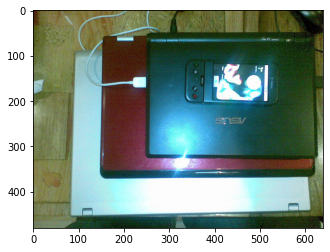

In [ ]:
print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

# 1. Split Image into Patches

The input image is split into N patches (N = 14 x 14 for ViT-Base)
and converted to D=768 embedding vectors by learnable 2D convolution:
```
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
```

In [ ]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


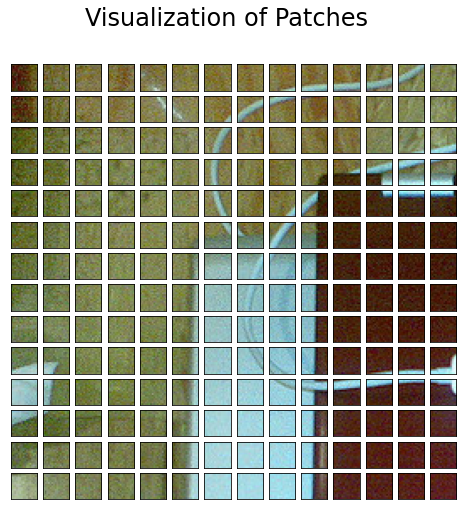

In [ ]:
# This is NOT a part of the pipeline.
# Actually the image is divided into patch embeddings by Conv2d 
# with stride=(16, 16) shown above.
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
fig.add_axes()
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

# 2. Add Position Embeddings
To make patches position-aware, learnable 'position embedding' vectors are added to the patch embedding vectors. The position embedding vectors learn distance within the image thus neighboring ones have high similarity.

### Visualization of position embeddings

In [ ]:
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


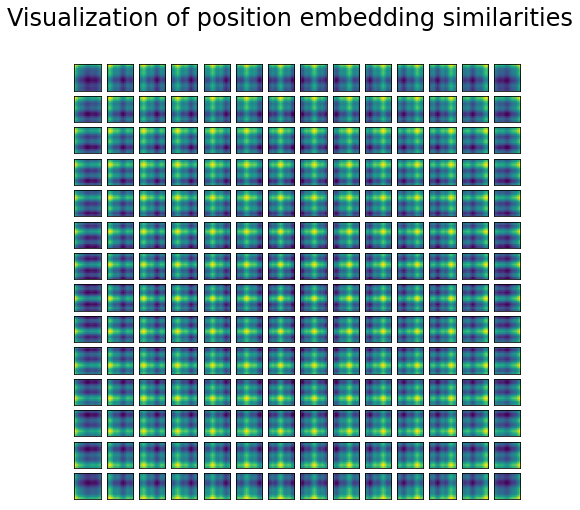

In [ ]:
# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

### Make Transformer Input
A learnable class token is prepended to the patch embedding vectors as the 0th vector.  
197 (1 + 14 x 14) learnable position embedding vectors are added to the patch embedding vectors.

In [ ]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


# 3. Transformer Encoder
<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/transformer_encoder.png?raw=true'>

Figure 2. Detailed schematic of Transformer Encoder. 
- N (=197) embedded vectors are fed to the L (=12) series encoders. 
- The vectors are divided into query, key and value after expanded by an fc layer. 
- q, k and v are further divided into H (=12) and fed to the parallel attention heads. 
- Outputs from attention heads are concatenated to form the vectors whose shape is the same as the encoder input.
- The vectors go through an fc, a layer norm and an MLP block that has two fc layers.

The Vision Transformer employs the Transformer Encoder that was proposed in the [attention is all you need paper](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). 

Implementation Reference: 

- [tensorflow implementation](https://github.com/google-research/vision_transformer/blob/502746cb287a107f9911c061f9d9c2c0159c81cc/vit_jax/models.py#L62-L146)
- [pytorch implementation (timm)](https://github.com/rwightman/pytorch-image-models/blob/198f6ea0f3dae13f041f3ea5880dd79089b60d61/timm/models/vision_transformer.py#L79-L143)


In [ ]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


## How Attention Works

In this part, we are going to see what the actual attention looks like.

In [ ]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])


In [ ]:
# fc layer to expand the dimension
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


In [ ]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


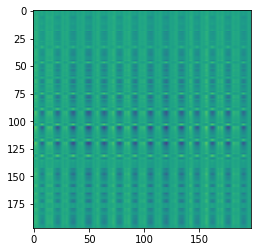

In [ ]:
# Attention Matrix
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

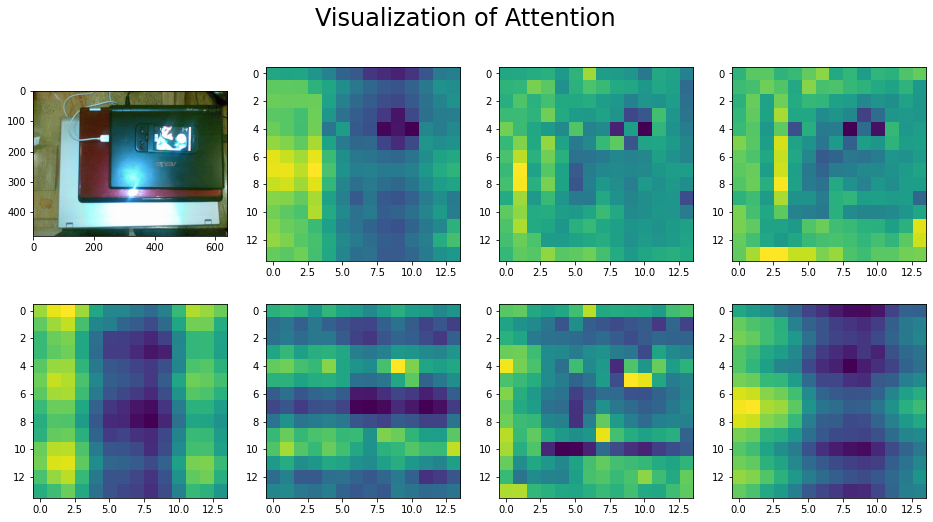

In [ ]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

# 4. MLP (Classification) Head
The 0-th output vector from the transformer output vectors (corresponding to the class token input) is fed to the MLP head.  
The 1000-dimension classification result is the output of the whole pipeline.

Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 605, label name = iPod



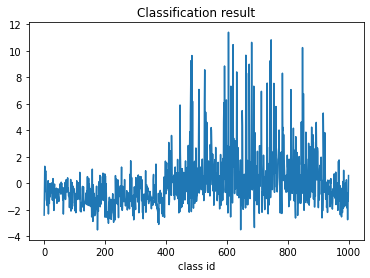

In [ ]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))

In [ ]:
while True:pass

KeyboardInterrupt: ignored

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 13 00:48:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    33W /  70W |   9074MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
